In [2]:
import numpy, pandas
import conntility
import os
import connalysis
import tqdm

from scipy.spatial import distance
from matplotlib import pyplot as plt


In [3]:
# Connectivity matrix to use
fn_mat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_NEWfunct_conmat_filtered_compressed.h5"
M = conntility.ConnectivityMatrix.from_h5(fn_mat)

## Patch sample and analysis helpers

Functions to patch sample and evaluate triads and connection probabilities

In [4]:
def partition_model_into_subvolumes(M, decomposition_plane, decomposition_sz, min_column_sz):
    grps = conntility.circuit_models.neuron_groups.group_by_grid(M.vertices, decomposition_plane, decomposition_sz)
    grps = grps.groupby("grid-subtarget")["node_ids"].apply(list)

    Ms = []
    for grp in grps:
        m = M.subpopulation(grp)
        if len(m) > min_column_sz:
            Ms.append(m)
    return Ms

In [185]:
col_slc = ["slice_x", "slice_y"]

def number_expected_er(P, N):
    from connalysis.network.topology import triad_combinations
    from scipy.stats import binom
    num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
    num_edge_per_non_triad = numpy.array([0, 1, 2])
    non_triad_combinations = numpy.array([1, 6, 3])

    p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
    p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
    assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

    distr_er = binom(N, (p_er / p_er.sum()))
    return distr_er.mean(), distr_er.std()

def sample_and_count_triads(m, mv_cv, n_patch=12, n_samples=25, slice_thickness=150):
    counts = []
    sum_pairs = 0
    sum_connected = 0
    sum_rc = 0
    delta_rec = []
    delta_con = []
    delta_unc = []
    for _ in tqdm.tqdm(range(n_samples)):
        try:
            s = m.slice(numpy.random.rand() * numpy.pi, (numpy.random.rand() - 0.5) * 50, slice_thickness)
            s = s.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=col_slc)
            sum_pairs += (len(s) * (len(s) - 1))
            sum_connected += s.matrix.nnz
            sum_rc += s.to_reciprocal().matrix.nnz
            counts.append(connalysis.network.topology.count_triads_fully_connected(s.matrix > 0, return_normalized=False))
            D = s.vertices[col_slc].values.reshape((1, -1, 2)) - s.vertices[col_slc].values.reshape((-1, 1, 2))
            delta_rec.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() > 0)], columns=["horizontal", "vertical"]
            ))
            delta_con.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() == 0)], columns=["horizontal", "vertical"]
            ))
            delta_unc.append(pandas.DataFrame(
                D[(s.array == 0)], columns=["horizontal", "vertical"]
            ))
        except:
            pass
    P = sum_connected / sum_pairs
    Prec = sum_rc / sum_pairs
    deltas = pandas.concat([
        pandas.concat(delta_rec, axis=0, names=["sample"], keys=range(len(delta_rec))),
        pandas.concat(delta_con, axis=0, names=["sample"], keys=range(len(delta_con))),
        pandas.concat(delta_unc, axis=0, names=["sample"], keys=range(len(delta_unc)))
    ], axis=0, keys=["reciprocal", "unidirectional", "unconnected"])
    counts = numpy.vstack(counts).sum(axis=0)
    return counts, (P, Prec), deltas


Main entry point

In [186]:
def execute_slice_and_patch_campaign(M, param_dict):
    if "decomposition_plane" in param_dict:
        Ms = partition_model_into_subvolumes(M, param_dict["decomposition_plane"],
                                             param_dict["decomposition_sz"], param_dict["min_column_sz"])
    else:
        Ms = [M]
    
    all_counts = []
    all_er = []
    all_deltas = []

    mv_cv = numpy.array(param_dict["mv_cv"])
    patch_kwargs = param_dict["patch_kwargs"]
    allP_u = []; allP_rc = []
    for m in Ms:
        counts, P, deltas = sample_and_count_triads(m, mv_cv, **patch_kwargs)
        allP_u.append(P[0]); allP_rc.append(P[1])
        count_er_mn, count_er_sd = number_expected_er(P[0], counts.sum())
        all_counts.append((counts - count_er_mn) / count_er_sd)
        all_deltas.append(deltas)

    all_counts = pandas.DataFrame(all_counts,
                     index=pandas.RangeIndex(len(all_counts), name="subvolume"),
                     columns=pandas.RangeIndex(13, name="motif"))
    all_deltas = pandas.concat(all_deltas, axis=0, names=["subvolume"], keys=range(len(all_deltas)))
    return all_counts, all_deltas, pandas.DataFrame({"unidirectional": allP_u,
                                                     "reciprocal": allP_rc})
    

## EXECUTE!

### Part I: Triad motifs for a realistic sampling
Note: If you are only interested in part II, you can skip execution of this part.

In [219]:
campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 250,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[145**2, 0], [0, 150**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 200,
        "n_samples": 55, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

all_counts, all_deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)

  7%|▋         | 4/55 [00:00<00:03, 16.05it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010020732879638672
Found 34 connected triads
Time spent classifying triads: 0.0033054351806640625
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 17 connected triads
Time spent classifying triads: 0.0007781982421875
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 25 connected triads
Time spent classifying triads: 0.001096963882446289
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 14 connected triads
Time spent classifying triads: 0.0006542205810546875


 15%|█▍        | 8/55 [00:00<00:02, 15.82it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0012021064758300781
Found 110 connected triads
Time spent classifying triads: 0.010372400283813477
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 32 connected triads
Time spent classifying triads: 0.001363515853881836
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 15 connected triads
Time spent classifying triads: 0.0007061958312988281
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 13 connected triads
Time spent classifying triads: 0.0006134510040283203


 22%|██▏       | 12/55 [00:00<00:02, 15.62it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.001111745834350586
Found 72 connected triads
Time spent classifying triads: 0.006836414337158203
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 30 connected triads
Time spent classifying triads: 0.0012791156768798828
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 23 connected triads
Time spent classifying triads: 0.0010056495666503906
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010504722595214844
Found 72 connected triads
Time spent classifying triads: 0.002930879592895508


 29%|██▉       | 16/55 [00:01<00:02, 15.60it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009086132049560547
Found 32 connected triads
Time spent classifying triads: 0.003108501434326172
Testing 61 potential triadic pairs
Time spent finding triads: 0.001142740249633789
Found 96 connected triads
Time spent classifying triads: 0.003856658935546875
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007407665252685547
Found 4 connected triads
Time spent classifying triads: 0.0002620220184326172
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010492801666259766
Found 64 connected triads
Time spent classifying triads: 0.002630472183227539


 36%|███▋      | 20/55 [00:01<00:02, 15.74it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 15 connected triads
Time spent classifying triads: 0.0015234947204589844
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009658336639404297
Found 39 connected triads
Time spent classifying triads: 0.0016281604766845703
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007369518280029297
Found 4 connected triads
Time spent classifying triads: 0.00026035308837890625
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011477470397949219
Found 96 connected triads
Time spent classifying triads: 0.003870725631713867


 44%|████▎     | 24/55 [00:01<00:02, 15.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001298666000366211
Found 154 connected triads
Time spent classifying triads: 0.011388778686523438
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 16 connected triads
Time spent classifying triads: 0.0007288455963134766
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011048316955566406
Found 87 connected triads
Time spent classifying triads: 0.003497600555419922
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009722709655761719
Found 49 connected triads
Time spent classifying triads: 0.0020301342010498047


 51%|█████     | 28/55 [00:01<00:01, 15.33it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011594295501708984
Found 86 connected triads
Time spent classifying triads: 0.008162975311279297
Testing 66 potential triadic pairs
Time spent finding triads: 0.001203298568725586
Found 134 connected triads
Time spent classifying triads: 0.0053539276123046875
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009098052978515625
Found 38 connected triads
Time spent classifying triads: 0.0015954971313476562
Testing 59 potential triadic pairs
Time spent finding triads: 0.0010993480682373047
Found 86 connected triads
Time spent classifying triads: 0.003456592559814453


 58%|█████▊    | 32/55 [00:02<00:01, 15.49it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009281635284423828
Found 29 connected triads
Time spent classifying triads: 0.0028200149536132812
Testing 34 potential triadic pairs
Time spent finding triads: 0.000965118408203125
Found 44 connected triads
Time spent classifying triads: 0.0018908977508544922
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010867118835449219
Found 87 connected triads
Time spent classifying triads: 0.0035266876220703125
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007703304290771484
Found 8 connected triads
Time spent classifying triads: 0.00041747093200683594


 65%|██████▌   | 36/55 [00:02<00:01, 15.58it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 20 connected triads
Time spent classifying triads: 0.0019974708557128906
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009288787841796875
Found 36 connected triads
Time spent classifying triads: 0.0015087127685546875
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011603832244873047
Found 109 connected triads
Time spent classifying triads: 0.004355907440185547
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008795261383056641
Found 27 connected triads
Time spent classifying triads: 0.0012443065643310547


 73%|███████▎  | 40/55 [00:02<00:00, 15.62it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 22 connected triads
Time spent classifying triads: 0.0021762847900390625
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 22 connected triads
Time spent classifying triads: 0.0009691715240478516
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009715557098388672
Found 45 connected triads
Time spent classifying triads: 0.001875162124633789
Testing 47 potential triadic pairs
Time spent finding triads: 0.0009851455688476562
Found 53 connected triads
Time spent classifying triads: 0.0021724700927734375


 80%|████████  | 44/55 [00:02<00:00, 15.61it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.000988006591796875
Found 31 connected triads
Time spent classifying triads: 0.0029993057250976562
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011775493621826172
Found 111 connected triads
Time spent classifying triads: 0.004446506500244141
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009436607360839844
Found 41 connected triads
Time spent classifying triads: 0.0017230510711669922
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009794235229492188
Found 47 connected triads
Time spent classifying triads: 0.001961946487426758


 87%|████████▋ | 48/55 [00:03<00:00, 15.74it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001093149185180664
Found 71 connected triads
Time spent classifying triads: 0.0064618587493896484
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 27 connected triads
Time spent classifying triads: 0.0011682510375976562
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 23 connected triads
Time spent classifying triads: 0.001008749008178711
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 31 connected triads
Time spent classifying triads: 0.001329660415649414


 95%|█████████▍| 52/55 [00:03<00:00, 15.71it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 19 connected triads
Time spent classifying triads: 0.0018999576568603516
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010335445404052734
Found 55 connected triads
Time spent classifying triads: 0.002275228500366211
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 26 connected triads
Time spent classifying triads: 0.0011305809020996094
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009441375732421875
Found 37 connected triads
Time spent classifying triads: 0.0015666484832763672


100%|██████████| 55/55 [00:03<00:00, 15.56it/s]


Testing 33 potential triadic pairs
Time spent finding triads: 0.0009837150573730469
Found 32 connected triads
Time spent classifying triads: 0.003126859664916992
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011589527130126953
Found 89 connected triads
Time spent classifying triads: 0.0036110877990722656
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010046958923339844
Found 49 connected triads
Time spent classifying triads: 0.0020263195037841797


  4%|▎         | 2/55 [00:00<00:03, 14.03it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.00116729736328125
Found 92 connected triads
Time spent classifying triads: 0.007813453674316406
Testing 60 potential triadic pairs
Time spent finding triads: 0.001153707504272461
Found 103 connected triads
Time spent classifying triads: 0.004137516021728516
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009758472442626953
Found 22 connected triads
Time spent classifying triads: 0.0009856224060058594
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009434223175048828
Found 44 connected triads
Time spent classifying triads: 0.0018458366394042969


 15%|█▍        | 8/55 [00:00<00:03, 15.38it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010116100311279297
Found 37 connected triads
Time spent classifying triads: 0.0035867691040039062
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 75 connected triads
Time spent classifying triads: 0.0030739307403564453
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007524490356445312
Found 7 connected triads
Time spent classifying triads: 0.000392913818359375
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007801055908203125
Found 10 connected triads
Time spent classifying triads: 0.0005056858062744141


 22%|██▏       | 12/55 [00:00<00:02, 15.07it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011069774627685547
Found 66 connected triads
Time spent classifying triads: 0.006288290023803711
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010056495666503906
Found 56 connected triads
Time spent classifying triads: 0.0023202896118164062
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010981559753417969
Found 79 connected triads
Time spent classifying triads: 0.003628969192504883
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 33 connected triads
Time spent classifying triads: 0.0013964176177978516


 29%|██▉       | 16/55 [00:01<00:02, 15.33it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 7 connected triads
Time spent classifying triads: 0.0007727146148681641
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 42 connected triads
Time spent classifying triads: 0.001771688461303711
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008575916290283203
Found 20 connected triads
Time spent classifying triads: 0.0009119510650634766
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 16 connected triads
Time spent classifying triads: 0.0007691383361816406


 36%|███▋      | 20/55 [00:01<00:02, 15.18it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009124279022216797
Found 22 connected triads
Time spent classifying triads: 0.002177000045776367
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 40 connected triads
Time spent classifying triads: 0.0016748905181884766
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009758472442626953
Found 51 connected triads
Time spent classifying triads: 0.0021080970764160156
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011327266693115234
Found 83 connected triads
Time spent classifying triads: 0.003384113311767578


 44%|████▎     | 24/55 [00:01<00:02, 15.18it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008246898651123047
Found 7 connected triads
Time spent classifying triads: 0.0007770061492919922
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 13 connected triads
Time spent classifying triads: 0.0006265640258789062
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011115074157714844
Found 84 connected triads
Time spent classifying triads: 0.003396749496459961
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 59 connected triads
Time spent classifying triads: 0.0024080276489257812


 51%|█████     | 28/55 [00:01<00:01, 15.17it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.000985860824584961
Found 32 connected triads
Time spent classifying triads: 0.0026781558990478516
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011227130889892578
Found 98 connected triads
Time spent classifying triads: 0.003934383392333984
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009250640869140625
Found 38 connected triads
Time spent classifying triads: 0.001607656478881836
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 25 connected triads
Time spent classifying triads: 0.0010890960693359375


 55%|█████▍    | 30/55 [00:01<00:01, 15.09it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008966922760009766
Found 26 connected triads
Time spent classifying triads: 0.0025565624237060547
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 64 connected triads
Time spent classifying triads: 0.0026197433471679688
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 9 connected triads
Time spent classifying triads: 0.00047016143798828125
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011262893676757812
Found 93 connected triads
Time spent classifying triads: 0.003740549087524414


 62%|██████▏   | 34/55 [00:02<00:01, 15.08it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001020669937133789
Found 49 connected triads
Time spent classifying triads: 0.004696846008300781
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008935928344726562
Found 26 connected triads
Time spent classifying triads: 0.0011692047119140625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012841224670410156
Found 156 connected triads
Time spent classifying triads: 0.0061948299407958984
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011310577392578125
Found 91 connected triads
Time spent classifying triads: 0.0036635398864746094


 69%|██████▉   | 38/55 [00:02<00:01, 14.85it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010349750518798828
Found 54 connected triads
Time spent classifying triads: 0.005184173583984375
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010986328125
Found 79 connected triads
Time spent classifying triads: 0.0031948089599609375
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010192394256591797
Found 66 connected triads
Time spent classifying triads: 0.0037734508514404297
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010616779327392578
Found 78 connected triads
Time spent classifying triads: 0.005076408386230469


 76%|███████▋  | 42/55 [00:02<00:00, 14.75it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.001115560531616211
Found 71 connected triads
Time spent classifying triads: 0.00675511360168457
Testing 25 potential triadic pairs
Time spent finding triads: 0.000873565673828125
Found 25 connected triads
Time spent classifying triads: 0.0010957717895507812
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 14 connected triads
Time spent classifying triads: 0.0006647109985351562
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012061595916748047
Found 129 connected triads
Time spent classifying triads: 0.0051686763763427734


 84%|████████▎ | 46/55 [00:03<00:00, 14.62it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010678768157958984
Found 52 connected triads
Time spent classifying triads: 0.004976987838745117
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011668205261230469
Found 102 connected triads
Time spent classifying triads: 0.004111051559448242
Testing 32 potential triadic pairs
Time spent finding triads: 0.001264810562133789
Found 31 connected triads
Time spent classifying triads: 0.0014715194702148438


 91%|█████████ | 50/55 [00:03<00:00, 14.67it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001569509506225586
Found 48 connected triads
Time spent classifying triads: 0.0024347305297851562
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012984275817871094
Found 119 connected triads
Time spent classifying triads: 0.004809856414794922
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008983612060546875
Found 29 connected triads
Time spent classifying triads: 0.0012431144714355469
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010404586791992188
Found 65 connected triads
Time spent classifying triads: 0.0026443004608154297


100%|██████████| 55/55 [00:03<00:00, 14.93it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010731220245361328
Found 62 connected triads
Time spent classifying triads: 0.005941629409790039
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 27 connected triads
Time spent classifying triads: 0.002638101577758789
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 19 connected triads
Time spent classifying triads: 0.0008549690246582031
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 30 connected triads
Time spent classifying triads: 0.0012810230255126953



  7%|▋         | 4/55 [00:00<00:02, 17.08it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 47 connected triads
Time spent classifying triads: 0.0044956207275390625
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009438991546630859
Found 62 connected triads
Time spent classifying triads: 0.002534627914428711
Testing 53 potential triadic pairs
Time spent finding triads: 0.001178741455078125
Found 59 connected triads
Time spent classifying triads: 0.0024068355560302734
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 85 connected triads
Time spent classifying triads: 0.0034554004669189453


 15%|█▍        | 8/55 [00:00<00:02, 16.89it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 5 connected triads
Time spent classifying triads: 0.0005900859832763672
Testing 19 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 17 connected triads
Time spent classifying triads: 0.0007789134979248047
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009784698486328125
Found 59 connected triads
Time spent classifying triads: 0.002378225326538086
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011661052703857422
Found 116 connected triads
Time spent classifying triads: 0.004632472991943359


 22%|██▏       | 12/55 [00:00<00:02, 16.70it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011298656463623047
Found 92 connected triads
Time spent classifying triads: 0.008696317672729492
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009865760803222656
Found 50 connected triads
Time spent classifying triads: 0.002064228057861328
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 75 connected triads
Time spent classifying triads: 0.0030469894409179688
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 54 connected triads
Time spent classifying triads: 0.0022344589233398438


 29%|██▉       | 16/55 [00:00<00:02, 16.54it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009243488311767578
Found 31 connected triads
Time spent classifying triads: 0.0030128955841064453
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007886886596679688
Found 12 connected triads
Time spent classifying triads: 0.0005872249603271484
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 63 connected triads
Time spent classifying triads: 0.0025835037231445312
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 28 connected triads
Time spent classifying triads: 0.0012135505676269531


 36%|███▋      | 20/55 [00:01<00:02, 16.36it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010371208190917969
Found 52 connected triads
Time spent classifying triads: 0.004978179931640625
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011568069458007812
Found 113 connected triads
Time spent classifying triads: 0.004563331604003906
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 32 connected triads
Time spent classifying triads: 0.0014040470123291016
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010483264923095703
Found 70 connected triads
Time spent classifying triads: 0.002834796905517578


 44%|████▎     | 24/55 [00:01<00:01, 16.78it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 6 connected triads
Time spent classifying triads: 0.0006761550903320312
Testing 46 potential triadic pairs
Time spent finding triads: 0.001010894775390625
Found 61 connected triads
Time spent classifying triads: 0.0025043487548828125
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009236335754394531
Found 40 connected triads
Time spent classifying triads: 0.0016765594482421875
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007255077362060547
Found 2 connected triads
Time spent classifying triads: 0.00017547607421875


 51%|█████     | 28/55 [00:01<00:01, 16.69it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 9 connected triads
Time spent classifying triads: 0.000972747802734375
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009045600891113281
Found 28 connected triads
Time spent classifying triads: 0.0012125968933105469
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009591579437255859
Found 39 connected triads
Time spent classifying triads: 0.0016372203826904297
Testing 32 potential triadic pairs
Time spent finding triads: 0.000919342041015625
Found 41 connected triads
Time spent classifying triads: 0.0017178058624267578


 58%|█████▊    | 32/55 [00:01<00:01, 16.27it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010731220245361328
Found 64 connected triads
Time spent classifying triads: 0.006099700927734375
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010538101196289062
Found 76 connected triads
Time spent classifying triads: 0.0030765533447265625
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010755062103271484
Found 77 connected triads
Time spent classifying triads: 0.0031294822692871094
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011212825775146484
Found 82 connected triads
Time spent classifying triads: 0.003356456756591797


 65%|██████▌   | 36/55 [00:02<00:01, 16.61it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009605884552001953
Found 34 connected triads
Time spent classifying triads: 0.0031774044036865234
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 35 connected triads
Time spent classifying triads: 0.0014858245849609375
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 14 connected triads
Time spent classifying triads: 0.0006558895111083984
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 15 connected triads
Time spent classifying triads: 0.0007050037384033203


 73%|███████▎  | 40/55 [00:02<00:00, 16.19it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 10 connected triads
Time spent classifying triads: 0.0010676383972167969
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010309219360351562
Found 71 connected triads
Time spent classifying triads: 0.0028929710388183594
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010640621185302734
Found 77 connected triads
Time spent classifying triads: 0.003116130828857422
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009353160858154297
Found 37 connected triads
Time spent classifying triads: 0.0015673637390136719


 80%|████████  | 44/55 [00:02<00:00, 16.30it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012204647064208984
Found 109 connected triads
Time spent classifying triads: 0.010307073593139648
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010309219360351562
Found 72 connected triads
Time spent classifying triads: 0.002932310104370117
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 19 connected triads
Time spent classifying triads: 0.0008499622344970703
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009386539459228516
Found 38 connected triads
Time spent classifying triads: 0.0016045570373535156


 87%|████████▋ | 48/55 [00:02<00:00, 16.14it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009613037109375
Found 37 connected triads
Time spent classifying triads: 0.0035779476165771484
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 20 connected triads
Time spent classifying triads: 0.0008935928344726562
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012171268463134766
Found 136 connected triads
Time spent classifying triads: 0.005430459976196289
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 42 connected triads
Time spent classifying triads: 0.001772165298461914


 95%|█████████▍| 52/55 [00:03<00:00, 16.24it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009310245513916016
Found 30 connected triads
Time spent classifying triads: 0.0029375553131103516
Testing 59 potential triadic pairs
Time spent finding triads: 0.0010962486267089844
Found 79 connected triads
Time spent classifying triads: 0.0032041072845458984
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008592605590820312
Found 23 connected triads
Time spent classifying triads: 0.001009225845336914
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 14 connected triads
Time spent classifying triads: 0.000652313232421875


100%|██████████| 55/55 [00:03<00:00, 16.44it/s]


Testing 55 potential triadic pairs
Time spent finding triads: 0.0011277198791503906
Found 79 connected triads
Time spent classifying triads: 0.0075261592864990234
Testing 49 potential triadic pairs
Time spent finding triads: 0.001010894775390625
Found 49 connected triads
Time spent classifying triads: 0.00201416015625
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010905265808105469
Found 92 connected triads
Time spent classifying triads: 0.0036954879760742188


  4%|▎         | 2/55 [00:00<00:03, 14.18it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 15 connected triads
Time spent classifying triads: 0.0015139579772949219
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010652542114257812
Found 70 connected triads
Time spent classifying triads: 0.004422664642333984
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010519027709960938
Found 54 connected triads
Time spent classifying triads: 0.0024733543395996094


 11%|█         | 6/55 [00:00<00:03, 13.73it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011737346649169922
Found 85 connected triads
Time spent classifying triads: 0.004036903381347656
Testing 13 potential triadic pairs
Time spent finding triads: 0.0009293556213378906
Found 17 connected triads
Time spent classifying triads: 0.0008485317230224609
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010471343994140625
Found 62 connected triads
Time spent classifying triads: 0.002541065216064453


 15%|█▍        | 8/55 [00:00<00:03, 13.86it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009360313415527344
Found 33 connected triads
Time spent classifying triads: 0.002864360809326172
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008704662322998047
Found 29 connected triads
Time spent classifying triads: 0.001251220703125
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 59 connected triads
Time spent classifying triads: 0.00241851806640625


 22%|██▏       | 12/55 [00:00<00:03, 13.95it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008971691131591797
Found 20 connected triads
Time spent classifying triads: 0.001997232437133789
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011830329895019531
Found 112 connected triads
Time spent classifying triads: 0.004479169845581055
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009467601776123047
Found 39 connected triads
Time spent classifying triads: 0.0016522407531738281


 25%|██▌       | 14/55 [00:01<00:02, 13.84it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010235309600830078
Found 68 connected triads
Time spent classifying triads: 0.005113124847412109
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010879039764404297
Found 82 connected triads
Time spent classifying triads: 0.0033376216888427734
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010466575622558594
Found 61 connected triads
Time spent classifying triads: 0.0024912357330322266


 33%|███▎      | 18/55 [00:01<00:02, 14.03it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009086132049560547
Found 28 connected triads
Time spent classifying triads: 0.002744436264038086
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 25 connected triads
Time spent classifying triads: 0.0011012554168701172
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008957386016845703
Found 27 connected triads
Time spent classifying triads: 0.0011708736419677734


 36%|███▋      | 20/55 [00:01<00:02, 13.98it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 24 connected triads
Time spent classifying triads: 0.002393007278442383
Testing 50 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 62 connected triads
Time spent classifying triads: 0.0025262832641601562
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011518001556396484
Found 91 connected triads
Time spent classifying triads: 0.0036742687225341797


 44%|████▎     | 24/55 [00:01<00:02, 13.82it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001285552978515625
Found 70 connected triads
Time spent classifying triads: 0.006675004959106445
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010423660278320312
Found 60 connected triads
Time spent classifying triads: 0.0024585723876953125
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009951591491699219
Found 52 connected triads
Time spent classifying triads: 0.002158641815185547


 47%|████▋     | 26/55 [00:01<00:02, 13.82it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 21 connected triads
Time spent classifying triads: 0.002089262008666992
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010211467742919922
Found 66 connected triads
Time spent classifying triads: 0.002694368362426758
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007786750793457031
Found 8 connected triads
Time spent classifying triads: 0.0004317760467529297


 55%|█████▍    | 30/55 [00:02<00:01, 13.94it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009179115295410156
Found 21 connected triads
Time spent classifying triads: 0.0021109580993652344
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011138916015625
Found 80 connected triads
Time spent classifying triads: 0.003247499465942383
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 31 connected triads
Time spent classifying triads: 0.0013322830200195312


 58%|█████▊    | 32/55 [00:02<00:01, 13.87it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010933876037597656
Found 75 connected triads
Time spent classifying triads: 0.004580020904541016
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010330677032470703
Found 63 connected triads
Time spent classifying triads: 0.002593994140625
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 11 connected triads
Time spent classifying triads: 0.0005342960357666016


 65%|██████▌   | 36/55 [00:02<00:01, 13.90it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.000997781753540039
Found 48 connected triads
Time spent classifying triads: 0.004586935043334961
Testing 55 potential triadic pairs
Time spent finding triads: 0.00113677978515625
Found 91 connected triads
Time spent classifying triads: 0.0037183761596679688
Testing 50 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 72 connected triads
Time spent classifying triads: 0.0029087066650390625


 69%|██████▉   | 38/55 [00:02<00:01, 13.84it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001140594482421875
Found 81 connected triads
Time spent classifying triads: 0.007688999176025391
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010004043579101562
Found 52 connected triads
Time spent classifying triads: 0.0021469593048095703
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 15 connected triads
Time spent classifying triads: 0.0007102489471435547


 76%|███████▋  | 42/55 [00:03<00:00, 14.03it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0015680789947509766
Found 60 connected triads
Time spent classifying triads: 0.005415678024291992
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 30 connected triads
Time spent classifying triads: 0.001285552978515625
Testing 17 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 15 connected triads
Time spent classifying triads: 0.0006902217864990234


 80%|████████  | 44/55 [00:03<00:00, 14.02it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0016088485717773438
Found 24 connected triads
Time spent classifying triads: 0.002335071563720703
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 6 connected triads
Time spent classifying triads: 0.00034046173095703125
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009913444519042969
Found 56 connected triads
Time spent classifying triads: 0.0022995471954345703


 87%|████████▋ | 48/55 [00:03<00:00, 13.95it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0013353824615478516
Found 44 connected triads
Time spent classifying triads: 0.003846883773803711
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009715557098388672
Found 44 connected triads
Time spent classifying triads: 0.0018355846405029297
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009567737579345703
Found 41 connected triads
Time spent classifying triads: 0.001712799072265625


 91%|█████████ | 50/55 [00:03<00:00, 13.97it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010759830474853516
Found 56 connected triads
Time spent classifying triads: 0.004754781723022461
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 27 connected triads
Time spent classifying triads: 0.0011785030364990234
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010154247283935547
Found 58 connected triads
Time spent classifying triads: 0.0024213790893554688


 98%|█████████▊| 54/55 [00:03<00:00, 14.07it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010418891906738281
Found 54 connected triads
Time spent classifying triads: 0.005167245864868164
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 19 connected triads
Time spent classifying triads: 0.0008642673492431641
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008597373962402344
Found 21 connected triads
Time spent classifying triads: 0.0009331703186035156


100%|██████████| 55/55 [00:03<00:00, 13.90it/s]


Testing 46 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 56 connected triads
Time spent classifying triads: 0.00531458854675293


  4%|▎         | 2/55 [00:00<00:03, 17.56it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 20 connected triads
Time spent classifying triads: 0.0019872188568115234
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 30 connected triads
Time spent classifying triads: 0.0012860298156738281
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 30 connected triads
Time spent classifying triads: 0.0012965202331542969


  7%|▋         | 4/55 [00:00<00:03, 16.99it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001125335693359375
Found 66 connected triads
Time spent classifying triads: 0.006318092346191406


 11%|█         | 6/55 [00:00<00:02, 17.01it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011425018310546875
Found 87 connected triads
Time spent classifying triads: 0.008220434188842773
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 25 connected triads
Time spent classifying triads: 0.0010919570922851562
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010678768157958984
Found 69 connected triads
Time spent classifying triads: 0.0028085708618164062


 15%|█▍        | 8/55 [00:00<00:02, 16.98it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009486675262451172
Found 29 connected triads
Time spent classifying triads: 0.002829313278198242


 18%|█▊        | 10/55 [00:00<00:02, 17.26it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010154247283935547
Found 48 connected triads
Time spent classifying triads: 0.004587888717651367
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009875297546386719
Found 50 connected triads
Time spent classifying triads: 0.0020623207092285156
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009958744049072266
Found 59 connected triads
Time spent classifying triads: 0.002397775650024414


 22%|██▏       | 12/55 [00:00<00:02, 17.31it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008816719055175781
Found 19 connected triads
Time spent classifying triads: 0.0018956661224365234


 25%|██▌       | 14/55 [00:00<00:02, 16.72it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 59 connected triads
Time spent classifying triads: 0.0056345462799072266
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010645389556884766
Found 71 connected triads
Time spent classifying triads: 0.0029032230377197266
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 49 connected triads
Time spent classifying triads: 0.0020225048065185547


 29%|██▉       | 16/55 [00:00<00:02, 16.43it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011894702911376953
Found 105 connected triads
Time spent classifying triads: 0.009918451309204102


 33%|███▎      | 18/55 [00:01<00:02, 16.54it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 7 connected triads
Time spent classifying triads: 0.0007715225219726562
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010101795196533203
Found 59 connected triads
Time spent classifying triads: 0.0024194717407226562
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010831356048583984
Found 81 connected triads
Time spent classifying triads: 0.003275632858276367


 36%|███▋      | 20/55 [00:01<00:02, 16.70it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 16 connected triads
Time spent classifying triads: 0.0016129016876220703


 40%|████      | 22/55 [00:01<00:01, 16.66it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010716915130615234
Found 63 connected triads
Time spent classifying triads: 0.0045926570892333984
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010671615600585938
Found 68 connected triads
Time spent classifying triads: 0.0027697086334228516
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009236335754394531
Found 33 connected triads
Time spent classifying triads: 0.0014095306396484375


 44%|████▎     | 24/55 [00:01<00:01, 16.46it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009610652923583984
Found 28 connected triads
Time spent classifying triads: 0.0027205944061279297


 47%|████▋     | 26/55 [00:01<00:01, 16.45it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010790824890136719
Found 66 connected triads
Time spent classifying triads: 0.006262779235839844
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009062290191650391
Found 32 connected triads
Time spent classifying triads: 0.0013566017150878906
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010149478912353516
Found 64 connected triads
Time spent classifying triads: 0.002640962600708008


 51%|█████     | 28/55 [00:01<00:01, 16.51it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010519027709960938
Found 62 connected triads
Time spent classifying triads: 0.005925655364990234


 55%|█████▍    | 30/55 [00:01<00:01, 16.40it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.000965118408203125
Found 37 connected triads
Time spent classifying triads: 0.003078937530517578
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010175704956054688
Found 57 connected triads
Time spent classifying triads: 0.0023374557495117188
Testing 4 potential triadic pairs
Time spent finding triads: 0.00074005126953125
Found 4 connected triads
Time spent classifying triads: 0.0002627372741699219


 58%|█████▊    | 32/55 [00:01<00:01, 16.61it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011942386627197266
Found 97 connected triads
Time spent classifying triads: 0.009186267852783203


 62%|██████▏   | 34/55 [00:02<00:01, 16.23it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010001659393310547
Found 55 connected triads
Time spent classifying triads: 0.005252838134765625
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009317398071289062
Found 42 connected triads
Time spent classifying triads: 0.0017511844635009766
Testing 58 potential triadic pairs
Time spent finding triads: 0.001089334487915039
Found 77 connected triads
Time spent classifying triads: 0.0031032562255859375


 65%|██████▌   | 36/55 [00:02<00:01, 16.23it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011494159698486328
Found 86 connected triads
Time spent classifying triads: 0.008165359497070312


 69%|██████▉   | 38/55 [00:02<00:01, 16.24it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009520053863525391
Found 28 connected triads
Time spent classifying triads: 0.002737283706665039
Testing 47 potential triadic pairs
Time spent finding triads: 0.001009225845336914
Found 52 connected triads
Time spent classifying triads: 0.002154827117919922
Testing 35 potential triadic pairs
Time spent finding triads: 0.00092315673828125
Found 34 connected triads
Time spent classifying triads: 0.0014450550079345703


 73%|███████▎  | 40/55 [00:02<00:00, 16.46it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011219978332519531
Found 72 connected triads
Time spent classifying triads: 0.006875038146972656


 76%|███████▋  | 42/55 [00:02<00:00, 16.35it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011696815490722656
Found 92 connected triads
Time spent classifying triads: 0.008621692657470703
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009157657623291016
Found 31 connected triads
Time spent classifying triads: 0.0013318061828613281
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009758472442626953
Found 55 connected triads
Time spent classifying triads: 0.002259969711303711


 80%|████████  | 44/55 [00:02<00:00, 16.43it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010111331939697266
Found 50 connected triads
Time spent classifying triads: 0.004755735397338867


 84%|████████▎ | 46/55 [00:02<00:00, 16.43it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010912418365478516
Found 75 connected triads
Time spent classifying triads: 0.007138729095458984
Testing 60 potential triadic pairs
Time spent finding triads: 0.00113677978515625
Found 100 connected triads
Time spent classifying triads: 0.004063606262207031
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009262561798095703
Found 38 connected triads
Time spent classifying triads: 0.0015957355499267578


 87%|████████▋ | 48/55 [00:02<00:00, 16.69it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 22 connected triads
Time spent classifying triads: 0.002183675765991211


 91%|█████████ | 50/55 [00:03<00:00, 16.32it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010881423950195312
Found 67 connected triads
Time spent classifying triads: 0.006367683410644531
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011036396026611328
Found 87 connected triads
Time spent classifying triads: 0.0035185813903808594
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008709430694580078
Found 31 connected triads
Time spent classifying triads: 0.0013113021850585938


 95%|█████████▍| 52/55 [00:03<00:00, 16.50it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001051187515258789
Found 51 connected triads
Time spent classifying triads: 0.004861593246459961


100%|██████████| 55/55 [00:03<00:00, 16.57it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010190010070800781
Found 56 connected triads
Time spent classifying triads: 0.0053539276123046875
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009617805480957031
Found 41 connected triads
Time spent classifying triads: 0.0017130374908447266
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 27 connected triads
Time spent classifying triads: 0.0011582374572753906



  7%|▋         | 4/55 [00:00<00:03, 15.54it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008575916290283203
Found 21 connected triads
Time spent classifying triads: 0.002082347869873047
Testing 34 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 30 connected triads
Time spent classifying triads: 0.0012969970703125
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010194778442382812
Found 61 connected triads
Time spent classifying triads: 0.002505064010620117
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011591911315917969
Found 106 connected triads
Time spent classifying triads: 0.004221916198730469


 15%|█▍        | 8/55 [00:00<00:03, 15.29it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011339187622070312
Found 77 connected triads
Time spent classifying triads: 0.0073468685150146484
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009725093841552734
Found 41 connected triads
Time spent classifying triads: 0.0017240047454833984
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010046958923339844
Found 57 connected triads
Time spent classifying triads: 0.0023345947265625
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 65 connected triads
Time spent classifying triads: 0.002650022506713867


 22%|██▏       | 12/55 [00:00<00:02, 15.31it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011968612670898438
Found 96 connected triads
Time spent classifying triads: 0.008742094039916992
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007452964782714844
Found 5 connected triads
Time spent classifying triads: 0.00029850006103515625
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008971691131591797
Found 25 connected triads
Time spent classifying triads: 0.0010876655578613281
Testing 1 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 1 connected triads
Time spent classifying triads: 0.000164031982421875


 25%|██▌       | 14/55 [00:00<00:02, 15.11it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001322031021118164
Found 120 connected triads
Time spent classifying triads: 0.00872039794921875
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010929107666015625
Found 40 connected triads
Time spent classifying triads: 0.0022325515747070312
Testing 32 potential triadic pairs
Time spent finding triads: 0.0010251998901367188
Found 30 connected triads
Time spent classifying triads: 0.0020291805267333984
Testing 48 potential triadic pairs
Time spent finding triads: 0.0011396408081054688
Found 54 connected triads


 33%|███▎      | 18/55 [00:01<00:02, 15.16it/s]

Time spent classifying triads: 0.0038595199584960938
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 41 connected triads
Time spent classifying triads: 0.0028023719787597656
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009686946868896484
Found 41 connected triads
Time spent classifying triads: 0.0017063617706298828
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010352134704589844
Found 55 connected triads
Time spent classifying triads: 0.0022754669189453125


 40%|████      | 22/55 [00:01<00:02, 15.50it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009722709655761719
Found 32 connected triads
Time spent classifying triads: 0.0031092166900634766
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 31 connected triads
Time spent classifying triads: 0.0013287067413330078
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 26 connected triads
Time spent classifying triads: 0.0011348724365234375
Testing 52 potential triadic pairs
Time spent finding triads: 0.00103759765625
Found 63 connected triads
Time spent classifying triads: 0.0025823116302490234


 47%|████▋     | 26/55 [00:01<00:01, 15.78it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 17 connected triads
Time spent classifying triads: 0.0017218589782714844
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 27 connected triads
Time spent classifying triads: 0.0011675357818603516
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 27 connected triads
Time spent classifying triads: 0.0011625289916992188
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010006427764892578
Found 51 connected triads
Time spent classifying triads: 0.0020952224731445312


 55%|█████▍    | 30/55 [00:01<00:01, 15.67it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001116037368774414
Found 68 connected triads
Time spent classifying triads: 0.0064678192138671875
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 42 connected triads
Time spent classifying triads: 0.0017325878143310547
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010759830474853516
Found 77 connected triads
Time spent classifying triads: 0.003168821334838867
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007381439208984375
Found 4 connected triads
Time spent classifying triads: 0.0002574920654296875


 62%|██████▏   | 34/55 [00:02<00:01, 15.53it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001199960708618164
Found 97 connected triads
Time spent classifying triads: 0.009280681610107422
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 16 connected triads
Time spent classifying triads: 0.0007328987121582031
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011303424835205078
Found 93 connected triads
Time spent classifying triads: 0.0037431716918945312
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011506080627441406
Found 93 connected triads
Time spent classifying triads: 0.0037660598754882812


 69%|██████▉   | 38/55 [00:02<00:01, 15.53it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001064300537109375
Found 59 connected triads
Time spent classifying triads: 0.005664348602294922
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009229183197021484
Found 34 connected triads
Time spent classifying triads: 0.0014421939849853516
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009019374847412109
Found 36 connected triads
Time spent classifying triads: 0.0015330314636230469
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011224746704101562
Found 105 connected triads
Time spent classifying triads: 0.004207611083984375


 76%|███████▋  | 42/55 [00:02<00:00, 15.54it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 8 connected triads
Time spent classifying triads: 0.0008749961853027344
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007262229919433594
Found 2 connected triads
Time spent classifying triads: 0.0001804828643798828
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011622905731201172
Found 109 connected triads
Time spent classifying triads: 0.004389047622680664
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012502670288085938
Found 142 connected triads
Time spent classifying triads: 0.005717039108276367


 84%|████████▎ | 46/55 [00:02<00:00, 15.49it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011749267578125
Found 93 connected triads
Time spent classifying triads: 0.00882577896118164
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009129047393798828
Found 35 connected triads
Time spent classifying triads: 0.0014922618865966797
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011115074157714844
Found 90 connected triads
Time spent classifying triads: 0.0036907196044921875
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 16 connected triads
Time spent classifying triads: 0.0007386207580566406


 91%|█████████ | 50/55 [00:03<00:00, 15.58it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010297298431396484
Found 47 connected triads
Time spent classifying triads: 0.0041086673736572266
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010921955108642578
Found 83 connected triads
Time spent classifying triads: 0.003373384475708008
Testing 32 potential triadic pairs
Time spent finding triads: 0.00090789794921875
Found 30 connected triads
Time spent classifying triads: 0.0012788772583007812
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009593963623046875
Found 44 connected triads
Time spent classifying triads: 0.0018239021301269531


100%|██████████| 55/55 [00:03<00:00, 15.44it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 6 connected triads
Time spent classifying triads: 0.0006809234619140625
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011892318725585938
Found 110 connected triads
Time spent classifying triads: 0.004529237747192383
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 31 connected triads
Time spent classifying triads: 0.0013213157653808594
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011975765228271484
Found 124 connected triads
Time spent classifying triads: 0.004950523376464844



  7%|▋         | 4/55 [00:00<00:03, 15.70it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 60 connected triads
Time spent classifying triads: 0.00573277473449707
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007250308990478516
Found 2 connected triads
Time spent classifying triads: 0.0001780986785888672
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011725425720214844
Found 102 connected triads
Time spent classifying triads: 0.004161357879638672
Testing 50 potential triadic pairs
Time spent finding triads: 0.001016378402709961
Found 50 connected triads
Time spent classifying triads: 0.0020449161529541016


 15%|█▍        | 8/55 [00:00<00:03, 15.52it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011737346649169922
Found 86 connected triads
Time spent classifying triads: 0.008167743682861328
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007236003875732422
Found 2 connected triads
Time spent classifying triads: 0.0001800060272216797
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 28 connected triads
Time spent classifying triads: 0.0012035369873046875
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011591911315917969
Found 103 connected triads
Time spent classifying triads: 0.0042552947998046875


 22%|██▏       | 12/55 [00:00<00:02, 15.82it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008881092071533203
Found 18 connected triads
Time spent classifying triads: 0.0018024444580078125
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007600784301757812
Found 5 connected triads
Time spent classifying triads: 0.000301361083984375
Testing 60 potential triadic pairs
Time spent finding triads: 0.001117706298828125
Found 84 connected triads
Time spent classifying triads: 0.0034236907958984375
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 26 connected triads
Time spent classifying triads: 0.001127004623413086


 29%|██▉       | 16/55 [00:01<00:02, 15.79it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010495185852050781
Found 47 connected triads
Time spent classifying triads: 0.004537820816040039
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010638236999511719
Found 69 connected triads
Time spent classifying triads: 0.002802133560180664
Testing 58 potential triadic pairs
Time spent finding triads: 0.001150369644165039
Found 80 connected triads
Time spent classifying triads: 0.0032808780670166016
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008668899536132812
Found 23 connected triads
Time spent classifying triads: 0.001004934310913086


 36%|███▋      | 20/55 [00:01<00:02, 15.79it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010673999786376953
Found 62 connected triads
Time spent classifying triads: 0.0059282779693603516
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010187625885009766
Found 61 connected triads
Time spent classifying triads: 0.0024878978729248047
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010521411895751953
Found 72 connected triads
Time spent classifying triads: 0.002911806106567383
Testing 41 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 51 connected triads
Time spent classifying triads: 0.002115488052368164


 44%|████▎     | 24/55 [00:01<00:01, 15.84it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.00115966796875
Found 93 connected triads
Time spent classifying triads: 0.008774042129516602
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 36 connected triads
Time spent classifying triads: 0.0015003681182861328
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009851455688476562
Found 51 connected triads
Time spent classifying triads: 0.0021033287048339844
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007684230804443359
Found 9 connected triads
Time spent classifying triads: 0.0004611015319824219


 51%|█████     | 28/55 [00:01<00:01, 15.61it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010492801666259766
Found 45 connected triads
Time spent classifying triads: 0.003995418548583984
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010182857513427734
Found 60 connected triads
Time spent classifying triads: 0.0024993419647216797
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010843276977539062
Found 91 connected triads
Time spent classifying triads: 0.0036764144897460938
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010666847229003906
Found 75 connected triads
Time spent classifying triads: 0.0030298233032226562


 58%|█████▊    | 32/55 [00:02<00:01, 15.92it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008528232574462891
Found 14 connected triads
Time spent classifying triads: 0.0014231204986572266
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 14 connected triads
Time spent classifying triads: 0.0006525516510009766
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007576942443847656
Found 8 connected triads
Time spent classifying triads: 0.00042748451232910156
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010073184967041016
Found 56 connected triads
Time spent classifying triads: 0.0023355484008789062


 65%|██████▌   | 36/55 [00:02<00:01, 16.06it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010309219360351562
Found 41 connected triads
Time spent classifying triads: 0.0039517879486083984
Testing 54 potential triadic pairs
Time spent finding triads: 0.001117706298828125
Found 101 connected triads
Time spent classifying triads: 0.004058361053466797
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008978843688964844
Found 30 connected triads
Time spent classifying triads: 0.0012981891632080078
Testing 32 potential triadic pairs
Time spent finding triads: 0.0008916854858398438
Found 30 connected triads
Time spent classifying triads: 0.0012888908386230469


 73%|███████▎  | 40/55 [00:02<00:00, 16.01it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.001043081283569336
Found 51 connected triads
Time spent classifying triads: 0.004896640777587891
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009970664978027344
Found 56 connected triads
Time spent classifying triads: 0.002395153045654297
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008606910705566406
Found 25 connected triads
Time spent classifying triads: 0.001089334487915039
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011379718780517578
Found 94 connected triads
Time spent classifying triads: 0.003779172897338867


 80%|████████  | 44/55 [00:02<00:00, 16.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 3 connected triads
Time spent classifying triads: 0.0003943443298339844
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009279251098632812
Found 33 connected triads
Time spent classifying triads: 0.001407623291015625
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 27 connected triads
Time spent classifying triads: 0.0011758804321289062
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011119842529296875
Found 87 connected triads
Time spent classifying triads: 0.0035545825958251953


 87%|████████▋ | 48/55 [00:03<00:00, 15.82it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012657642364501953
Found 134 connected triads
Time spent classifying triads: 0.012644290924072266
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011243820190429688
Found 91 connected triads
Time spent classifying triads: 0.0036773681640625
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 26 connected triads
Time spent classifying triads: 0.0011296272277832031
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011608600616455078
Found 114 connected triads
Time spent classifying triads: 0.004576921463012695


 95%|█████████▍| 52/55 [00:03<00:00, 15.94it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 10 connected triads
Time spent classifying triads: 0.0010652542114257812
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 25 connected triads
Time spent classifying triads: 0.0010828971862792969
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009999275207519531
Found 53 connected triads
Time spent classifying triads: 0.002173185348510742
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012149810791015625
Found 136 connected triads
Time spent classifying triads: 0.005394935607910156


100%|██████████| 55/55 [00:03<00:00, 15.85it/s]


Testing 24 potential triadic pairs
Time spent finding triads: 0.0009217262268066406
Found 28 connected triads
Time spent classifying triads: 0.002749919891357422
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009357929229736328
Found 36 connected triads
Time spent classifying triads: 0.0015132427215576172
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007271766662597656
Found 3 connected triads
Time spent classifying triads: 0.0002205371856689453


#### Plot triads


Text(0, 0.5, 'Z-score')

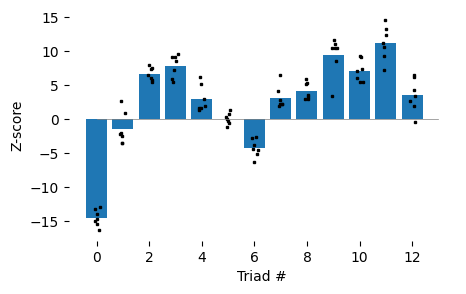

In [188]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.bar(all_counts.columns, all_counts.mean())
x = numpy.repeat(all_counts.columns.values.reshape((1, -1)), len(all_counts), axis=0)
x = x + 0.25 * (numpy.random.rand(*x.shape) - 0.5)
ax.plot(x, all_counts.values, color="black", ls="None", marker='s', ms=2)
ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

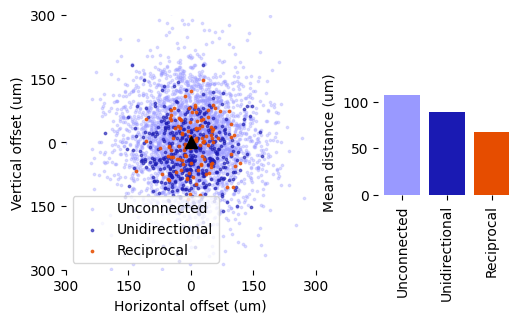

In [223]:
i = 0
d = all_deltas.loc[i]
d["distance"] = numpy.linalg.norm(d, axis=1)
dists = d.reset_index().groupby("level_0")["distance"].mean()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])

def sample_random_fraction(arr_in, frac):
    assert frac <= 1
    b = numpy.random.choice(len(arr_in), int(len(arr_in) * frac), replace=False)
    return arr_in.iloc[b]["horizontal"], arr_in.iloc[b]["vertical"]

cols_use = [[0.6, 0.6, 1.0], [0.1, 0.1, 0.7], [0.9, 0.3, 0.0]]

ax.scatter(*sample_random_fraction(d.loc["unconnected"], 0.5), color=cols_use[0], s=3, alpha=0.3, label="Unconnected")
ax.scatter(*sample_random_fraction(d.loc["unidirectional"], 0.5), color=cols_use[1], s=3, alpha=0.6, label="Unidirectional")
ax.scatter(*sample_random_fraction(d.loc["reciprocal"], 0.5), color=cols_use[2], s=3, alpha=0.8, label="Reciprocal")
ax.plot(0, 0, marker="^", ms=8, color="black")
ax.set_xlabel("Horizontal offset (um)")
ax.set_ylabel("Vertical offset (um)")
ax.set_frame_on(False)
# plt.axis("equal")
ax.set_xlim([-300, 300]); ax.set_xticks([-300, -150, 0, 150, 300]); ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_ylim([-300, 300]); ax.set_yticks([-300, -150, 0, 150, 300]); ax.set_yticklabels([300, 150, 0, 150, 300])
plt.legend()

ax = fig.add_axes([0.725, 0.35, 0.275, 0.35])
ax.bar(2, dists["reciprocal"], color=cols_use[2])
ax.bar(1, dists["unidirectional"], color=cols_use[1])
ax.bar(0, dists["unconnected"], color=cols_use[0])
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["Unconnected", "Unidirectional", "Reciprocal"], rotation="vertical")
ax.set_ylabel("Mean distance (um)")
ax.set_frame_on(False)

The purpose of the plot above is to show our sampling, and that it resembles in vitro sampling.
To be compared to Peng et al., Figure 2A

Also, we see that at this scale there is a bit of distance-dependence, but not much: Unconnected, unidirectionally connected and reciprocally connected pairs are at slightly different distances.

## Part II: How the scale over which we sample affects things
This part includes a look at reciprocal connectivity: Is it over- or under-expressed?

Systematic sampling at different scales

In [245]:
szs = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]
all_counts = []
all_P = []
for sz_arg in [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]:
    campaign_cfg = {
        "mv_cv": [[sz_arg**2, 0], [0, sz_arg**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
        "patch_kwargs": {
            "slice_thickness": sz_arg * 2.5,
            "n_samples": 200, # The number of times the patch sampling procedure will be applied
            "n_patch": 12 # Up to this number of neurons will be sampled together
        }
    }

    counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)
    all_counts.append(counts)
    all_P.append(P)
    
all_counts = pandas.concat(all_counts, axis=0, keys=szs, names=["scale"])
all_P = pandas.concat(all_P, axis=0, keys=szs, names=["scale"])  

  1%|          | 2/200 [00:00<00:32,  6.13it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0014336109161376953
Found 110 connected triads
Time spent classifying triads: 0.010578393936157227
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012106895446777344
Found 130 connected triads
Time spent classifying triads: 0.005173921585083008


  2%|▏         | 4/200 [00:00<00:29,  6.54it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009489059448242188
Found 31 connected triads
Time spent classifying triads: 0.003035306930541992
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012145042419433594
Found 149 connected triads
Time spent classifying triads: 0.005986928939819336


  3%|▎         | 6/200 [00:00<00:28,  6.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013129711151123047
Found 158 connected triads
Time spent classifying triads: 0.014871358871459961
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010843276977539062
Found 72 connected triads
Time spent classifying triads: 0.00292205810546875


  4%|▍         | 8/200 [00:01<00:28,  6.78it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001203298568725586
Found 119 connected triads
Time spent classifying triads: 0.011237621307373047
Testing 64 potential triadic pairs
Time spent finding triads: 0.001148223876953125
Found 105 connected triads
Time spent classifying triads: 0.004228830337524414


  5%|▌         | 10/200 [00:01<00:27,  6.85it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012462139129638672
Found 132 connected triads
Time spent classifying triads: 0.012427330017089844
Testing 66 potential triadic pairs
Time spent finding triads: 0.001277923583984375
Found 166 connected triads
Time spent classifying triads: 0.006564617156982422


  6%|▌         | 12/200 [00:01<00:28,  6.64it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012328624725341797
Found 118 connected triads
Time spent classifying triads: 0.011132001876831055
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011696815490722656
Found 124 connected triads
Time spent classifying triads: 0.004988670349121094


  7%|▋         | 14/200 [00:02<00:28,  6.54it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011832714080810547
Found 105 connected triads
Time spent classifying triads: 0.009941339492797852
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010776519775390625
Found 72 connected triads
Time spent classifying triads: 0.002937793731689453


  8%|▊         | 16/200 [00:02<00:28,  6.52it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009951591491699219
Found 37 connected triads
Time spent classifying triads: 0.003577709197998047
Testing 62 potential triadic pairs
Time spent finding triads: 0.0010929107666015625
Found 73 connected triads
Time spent classifying triads: 0.002934694290161133


  9%|▉         | 18/200 [00:02<00:29,  6.26it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010418891906738281
Found 50 connected triads
Time spent classifying triads: 0.004749298095703125
Testing 65 potential triadic pairs
Time spent finding triads: 0.001184225082397461
Found 122 connected triads
Time spent classifying triads: 0.004865169525146484


 10%|█         | 20/200 [00:03<00:28,  6.36it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012166500091552734
Found 112 connected triads
Time spent classifying triads: 0.010585784912109375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 117 connected triads
Time spent classifying triads: 0.004678964614868164


 11%|█         | 22/200 [00:03<00:27,  6.37it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011012554168701172
Found 65 connected triads
Time spent classifying triads: 0.00620269775390625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011563301086425781
Found 114 connected triads
Time spent classifying triads: 0.004594564437866211


 12%|█▏        | 24/200 [00:03<00:27,  6.37it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012292861938476562
Found 124 connected triads
Time spent classifying triads: 0.011690855026245117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012531280517578125
Found 152 connected triads
Time spent classifying triads: 0.0060346126556396484


 13%|█▎        | 26/200 [00:04<00:27,  6.35it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011982917785644531
Found 77 connected triads
Time spent classifying triads: 0.007405996322631836
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012559890747070312
Found 148 connected triads
Time spent classifying triads: 0.005959272384643555


 14%|█▍        | 28/200 [00:04<00:26,  6.60it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010688304901123047
Found 55 connected triads
Time spent classifying triads: 0.003920793533325195
Testing 66 potential triadic pairs
Time spent finding triads: 0.001180887222290039
Found 122 connected triads
Time spent classifying triads: 0.004892587661743164


 15%|█▌        | 30/200 [00:04<00:25,  6.66it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001293182373046875
Found 142 connected triads
Time spent classifying triads: 0.013357400894165039
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011563301086425781
Found 99 connected triads
Time spent classifying triads: 0.004000425338745117


 16%|█▌        | 32/200 [00:04<00:25,  6.65it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013506412506103516
Found 156 connected triads
Time spent classifying triads: 0.014652490615844727
Testing 59 potential triadic pairs
Time spent finding triads: 0.001142263412475586
Found 97 connected triads
Time spent classifying triads: 0.0038957595825195312


 17%|█▋        | 34/200 [00:05<00:25,  6.54it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 152 connected triads
Time spent classifying triads: 0.014340639114379883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013387203216552734
Found 190 connected triads
Time spent classifying triads: 0.0075380802154541016


 18%|█▊        | 36/200 [00:05<00:24,  6.64it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001129150390625
Found 79 connected triads
Time spent classifying triads: 0.007524967193603516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012559890747070312
Found 148 connected triads
Time spent classifying triads: 0.006104230880737305


 19%|█▉        | 38/200 [00:05<00:24,  6.73it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 20 connected triads
Time spent classifying triads: 0.001990795135498047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012755393981933594
Found 161 connected triads
Time spent classifying triads: 0.0063402652740478516


 20%|██        | 40/200 [00:06<00:23,  6.81it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011129379272460938
Found 75 connected triads
Time spent classifying triads: 0.007120847702026367
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013129711151123047
Found 186 connected triads
Time spent classifying triads: 0.007372617721557617


 21%|██        | 42/200 [00:06<00:22,  6.91it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011341571807861328
Found 73 connected triads
Time spent classifying triads: 0.0034856796264648438
Testing 41 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 66 connected triads
Time spent classifying triads: 0.0027053356170654297


 22%|██▏       | 44/200 [00:06<00:23,  6.53it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009388923645019531
Found 29 connected triads
Time spent classifying triads: 0.0028297901153564453
Testing 66 potential triadic pairs
Time spent finding triads: 0.001294851303100586
Found 176 connected triads
Time spent classifying triads: 0.006995439529418945


 23%|██▎       | 46/200 [00:07<00:24,  6.31it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012369155883789062
Found 111 connected triads
Time spent classifying triads: 0.010483980178833008
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012998580932617188
Found 167 connected triads
Time spent classifying triads: 0.006697416305541992


 24%|██▍       | 48/200 [00:07<00:25,  6.00it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012578964233398438
Found 114 connected triads
Time spent classifying triads: 0.01075887680053711
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011420249938964844
Found 96 connected triads
Time spent classifying triads: 0.0038633346557617188


 25%|██▌       | 50/200 [00:07<00:25,  5.99it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012929439544677734
Found 149 connected triads
Time spent classifying triads: 0.013995885848999023
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012328624725341797
Found 151 connected triads
Time spent classifying triads: 0.005988597869873047


 26%|██▌       | 52/200 [00:08<00:24,  6.14it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012149810791015625
Found 112 connected triads
Time spent classifying triads: 0.010551929473876953
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 19 connected triads
Time spent classifying triads: 0.0008633136749267578


 27%|██▋       | 54/200 [00:08<00:22,  6.44it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014081001281738281
Found 191 connected triads
Time spent classifying triads: 0.016715049743652344
Testing 66 potential triadic pairs
Time spent finding triads: 0.001173257827758789
Found 95 connected triads
Time spent classifying triads: 0.003814220428466797


 28%|██▊       | 56/200 [00:08<00:21,  6.74it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011925697326660156
Found 104 connected triads
Time spent classifying triads: 0.009836196899414062
Testing 50 potential triadic pairs
Time spent finding triads: 0.001024484634399414
Found 64 connected triads
Time spent classifying triads: 0.002597332000732422


 29%|██▉       | 58/200 [00:08<00:21,  6.51it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013508796691894531
Found 176 connected triads
Time spent classifying triads: 0.011366605758666992
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011932849884033203
Found 93 connected triads
Time spent classifying triads: 0.003740072250366211


 30%|███       | 60/200 [00:09<00:21,  6.51it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.00109100341796875
Found 80 connected triads
Time spent classifying triads: 0.007589101791381836
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010294914245605469
Found 55 connected triads
Time spent classifying triads: 0.002267122268676758


 31%|███       | 62/200 [00:09<00:21,  6.49it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012519359588623047
Found 117 connected triads
Time spent classifying triads: 0.011075258255004883
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010793209075927734
Found 78 connected triads
Time spent classifying triads: 0.003170490264892578


 32%|███▏      | 64/200 [00:09<00:22,  6.17it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013194084167480469
Found 161 connected triads
Time spent classifying triads: 0.01071023941040039
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009479522705078125
Found 40 connected triads
Time spent classifying triads: 0.0016760826110839844


 33%|███▎      | 66/200 [00:10<00:20,  6.39it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 45 connected triads
Time spent classifying triads: 0.0028471946716308594
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010690689086914062
Found 76 connected triads
Time spent classifying triads: 0.0030813217163085938


 34%|███▍      | 68/200 [00:10<00:20,  6.44it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001180410385131836
Found 88 connected triads
Time spent classifying triads: 0.008357763290405273
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012598037719726562
Found 153 connected triads
Time spent classifying triads: 0.00618290901184082


 35%|███▌      | 70/200 [00:10<00:20,  6.45it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0010998249053955078
Found 70 connected triads
Time spent classifying triads: 0.0066220760345458984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012614727020263672
Found 148 connected triads
Time spent classifying triads: 0.005975246429443359


 36%|███▌      | 72/200 [00:11<00:19,  6.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012824535369873047
Found 144 connected triads
Time spent classifying triads: 0.013577938079833984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013079643249511719
Found 177 connected triads
Time spent classifying triads: 0.007080793380737305


 37%|███▋      | 74/200 [00:11<00:19,  6.38it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012359619140625
Found 123 connected triads
Time spent classifying triads: 0.011675357818603516
Testing 66 potential triadic pairs
Time spent finding triads: 0.001241922378540039
Found 138 connected triads
Time spent classifying triads: 0.005510091781616211


 38%|███▊      | 76/200 [00:11<00:19,  6.32it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.001004934310913086
Found 40 connected triads
Time spent classifying triads: 0.0038900375366210938
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012292861938476562
Found 123 connected triads
Time spent classifying triads: 0.004950046539306641


 39%|███▉      | 78/200 [00:12<00:19,  6.38it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014121532440185547
Found 177 connected triads
Time spent classifying triads: 0.016646146774291992
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012745857238769531
Found 148 connected triads
Time spent classifying triads: 0.0065631866455078125


 40%|████      | 80/200 [00:12<00:18,  6.42it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013310909271240234
Found 173 connected triads
Time spent classifying triads: 0.016053199768066406
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012614727020263672
Found 142 connected triads
Time spent classifying triads: 0.005677938461303711


 41%|████      | 82/200 [00:12<00:17,  6.73it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011250972747802734
Found 88 connected triads
Time spent classifying triads: 0.008378982543945312
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 41 connected triads
Time spent classifying triads: 0.0017247200012207031


 42%|████▏     | 84/200 [00:13<00:17,  6.51it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 7 connected triads
Time spent classifying triads: 0.0007698535919189453
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010373592376708984
Found 58 connected triads
Time spent classifying triads: 0.002386331558227539


 43%|████▎     | 86/200 [00:13<00:17,  6.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001325368881225586
Found 168 connected triads
Time spent classifying triads: 0.008436441421508789
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012919902801513672
Found 174 connected triads
Time spent classifying triads: 0.007001161575317383


 44%|████▍     | 88/200 [00:13<00:16,  6.73it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013041496276855469
Found 148 connected triads
Time spent classifying triads: 0.010154008865356445
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009827613830566406
Found 57 connected triads
Time spent classifying triads: 0.002347707748413086


 45%|████▌     | 90/200 [00:13<00:16,  6.53it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013842582702636719
Found 177 connected triads
Time spent classifying triads: 0.01662445068359375
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 31 connected triads
Time spent classifying triads: 0.0013265609741210938


 46%|████▌     | 92/200 [00:14<00:17,  6.33it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010440349578857422
Found 55 connected triads
Time spent classifying triads: 0.005213499069213867
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012521743774414062
Found 139 connected triads
Time spent classifying triads: 0.005587577819824219


 47%|████▋     | 94/200 [00:14<00:16,  6.45it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012135505676269531
Found 103 connected triads
Time spent classifying triads: 0.00975942611694336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012850761413574219
Found 161 connected triads
Time spent classifying triads: 0.0064356327056884766


 48%|████▊     | 96/200 [00:14<00:15,  6.66it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001007080078125
Found 38 connected triads
Time spent classifying triads: 0.0036525726318359375
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012297630310058594
Found 142 connected triads
Time spent classifying triads: 0.005662679672241211


 49%|████▉     | 98/200 [00:15<00:15,  6.77it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 19 connected triads
Time spent classifying triads: 0.0019085407257080078
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010709762573242188
Found 70 connected triads
Time spent classifying triads: 0.0028901100158691406


 50%|█████     | 100/200 [00:15<00:15,  6.57it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012154579162597656
Found 110 connected triads
Time spent classifying triads: 0.010376214981079102
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011069774627685547
Found 81 connected triads
Time spent classifying triads: 0.0035169124603271484


 51%|█████     | 102/200 [00:15<00:14,  6.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013811588287353516
Found 189 connected triads
Time spent classifying triads: 0.01782679557800293
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011653900146484375
Found 112 connected triads
Time spent classifying triads: 0.004458427429199219


 52%|█████▏    | 104/200 [00:16<00:15,  6.23it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011262893676757812
Found 75 connected triads
Time spent classifying triads: 0.007143735885620117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013034343719482422
Found 171 connected triads
Time spent classifying triads: 0.006785869598388672


 53%|█████▎    | 106/200 [00:16<00:15,  6.22it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012676715850830078
Found 137 connected triads
Time spent classifying triads: 0.011165380477905273
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012121200561523438
Found 124 connected triads
Time spent classifying triads: 0.00499272346496582


 54%|█████▍    | 108/200 [00:16<00:14,  6.43it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001069784164428711
Found 59 connected triads
Time spent classifying triads: 0.005631208419799805
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011341571807861328
Found 95 connected triads
Time spent classifying triads: 0.0038290023803710938


 55%|█████▌    | 110/200 [00:17<00:13,  6.51it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013165473937988281
Found 151 connected triads
Time spent classifying triads: 0.014266252517700195
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012593269348144531
Found 149 connected triads
Time spent classifying triads: 0.005940437316894531


 56%|█████▌    | 112/200 [00:17<00:13,  6.52it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013234615325927734
Found 156 connected triads
Time spent classifying triads: 0.014681577682495117
Testing 66 potential triadic pairs
Time spent finding triads: 0.001251220703125
Found 143 connected triads
Time spent classifying triads: 0.00582122802734375


 57%|█████▋    | 114/200 [00:17<00:13,  6.43it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011525154113769531
Found 96 connected triads
Time spent classifying triads: 0.00912022590637207
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010223388671875
Found 56 connected triads
Time spent classifying triads: 0.002310037612915039


 58%|█████▊    | 116/200 [00:17<00:12,  6.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013151168823242188
Found 156 connected triads
Time spent classifying triads: 0.01475214958190918
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010390281677246094
Found 67 connected triads
Time spent classifying triads: 0.002737760543823242


 59%|█████▉    | 118/200 [00:18<00:12,  6.69it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001321554183959961
Found 149 connected triads
Time spent classifying triads: 0.007460832595825195
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013055801391601562
Found 173 connected triads
Time spent classifying triads: 0.00689387321472168


 60%|██████    | 120/200 [00:18<00:11,  6.78it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011742115020751953
Found 88 connected triads
Time spent classifying triads: 0.008356571197509766
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011777877807617188
Found 115 connected triads
Time spent classifying triads: 0.0046787261962890625


 61%|██████    | 122/200 [00:18<00:11,  6.73it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010426044464111328
Found 53 connected triads
Time spent classifying triads: 0.005067348480224609
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013172626495361328
Found 183 connected triads
Time spent classifying triads: 0.007335662841796875


 62%|██████▏   | 124/200 [00:19<00:11,  6.85it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012772083282470703
Found 137 connected triads
Time spent classifying triads: 0.012916803359985352
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009012222290039062
Found 30 connected triads
Time spent classifying triads: 0.0012831687927246094


 63%|██████▎   | 126/200 [00:19<00:11,  6.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014166831970214844
Found 189 connected triads
Time spent classifying triads: 0.013862371444702148
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009839534759521484
Found 48 connected triads
Time spent classifying triads: 0.001985311508178711


 64%|██████▍   | 128/200 [00:19<00:11,  6.50it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013172626495361328
Found 146 connected triads
Time spent classifying triads: 0.013683080673217773
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009875297546386719
Found 50 connected triads
Time spent classifying triads: 0.0020751953125


 65%|██████▌   | 130/200 [00:20<00:10,  6.67it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012781620025634766
Found 134 connected triads
Time spent classifying triads: 0.008485794067382812
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011928081512451172
Found 127 connected triads
Time spent classifying triads: 0.005067586898803711


 66%|██████▌   | 132/200 [00:20<00:10,  6.49it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013222694396972656
Found 153 connected triads
Time spent classifying triads: 0.014365911483764648
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010924339294433594
Found 82 connected triads
Time spent classifying triads: 0.003326416015625


 67%|██████▋   | 134/200 [00:20<00:09,  6.72it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008757114410400391
Found 15 connected triads
Time spent classifying triads: 0.0015141963958740234
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010709762573242188
Found 76 connected triads
Time spent classifying triads: 0.003072500228881836


 68%|██████▊   | 136/200 [00:20<00:09,  6.63it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013327598571777344
Found 166 connected triads
Time spent classifying triads: 0.015609979629516602
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012674331665039062
Found 156 connected triads
Time spent classifying triads: 0.00620722770690918


 69%|██████▉   | 138/200 [00:21<00:09,  6.72it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011870861053466797
Found 96 connected triads
Time spent classifying triads: 0.009061813354492188
Testing 64 potential triadic pairs
Time spent finding triads: 0.001233816146850586
Found 135 connected triads
Time spent classifying triads: 0.005381107330322266


 70%|███████   | 140/200 [00:21<00:08,  6.84it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001077413558959961
Found 57 connected triads
Time spent classifying triads: 0.00543665885925293
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 22 connected triads
Time spent classifying triads: 0.0009701251983642578


 71%|███████   | 142/200 [00:21<00:08,  6.61it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001270294189453125
Found 136 connected triads
Time spent classifying triads: 0.0063114166259765625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012536048889160156
Found 161 connected triads
Time spent classifying triads: 0.0063817501068115234


 72%|███████▏  | 144/200 [00:22<00:08,  6.80it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012655258178710938
Found 138 connected triads
Time spent classifying triads: 0.006021976470947266
Testing 58 potential triadic pairs
Time spent finding triads: 0.001085519790649414
Found 87 connected triads
Time spent classifying triads: 0.003532886505126953


 73%|███████▎  | 146/200 [00:22<00:07,  6.86it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011723041534423828
Found 95 connected triads
Time spent classifying triads: 0.009125709533691406
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010747909545898438
Found 80 connected triads
Time spent classifying triads: 0.003220796585083008


 74%|███████▍  | 148/200 [00:22<00:07,  6.53it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013041496276855469
Found 151 connected triads
Time spent classifying triads: 0.014269351959228516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012929439544677734
Found 158 connected triads
Time spent classifying triads: 0.0065155029296875


 75%|███████▌  | 150/200 [00:23<00:07,  6.55it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011568069458007812
Found 93 connected triads
Time spent classifying triads: 0.008838176727294922
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011110305786132812
Found 94 connected triads
Time spent classifying triads: 0.003818511962890625


 76%|███████▌  | 152/200 [00:23<00:07,  6.51it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 162 connected triads
Time spent classifying triads: 0.015223264694213867
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011188983917236328
Found 79 connected triads
Time spent classifying triads: 0.0032126903533935547


 77%|███████▋  | 154/200 [00:23<00:07,  6.31it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012555122375488281
Found 130 connected triads
Time spent classifying triads: 0.012272834777832031
Testing 66 potential triadic pairs
Time spent finding triads: 0.00125885009765625
Found 151 connected triads
Time spent classifying triads: 0.006020784378051758


 78%|███████▊  | 156/200 [00:24<00:07,  6.26it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012400150299072266
Found 119 connected triads
Time spent classifying triads: 0.011234045028686523
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011589527130126953
Found 109 connected triads
Time spent classifying triads: 0.004462003707885742


 79%|███████▉  | 158/200 [00:24<00:06,  6.44it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001268148422241211
Found 141 connected triads
Time spent classifying triads: 0.006560564041137695
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009696483612060547
Found 38 connected triads
Time spent classifying triads: 0.0015902519226074219


 80%|████████  | 160/200 [00:24<00:06,  6.37it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011935234069824219
Found 94 connected triads
Time spent classifying triads: 0.00851297378540039
Testing 55 potential triadic pairs
Time spent finding triads: 0.0012018680572509766
Found 141 connected triads
Time spent classifying triads: 0.005653858184814453


 81%|████████  | 162/200 [00:24<00:05,  6.35it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009100437164306641
Found 25 connected triads
Time spent classifying triads: 0.001972675323486328
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013325214385986328
Found 183 connected triads
Time spent classifying triads: 0.007352590560913086


 82%|████████▏ | 164/200 [00:25<00:05,  6.58it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013010501861572266
Found 159 connected triads
Time spent classifying triads: 0.009365081787109375
Testing 57 potential triadic pairs
Time spent finding triads: 0.001062631607055664
Found 74 connected triads
Time spent classifying triads: 0.0029845237731933594


 83%|████████▎ | 166/200 [00:25<00:05,  6.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 132 connected triads
Time spent classifying triads: 0.012441396713256836
Testing 66 potential triadic pairs
Time spent finding triads: 0.001211404800415039
Found 125 connected triads
Time spent classifying triads: 0.004992961883544922


 84%|████████▍ | 168/200 [00:25<00:04,  6.44it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012578964233398438
Found 132 connected triads
Time spent classifying triads: 0.012412309646606445
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011491775512695312
Found 100 connected triads
Time spent classifying triads: 0.004039287567138672


 85%|████████▌ | 170/200 [00:26<00:04,  6.59it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012199878692626953
Found 106 connected triads
Time spent classifying triads: 0.006463766098022461
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011408329010009766
Found 94 connected triads
Time spent classifying triads: 0.00379180908203125


 86%|████████▌ | 172/200 [00:26<00:04,  6.55it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012753009796142578
Found 147 connected triads
Time spent classifying triads: 0.013866424560546875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012166500091552734
Found 141 connected triads
Time spent classifying triads: 0.0056247711181640625


 87%|████████▋ | 174/200 [00:26<00:03,  6.72it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011515617370605469
Found 80 connected triads
Time spent classifying triads: 0.007577657699584961
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011761188507080078
Found 113 connected triads
Time spent classifying triads: 0.004559516906738281


 88%|████████▊ | 176/200 [00:27<00:03,  6.89it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009629726409912109
Found 34 connected triads
Time spent classifying triads: 0.003291606903076172
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009577274322509766
Found 41 connected triads
Time spent classifying triads: 0.0017232894897460938


 89%|████████▉ | 178/200 [00:27<00:03,  6.71it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012526512145996094
Found 140 connected triads
Time spent classifying triads: 0.007589817047119141
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013043880462646484
Found 179 connected triads
Time spent classifying triads: 0.007190227508544922


 90%|█████████ | 180/200 [00:27<00:02,  6.67it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011670589447021484
Found 83 connected triads
Time spent classifying triads: 0.0066144466400146484
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010662078857421875
Found 66 connected triads
Time spent classifying triads: 0.002691984176635742


 91%|█████████ | 182/200 [00:27<00:02,  6.77it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013401508331298828
Found 160 connected triads
Time spent classifying triads: 0.015044689178466797
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010707378387451172
Found 77 connected triads
Time spent classifying triads: 0.003128528594970703


 92%|█████████▏| 184/200 [00:28<00:02,  6.78it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010533332824707031
Found 56 connected triads
Time spent classifying triads: 0.005343198776245117
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 57 connected triads
Time spent classifying triads: 0.0023272037506103516


 93%|█████████▎| 186/200 [00:28<00:02,  6.68it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013499259948730469
Found 172 connected triads
Time spent classifying triads: 0.0075626373291015625
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 62 connected triads
Time spent classifying triads: 0.002531766891479492


 94%|█████████▍| 188/200 [00:28<00:01,  6.83it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.00112152099609375
Found 65 connected triads
Time spent classifying triads: 0.006207466125488281
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010039806365966797
Found 52 connected triads
Time spent classifying triads: 0.002147674560546875


 95%|█████████▌| 190/200 [00:29<00:01,  6.52it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009829998016357422
Found 40 connected triads
Time spent classifying triads: 0.0038604736328125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012972354888916016
Found 166 connected triads
Time spent classifying triads: 0.006635904312133789


 96%|█████████▌| 192/200 [00:29<00:01,  6.55it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010204315185546875
Found 41 connected triads
Time spent classifying triads: 0.0024199485778808594
Testing 55 potential triadic pairs
Time spent finding triads: 0.001081228256225586
Found 73 connected triads
Time spent classifying triads: 0.0029549598693847656


 97%|█████████▋| 194/200 [00:29<00:00,  6.69it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001070261001586914
Found 57 connected triads
Time spent classifying triads: 0.005423307418823242
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011105537414550781
Found 81 connected triads
Time spent classifying triads: 0.0032951831817626953


 98%|█████████▊| 196/200 [00:30<00:00,  6.66it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013668537139892578
Found 183 connected triads
Time spent classifying triads: 0.017171859741210938
Testing 66 potential triadic pairs
Time spent finding triads: 0.001241922378540039
Found 154 connected triads
Time spent classifying triads: 0.006125926971435547


 99%|█████████▉| 198/200 [00:30<00:00,  6.80it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011310577392578125
Found 67 connected triads
Time spent classifying triads: 0.0063822269439697266
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011954307556152344
Found 123 connected triads
Time spent classifying triads: 0.004929304122924805


100%|██████████| 200/200 [00:30<00:00,  6.53it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001260995864868164
Found 129 connected triads
Time spent classifying triads: 0.012175559997558594
Testing 55 potential triadic pairs
Time spent finding triads: 0.001123189926147461
Found 102 connected triads
Time spent classifying triads: 0.004095554351806641



  0%|          | 1/200 [00:00<00:38,  5.15it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 109 connected triads
Time spent classifying triads: 0.010237693786621094


  2%|▏         | 3/200 [00:00<00:39,  5.00it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0012903213500976562
Found 13 connected triads
Time spent classifying triads: 0.0013434886932373047
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010242462158203125
Found 55 connected triads
Time spent classifying triads: 0.002261638641357422


  2%|▎         | 5/200 [00:00<00:37,  5.20it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012080669403076172
Found 96 connected triads
Time spent classifying triads: 0.009087800979614258
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011715888977050781
Found 113 connected triads
Time spent classifying triads: 0.004506826400756836


  4%|▎         | 7/200 [00:01<00:36,  5.29it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011339187622070312
Found 68 connected triads
Time spent classifying triads: 0.006478786468505859
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010085105895996094
Found 53 connected triads
Time spent classifying triads: 0.0022008419036865234


  4%|▍         | 8/200 [00:01<00:36,  5.25it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009927749633789062
Found 35 connected triads
Time spent classifying triads: 0.0033931732177734375


  5%|▌         | 10/200 [00:01<00:37,  5.04it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010700225830078125
Found 56 connected triads
Time spent classifying triads: 0.005387306213378906
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011501312255859375
Found 97 connected triads
Time spent classifying triads: 0.0039250850677490234


  6%|▌         | 11/200 [00:02<00:38,  4.95it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 16 connected triads
Time spent classifying triads: 0.0016205310821533203
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012667179107666016
Found 155 connected triads
Time spent classifying triads: 0.014040470123291016


  7%|▋         | 14/200 [00:02<00:36,  5.12it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010564327239990234
Found 47 connected triads
Time spent classifying triads: 0.004494667053222656
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010366439819335938
Found 63 connected triads
Time spent classifying triads: 0.002602815628051758


  8%|▊         | 15/200 [00:02<00:36,  5.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012896060943603516
Found 124 connected triads
Time spent classifying triads: 0.007071495056152344


  8%|▊         | 17/200 [00:03<00:36,  5.08it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 94 connected triads
Time spent classifying triads: 0.007321834564208984
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 15 connected triads
Time spent classifying triads: 0.0006933212280273438


 10%|▉         | 19/200 [00:03<00:36,  4.98it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001220703125
Found 102 connected triads
Time spent classifying triads: 0.00955963134765625
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 43 connected triads
Time spent classifying triads: 0.0017979145050048828


 10%|█         | 21/200 [00:04<00:35,  5.04it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011744499206542969
Found 72 connected triads
Time spent classifying triads: 0.006848335266113281
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009288787841796875
Found 35 connected triads
Time spent classifying triads: 0.0014967918395996094


 12%|█▏        | 23/200 [00:04<00:34,  5.15it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008890628814697266
Found 16 connected triads
Time spent classifying triads: 0.0015535354614257812
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009663105010986328
Found 46 connected triads
Time spent classifying triads: 0.0019168853759765625


 12%|█▏        | 24/200 [00:04<00:34,  5.05it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001322031021118164
Found 148 connected triads
Time spent classifying triads: 0.006850004196166992
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010745525360107422
Found 73 connected triads
Time spent classifying triads: 0.0029730796813964844


 14%|█▎        | 27/200 [00:05<00:33,  5.15it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012269020080566406
Found 97 connected triads
Time spent classifying triads: 0.007328510284423828
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 20 connected triads
Time spent classifying triads: 0.0008959770202636719


 14%|█▍        | 29/200 [00:05<00:32,  5.22it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013136863708496094
Found 139 connected triads
Time spent classifying triads: 0.01305389404296875
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011057853698730469
Found 88 connected triads
Time spent classifying triads: 0.0035626888275146484


 15%|█▌        | 30/200 [00:05<00:32,  5.21it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012869834899902344
Found 131 connected triads
Time spent classifying triads: 0.01236271858215332


 16%|█▌        | 31/200 [00:06<00:33,  5.03it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009515285491943359
Found 25 connected triads
Time spent classifying triads: 0.0024976730346679688
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010683536529541016
Found 78 connected triads
Time spent classifying triads: 0.003602743148803711


 17%|█▋        | 34/200 [00:06<00:33,  4.90it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010027885437011719
Found 41 connected triads
Time spent classifying triads: 0.003950834274291992
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 43 connected triads
Time spent classifying triads: 0.0017960071563720703


 18%|█▊        | 35/200 [00:06<00:33,  4.98it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011866092681884766
Found 96 connected triads
Time spent classifying triads: 0.0061724185943603516


 18%|█▊        | 37/200 [00:07<00:32,  5.02it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0014278888702392578
Found 35 connected triads
Time spent classifying triads: 0.003392457962036133
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 16 connected triads
Time spent classifying triads: 0.0007364749908447266


 19%|█▉        | 38/200 [00:07<00:31,  5.11it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001056671142578125
Found 46 connected triads
Time spent classifying triads: 0.003371715545654297


 20%|██        | 40/200 [00:07<00:31,  5.06it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0019483566284179688
Found 51 connected triads
Time spent classifying triads: 0.003043651580810547
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009791851043701172
Found 45 connected triads
Time spent classifying triads: 0.0018775463104248047


 20%|██        | 41/200 [00:08<00:30,  5.17it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 6 connected triads
Time spent classifying triads: 0.0006797313690185547


 21%|██        | 42/200 [00:08<00:32,  4.87it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 122 connected triads
Time spent classifying triads: 0.011518716812133789


 22%|██▏       | 44/200 [00:08<00:31,  4.99it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.001234292984008789
Found 67 connected triads
Time spent classifying triads: 0.006372690200805664
Testing 58 potential triadic pairs
Time spent finding triads: 0.001104116439819336
Found 79 connected triads
Time spent classifying triads: 0.003404855728149414


 22%|██▎       | 45/200 [00:08<00:31,  4.92it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012454986572265625
Found 116 connected triads
Time spent classifying triads: 0.010945796966552734


 23%|██▎       | 46/200 [00:09<00:31,  4.83it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0017309188842773438
Found 90 connected triads
Time spent classifying triads: 0.008507490158081055
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010788440704345703
Found 62 connected triads
Time spent classifying triads: 0.005911827087402344


 24%|██▍       | 48/200 [00:09<00:30,  4.93it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012903213500976562
Found 134 connected triads
Time spent classifying triads: 0.012661457061767578


 24%|██▍       | 49/200 [00:09<00:31,  4.78it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010828971862792969
Found 54 connected triads
Time spent classifying triads: 0.003474712371826172
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011703968048095703
Found 98 connected triads
Time spent classifying triads: 0.003917694091796875


 26%|██▌       | 51/200 [00:10<00:30,  4.96it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001201629638671875
Found 84 connected triads
Time spent classifying triads: 0.007972955703735352


 26%|██▋       | 53/200 [00:10<00:29,  5.00it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0013957023620605469
Found 15 connected triads
Time spent classifying triads: 0.0012640953063964844
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010001659393310547
Found 53 connected triads
Time spent classifying triads: 0.0021712779998779297


 27%|██▋       | 54/200 [00:10<00:29,  4.96it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010569095611572266
Found 44 connected triads
Time spent classifying triads: 0.004243612289428711


 28%|██▊       | 56/200 [00:11<00:29,  4.94it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0017962455749511719
Found 113 connected triads
Time spent classifying triads: 0.010792970657348633
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013091564178466797
Found 167 connected triads
Time spent classifying triads: 0.00668787956237793


 28%|██▊       | 57/200 [00:11<00:28,  5.02it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.001294851303100586
Found 102 connected triads
Time spent classifying triads: 0.009608745574951172
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 35 connected triads
Time spent classifying triads: 0.0014858245849609375


 30%|██▉       | 59/200 [00:11<00:29,  4.84it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009546279907226562
Found 30 connected triads
Time spent classifying triads: 0.0027892589569091797


 30%|███       | 60/200 [00:12<00:29,  4.71it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011870861053466797
Found 95 connected triads
Time spent classifying triads: 0.008989572525024414
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011661052703857422
Found 111 connected triads
Time spent classifying triads: 0.007375955581665039


 32%|███▏      | 63/200 [00:12<00:28,  4.84it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0013165473937988281
Found 101 connected triads
Time spent classifying triads: 0.009538650512695312
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010013580322265625
Found 55 connected triads
Time spent classifying triads: 0.002279043197631836


 32%|███▏      | 64/200 [00:12<00:27,  4.90it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012891292572021484
Found 124 connected triads
Time spent classifying triads: 0.01167750358581543


 33%|███▎      | 66/200 [00:13<00:27,  4.87it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012104511260986328
Found 107 connected triads
Time spent classifying triads: 0.010104179382324219
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009970664978027344
Found 51 connected triads
Time spent classifying triads: 0.0021097660064697266


 34%|███▎      | 67/200 [00:13<00:26,  4.95it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011508464813232422
Found 80 connected triads
Time spent classifying triads: 0.007566213607788086


 34%|███▍      | 68/200 [00:13<00:27,  4.80it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0013725757598876953
Found 112 connected triads
Time spent classifying triads: 0.010612964630126953


 34%|███▍      | 69/200 [00:13<00:27,  4.71it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009670257568359375
Found 36 connected triads
Time spent classifying triads: 0.0030689239501953125


 36%|███▌      | 71/200 [00:14<00:26,  4.82it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012180805206298828
Found 104 connected triads
Time spent classifying triads: 0.009247541427612305
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009465217590332031
Found 40 connected triads
Time spent classifying triads: 0.0016813278198242188


 36%|███▋      | 73/200 [00:14<00:24,  5.09it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010824203491210938
Found 54 connected triads
Time spent classifying triads: 0.005169391632080078
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012135505676269531
Found 128 connected triads
Time spent classifying triads: 0.0051076412200927734


 37%|███▋      | 74/200 [00:14<00:25,  5.02it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009577274322509766
Found 28 connected triads
Time spent classifying triads: 0.0027551651000976562


 38%|███▊      | 76/200 [00:15<00:24,  5.01it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011124610900878906
Found 71 connected triads
Time spent classifying triads: 0.0050127506256103516
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011396408081054688
Found 94 connected triads
Time spent classifying triads: 0.0037877559661865234


 38%|███▊      | 77/200 [00:15<00:24,  4.96it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011942386627197266
Found 94 connected triads
Time spent classifying triads: 0.008918523788452148


 39%|███▉      | 78/200 [00:15<00:25,  4.78it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012655258178710938
Found 119 connected triads
Time spent classifying triads: 0.011265039443969727


 40%|████      | 80/200 [00:16<00:24,  4.91it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0018088817596435547
Found 158 connected triads
Time spent classifying triads: 0.015138626098632812
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011475086212158203
Found 103 connected triads
Time spent classifying triads: 0.00416111946105957


 41%|████      | 82/200 [00:16<00:23,  5.04it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0013129711151123047
Found 147 connected triads
Time spent classifying triads: 0.013895273208618164
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007560253143310547
Found 5 connected triads
Time spent classifying triads: 0.00030422210693359375


 42%|████▏     | 83/200 [00:16<00:23,  5.00it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 13 connected triads
Time spent classifying triads: 0.0013387203216552734


 42%|████▎     | 85/200 [00:17<00:22,  5.02it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0015959739685058594
Found 85 connected triads
Time spent classifying triads: 0.00810384750366211
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011124610900878906
Found 81 connected triads
Time spent classifying triads: 0.0032835006713867188


 44%|████▎     | 87/200 [00:17<00:21,  5.14it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013206005096435547
Found 141 connected triads
Time spent classifying triads: 0.0066547393798828125
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009195804595947266
Found 36 connected triads
Time spent classifying triads: 0.0015208721160888672


 44%|████▍     | 89/200 [00:17<00:21,  5.25it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 9 connected triads
Time spent classifying triads: 0.0009648799896240234
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011584758758544922
Found 102 connected triads
Time spent classifying triads: 0.0040798187255859375


 45%|████▌     | 90/200 [00:18<00:20,  5.27it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 144 connected triads
Time spent classifying triads: 0.009572267532348633


 46%|████▌     | 92/200 [00:18<00:21,  5.14it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011649131774902344
Found 81 connected triads
Time spent classifying triads: 0.0077056884765625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011832714080810547
Found 116 connected triads
Time spent classifying triads: 0.004651784896850586


 46%|████▋     | 93/200 [00:18<00:21,  4.98it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010690689086914062
Found 46 connected triads
Time spent classifying triads: 0.00445103645324707


 47%|████▋     | 94/200 [00:18<00:21,  4.82it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008935928344726562
Found 17 connected triads
Time spent classifying triads: 0.0017323493957519531


 48%|████▊     | 96/200 [00:19<00:21,  4.92it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010368824005126953
Found 53 connected triads
Time spent classifying triads: 0.005078554153442383
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011868476867675781
Found 117 connected triads
Time spent classifying triads: 0.004735231399536133


 49%|████▉     | 98/200 [00:19<00:20,  5.07it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009262561798095703
Found 12 connected triads
Time spent classifying triads: 0.0012388229370117188
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012540817260742188
Found 135 connected triads
Time spent classifying triads: 0.005511283874511719


 50%|████▉     | 99/200 [00:19<00:20,  4.84it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 41 connected triads
Time spent classifying triads: 0.00394892692565918


 50%|█████     | 100/200 [00:20<00:21,  4.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012683868408203125
Found 124 connected triads
Time spent classifying triads: 0.01173710823059082


 50%|█████     | 101/200 [00:20<00:21,  4.63it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010924339294433594
Found 44 connected triads
Time spent classifying triads: 0.004252433776855469
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011425018310546875
Found 103 connected triads
Time spent classifying triads: 0.005868673324584961


 52%|█████▏    | 103/200 [00:20<00:19,  4.87it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010645389556884766
Found 55 connected triads
Time spent classifying triads: 0.005160808563232422


 52%|█████▏    | 104/200 [00:21<00:20,  4.74it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012731552124023438
Found 125 connected triads
Time spent classifying triads: 0.011764287948608398


 53%|█████▎    | 106/200 [00:21<00:19,  4.85it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010483264923095703
Found 58 connected triads
Time spent classifying triads: 0.005568742752075195
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010721683502197266
Found 73 connected triads
Time spent classifying triads: 0.0029485225677490234


 54%|█████▎    | 107/200 [00:21<00:18,  4.97it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011262893676757812
Found 61 connected triads
Time spent classifying triads: 0.003316164016723633


 54%|█████▍    | 108/200 [00:21<00:19,  4.78it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001257181167602539
Found 134 connected triads
Time spent classifying triads: 0.007414340972900391
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011298656463623047
Found 98 connected triads


 55%|█████▌    | 110/200 [00:22<00:18,  4.95it/s]

Time spent classifying triads: 0.009176254272460938
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 57 connected triads
Time spent classifying triads: 0.0023338794708251953


 56%|█████▌    | 111/200 [00:22<00:17,  5.08it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 17 connected triads
Time spent classifying triads: 0.0017070770263671875


 56%|█████▋    | 113/200 [00:22<00:17,  5.07it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001168966293334961
Found 76 connected triads
Time spent classifying triads: 0.0072286128997802734
Testing 12 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 10 connected triads
Time spent classifying triads: 0.0004973411560058594


 57%|█████▊    | 115/200 [00:23<00:16,  5.14it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011599063873291016
Found 82 connected triads
Time spent classifying triads: 0.007817268371582031
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011897087097167969
Found 115 connected triads
Time spent classifying triads: 0.004602193832397461


 58%|█████▊    | 117/200 [00:23<00:15,  5.24it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0013239383697509766
Found 102 connected triads
Time spent classifying triads: 0.00575709342956543
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009968280792236328
Found 39 connected triads
Time spent classifying triads: 0.001641988754272461


 60%|█████▉    | 119/200 [00:23<00:15,  5.28it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009441375732421875
Found 21 connected triads
Time spent classifying triads: 0.002100229263305664
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011820793151855469
Found 108 connected triads
Time spent classifying triads: 0.004357099533081055


 60%|██████    | 120/200 [00:24<00:15,  5.31it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 18 connected triads
Time spent classifying triads: 0.0018231868743896484


 61%|██████    | 122/200 [00:24<00:15,  5.19it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.002199888229370117
Found 57 connected triads
Time spent classifying triads: 0.0054361820220947266
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011789798736572266
Found 109 connected triads
Time spent classifying triads: 0.004457950592041016


 62%|██████▏   | 124/200 [00:24<00:14,  5.19it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010068416595458984
Found 35 connected triads
Time spent classifying triads: 0.003398418426513672
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009870529174804688
Found 54 connected triads
Time spent classifying triads: 0.002210855484008789


 63%|██████▎   | 126/200 [00:25<00:14,  5.05it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009403228759765625
Found 28 connected triads
Time spent classifying triads: 0.0027413368225097656
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010182857513427734
Found 63 connected triads
Time spent classifying triads: 0.0025784969329833984


 64%|██████▍   | 128/200 [00:25<00:13,  5.20it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012307167053222656
Found 112 connected triads
Time spent classifying triads: 0.010564327239990234
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 16 connected triads
Time spent classifying triads: 0.0007445812225341797


 64%|██████▍   | 129/200 [00:25<00:13,  5.08it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011680126190185547
Found 82 connected triads
Time spent classifying triads: 0.007813215255737305
Testing 60 potential triadic pairs
Time spent finding triads: 0.001138448715209961
Found 96 connected triads
Time spent classifying triads: 0.003827810287475586


 66%|██████▌   | 132/200 [00:26<00:13,  5.03it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0012192726135253906
Found 57 connected triads
Time spent classifying triads: 0.0054624080657958984
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011775493621826172
Found 114 connected triads
Time spent classifying triads: 0.0045888423919677734


 67%|██████▋   | 134/200 [00:26<00:12,  5.16it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001149892807006836
Found 70 connected triads
Time spent classifying triads: 0.006670236587524414
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010917186737060547
Found 81 connected triads
Time spent classifying triads: 0.0033249855041503906


 68%|██████▊   | 135/200 [00:27<00:12,  5.16it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 18 connected triads
Time spent classifying triads: 0.0018045902252197266


 68%|██████▊   | 136/200 [00:27<00:13,  4.85it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012784004211425781
Found 121 connected triads
Time spent classifying triads: 0.011480569839477539


 68%|██████▊   | 137/200 [00:27<00:13,  4.73it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012786388397216797
Found 127 connected triads
Time spent classifying triads: 0.01151895523071289


 70%|██████▉   | 139/200 [00:27<00:12,  4.79it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012500286102294922
Found 110 connected triads
Time spent classifying triads: 0.010433673858642578
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008890628814697266
Found 25 connected triads
Time spent classifying triads: 0.0011191368103027344


 70%|███████   | 140/200 [00:28<00:12,  4.93it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010569095611572266
Found 44 connected triads
Time spent classifying triads: 0.004234790802001953


 71%|███████   | 142/200 [00:28<00:11,  4.99it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 39 connected triads
Time spent classifying triads: 0.003765106201171875
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010836124420166016
Found 79 connected triads
Time spent classifying triads: 0.0033426284790039062


 72%|███████▏  | 143/200 [00:28<00:11,  5.02it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 113 connected triads
Time spent classifying triads: 0.00571751594543457
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 5 connected triads
Time spent classifying triads: 0.0003199577331542969


 72%|███████▎  | 145/200 [00:29<00:10,  5.12it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 2 connected triads
Time spent classifying triads: 0.00029206275939941406
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 20 connected triads
Time spent classifying triads: 0.0008885860443115234


 74%|███████▎  | 147/200 [00:29<00:10,  5.07it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013184547424316406
Found 141 connected triads
Time spent classifying triads: 0.013248682022094727
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011827945709228516
Found 118 connected triads
Time spent classifying triads: 0.011200666427612305


 75%|███████▌  | 150/200 [00:30<00:16,  3.10it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001184225082397461
Found 89 connected triads
Time spent classifying triads: 0.004518270492553711
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009381771087646484
Found 38 connected triads
Time spent classifying triads: 0.0016024112701416016


 76%|███████▌  | 152/200 [00:31<00:12,  3.93it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 9 connected triads
Time spent classifying triads: 0.0009624958038330078
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009911060333251953
Found 46 connected triads
Time spent classifying triads: 0.001926422119140625


 76%|███████▋  | 153/200 [00:31<00:11,  4.26it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012500286102294922
Found 124 connected triads
Time spent classifying triads: 0.0054416656494140625
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010607242584228516
Found 75 connected triads
Time spent classifying triads: 0.006136894226074219


 78%|███████▊  | 155/200 [00:31<00:09,  4.65it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012540817260742188
Found 114 connected triads
Time spent classifying triads: 0.010798215866088867


 78%|███████▊  | 156/200 [00:31<00:09,  4.55it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011911392211914062
Found 97 connected triads
Time spent classifying triads: 0.009218215942382812


 79%|███████▉  | 158/200 [00:32<00:08,  4.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0023910999298095703
Found 150 connected triads
Time spent classifying triads: 0.014260292053222656
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010285377502441406
Found 58 connected triads
Time spent classifying triads: 0.002393007278442383


 80%|████████  | 160/200 [00:32<00:08,  4.97it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011780261993408203
Found 90 connected triads
Time spent classifying triads: 0.008176803588867188
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010614395141601562
Found 73 connected triads
Time spent classifying triads: 0.002976655960083008


 80%|████████  | 161/200 [00:32<00:07,  5.09it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012004375457763672
Found 102 connected triads
Time spent classifying triads: 0.00580906867980957


 82%|████████▏ | 163/200 [00:33<00:07,  5.04it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011358261108398438
Found 71 connected triads
Time spent classifying triads: 0.006760835647583008
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010652542114257812
Found 70 connected triads
Time spent classifying triads: 0.002864837646484375


 82%|████████▎ | 165/200 [00:33<00:06,  5.06it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001264333724975586
Found 117 connected triads
Time spent classifying triads: 0.011036872863769531
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011653900146484375
Found 114 connected triads
Time spent classifying triads: 0.004594087600708008


 83%|████████▎ | 166/200 [00:33<00:06,  4.87it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011632442474365234
Found 77 connected triads
Time spent classifying triads: 0.0039768218994140625
Testing 64 potential triadic pairs
Time spent finding triads: 0.001199483871459961
Found 119 connected triads
Time spent classifying triads: 0.004776716232299805


 84%|████████▍ | 168/200 [00:34<00:06,  4.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012960433959960938
Found 143 connected triads
Time spent classifying triads: 0.0134429931640625
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011594295501708984
Found 107 connected triads


 84%|████████▍ | 169/200 [00:34<00:06,  4.90it/s]

Time spent classifying triads: 0.0065081119537353516


 85%|████████▌ | 170/200 [00:34<00:06,  4.79it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0016703605651855469
Found 92 connected triads
Time spent classifying triads: 0.008582830429077148


 86%|████████▌ | 172/200 [00:35<00:05,  4.90it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.001415252685546875
Found 33 connected triads
Time spent classifying triads: 0.0028810501098632812
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009341239929199219
Found 45 connected triads
Time spent classifying triads: 0.0018897056579589844


 86%|████████▋ | 173/200 [00:35<00:05,  4.83it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001005411148071289
Found 49 connected triads
Time spent classifying triads: 0.0047299861907958984


 87%|████████▋ | 174/200 [00:35<00:05,  4.65it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012879371643066406
Found 131 connected triads
Time spent classifying triads: 0.012416839599609375


 88%|████████▊ | 176/200 [00:36<00:05,  4.77it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0017313957214355469
Found 95 connected triads
Time spent classifying triads: 0.008764982223510742
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011548995971679688
Found 102 connected triads
Time spent classifying triads: 0.004117012023925781


 89%|████████▉ | 178/200 [00:36<00:04,  4.87it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 147 connected triads
Time spent classifying triads: 0.013932228088378906
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 37 connected triads
Time spent classifying triads: 0.0016002655029296875


 90%|████████▉ | 179/200 [00:36<00:04,  4.96it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009407997131347656
Found 27 connected triads
Time spent classifying triads: 0.0026388168334960938


 90%|█████████ | 181/200 [00:37<00:03,  4.89it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010366439819335938
Found 51 connected triads
Time spent classifying triads: 0.004907369613647461
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 29 connected triads
Time spent classifying triads: 0.0012516975402832031


 91%|█████████ | 182/200 [00:37<00:03,  4.71it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012900829315185547
Found 145 connected triads
Time spent classifying triads: 0.01367044448852539


 92%|█████████▏| 184/200 [00:37<00:03,  4.82it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011246204376220703
Found 68 connected triads
Time spent classifying triads: 0.006520748138427734
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011141300201416016
Found 89 connected triads
Time spent classifying triads: 0.003600597381591797


 93%|█████████▎| 186/200 [00:38<00:02,  4.79it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012586116790771484
Found 104 connected triads
Time spent classifying triads: 0.009863138198852539
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 18 connected triads
Time spent classifying triads: 0.0008096694946289062


 94%|█████████▎| 187/200 [00:38<00:02,  4.80it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001252889633178711
Found 89 connected triads
Time spent classifying triads: 0.006453990936279297


 94%|█████████▍| 189/200 [00:38<00:02,  4.91it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011768341064453125
Found 88 connected triads
Time spent classifying triads: 0.006976127624511719
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 9 connected triads
Time spent classifying triads: 0.0004639625549316406


 96%|█████████▌| 191/200 [00:39<00:01,  5.14it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001291513442993164
Found 112 connected triads
Time spent classifying triads: 0.010627508163452148
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010340213775634766
Found 55 connected triads
Time spent classifying triads: 0.0022840499877929688


 96%|█████████▋| 193/200 [00:39<00:01,  5.16it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013213157653808594
Found 145 connected triads
Time spent classifying triads: 0.011714696884155273
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 94 connected triads
Time spent classifying triads: 0.0037949085235595703


 97%|█████████▋| 194/200 [00:39<00:01,  5.20it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010225772857666016
Found 51 connected triads
Time spent classifying triads: 0.0037071704864501953


 98%|█████████▊| 195/200 [00:39<00:01,  4.91it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00128173828125
Found 131 connected triads
Time spent classifying triads: 0.012393951416015625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012354850769042969
Found 131 connected triads
Time spent classifying triads: 0.005948781967163086


 98%|█████████▊| 197/200 [00:40<00:00,  4.56it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0022547245025634766
Found 129 connected triads
Time spent classifying triads: 0.010320663452148438


100%|█████████▉| 199/200 [00:40<00:00,  4.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013577938079833984
Found 174 connected triads
Time spent classifying triads: 0.007619142532348633
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012481212615966797
Found 146 connected triads
Time spent classifying triads: 0.005888223648071289


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


Testing 60 potential triadic pairs
Time spent finding triads: 0.0012128353118896484
Found 104 connected triads
Time spent classifying triads: 0.004626750946044922


  0%|          | 1/200 [00:00<00:43,  4.58it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 5 connected triads
Time spent classifying triads: 0.0006036758422851562


  1%|          | 2/200 [00:00<00:43,  4.54it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 10 connected triads
Time spent classifying triads: 0.0010650157928466797


  2%|▏         | 3/200 [00:00<00:48,  4.10it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009479522705078125
Found 28 connected triads
Time spent classifying triads: 0.0027647018432617188


  2%|▏         | 4/200 [00:00<00:45,  4.27it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011906623840332031
Found 100 connected triads
Time spent classifying triads: 0.006678104400634766


  2%|▎         | 5/200 [00:01<00:45,  4.33it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011563301086425781
Found 76 connected triads
Time spent classifying triads: 0.007267951965332031


  3%|▎         | 6/200 [00:01<00:47,  4.04it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.001239776611328125
Found 121 connected triads
Time spent classifying triads: 0.01144266128540039


  4%|▎         | 7/200 [00:01<00:45,  4.20it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 26 connected triads
Time spent classifying triads: 0.0024809837341308594


  4%|▍         | 8/200 [00:01<00:47,  4.02it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.000990152359008789
Found 34 connected triads
Time spent classifying triads: 0.003329753875732422


  4%|▍         | 9/200 [00:02<00:49,  3.88it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012061595916748047
Found 89 connected triads
Time spent classifying triads: 0.007219076156616211


  5%|▌         | 10/200 [00:02<00:47,  4.01it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001096963882446289
Found 57 connected triads
Time spent classifying triads: 0.005460262298583984


  6%|▌         | 11/200 [00:02<00:48,  3.89it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010838508605957031
Found 49 connected triads
Time spent classifying triads: 0.004706859588623047


  6%|▌         | 12/200 [00:02<00:45,  4.11it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0015916824340820312
Found 25 connected triads
Time spent classifying triads: 0.002350330352783203


  6%|▋         | 13/200 [00:03<00:47,  3.95it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011644363403320312
Found 89 connected triads
Time spent classifying triads: 0.008455276489257812


  7%|▋         | 14/200 [00:03<00:44,  4.14it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008907318115234375
Found 12 connected triads
Time spent classifying triads: 0.0012536048889160156


  8%|▊         | 15/200 [00:03<00:43,  4.23it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011577606201171875
Found 93 connected triads
Time spent classifying triads: 0.008861780166625977


  8%|▊         | 16/200 [00:03<00:41,  4.39it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0017521381378173828
Found 20 connected triads
Time spent classifying triads: 0.0016493797302246094


  8%|▊         | 17/200 [00:04<00:43,  4.16it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009007453918457031
Found 20 connected triads
Time spent classifying triads: 0.0019996166229248047


  9%|▉         | 18/200 [00:04<00:45,  4.01it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 28 connected triads
Time spent classifying triads: 0.0027730464935302734


 10%|▉         | 19/200 [00:04<00:43,  4.14it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009522438049316406
Found 23 connected triads
Time spent classifying triads: 0.0022907257080078125


 10%|█         | 20/200 [00:04<00:42,  4.22it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010776519775390625
Found 49 connected triads
Time spent classifying triads: 0.004734039306640625


 10%|█         | 21/200 [00:05<00:41,  4.29it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010523796081542969
Found 46 connected triads
Time spent classifying triads: 0.004456043243408203


 11%|█         | 22/200 [00:05<00:40,  4.37it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009374618530273438
Found 26 connected triads
Time spent classifying triads: 0.0020639896392822266


 12%|█▏        | 23/200 [00:05<00:40,  4.40it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009152889251708984
Found 21 connected triads
Time spent classifying triads: 0.002107381820678711


 12%|█▏        | 24/200 [00:05<00:39,  4.46it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009913444519042969
Found 41 connected triads
Time spent classifying triads: 0.003981590270996094


 12%|█▎        | 25/200 [00:05<00:39,  4.44it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 46 connected triads
Time spent classifying triads: 0.004470109939575195


 13%|█▎        | 26/200 [00:06<00:38,  4.51it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 8 connected triads
Time spent classifying triads: 0.0008761882781982422


 14%|█▎        | 27/200 [00:06<00:40,  4.24it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 9 connected triads
Time spent classifying triads: 0.0009615421295166016


 14%|█▍        | 28/200 [00:06<00:42,  4.05it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008931159973144531
Found 18 connected triads
Time spent classifying triads: 0.0018265247344970703


 14%|█▍        | 29/200 [00:06<00:40,  4.19it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 5 connected triads
Time spent classifying triads: 0.0006058216094970703


 15%|█▌        | 30/200 [00:07<00:39,  4.26it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010364055633544922
Found 42 connected triads
Time spent classifying triads: 0.004073619842529297


 16%|█▌        | 31/200 [00:07<00:39,  4.31it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 20 connected triads
Time spent classifying triads: 0.0020089149475097656


 16%|█▌        | 32/200 [00:07<00:40,  4.13it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 26 connected triads
Time spent classifying triads: 0.002556324005126953


 16%|█▋        | 33/200 [00:07<00:39,  4.21it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010035037994384766
Found 46 connected triads
Time spent classifying triads: 0.004447221755981445


 17%|█▋        | 34/200 [00:08<00:39,  4.24it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010292530059814453
Found 44 connected triads
Time spent classifying triads: 0.0042629241943359375


 18%|█▊        | 35/200 [00:08<00:38,  4.31it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009033679962158203
Found 17 connected triads
Time spent classifying triads: 0.0017313957214355469


 18%|█▊        | 36/200 [00:08<00:40,  4.07it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011551380157470703
Found 86 connected triads
Time spent classifying triads: 0.008176565170288086


 18%|█▊        | 37/200 [00:08<00:38,  4.20it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.001134634017944336
Found 90 connected triads
Time spent classifying triads: 0.008561134338378906


 19%|█▉        | 38/200 [00:09<00:37,  4.27it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010631084442138672
Found 51 connected triads
Time spent classifying triads: 0.004929542541503906


 20%|█▉        | 39/200 [00:09<00:36,  4.37it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009655952453613281
Found 31 connected triads
Time spent classifying triads: 0.0030624866485595703


 20%|██        | 40/200 [00:09<00:36,  4.40it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009827613830566406
Found 19 connected triads
Time spent classifying triads: 0.0019109249114990234


 20%|██        | 41/200 [00:09<00:36,  4.39it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011391639709472656
Found 61 connected triads
Time spent classifying triads: 0.005879878997802734


 21%|██        | 42/200 [00:09<00:38,  4.13it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009961128234863281
Found 29 connected triads
Time spent classifying triads: 0.00205230712890625


 22%|██▏       | 43/200 [00:10<00:36,  4.25it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 27 connected triads
Time spent classifying triads: 0.0016045570373535156


 22%|██▏       | 44/200 [00:10<00:35,  4.37it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009071826934814453
Found 26 connected triads
Time spent classifying triads: 0.0025663375854492188


 22%|██▎       | 45/200 [00:10<00:34,  4.50it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0010380744934082031
Found 0 connected triads
Time spent classifying triads: 0.00010895729064941406


 23%|██▎       | 46/200 [00:10<00:34,  4.47it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001041412353515625
Found 43 connected triads
Time spent classifying triads: 0.004195690155029297


 24%|██▎       | 47/200 [00:11<00:34,  4.48it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010576248168945312
Found 44 connected triads
Time spent classifying triads: 0.004256248474121094


 24%|██▍       | 48/200 [00:11<00:33,  4.49it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009853839874267578
Found 36 connected triads
Time spent classifying triads: 0.003530263900756836


 24%|██▍       | 49/200 [00:11<00:33,  4.49it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009970664978027344
Found 33 connected triads
Time spent classifying triads: 0.002751588821411133


 25%|██▌       | 50/200 [00:11<00:35,  4.19it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 36 connected triads
Time spent classifying triads: 0.003499269485473633


 26%|██▌       | 51/200 [00:12<00:36,  4.05it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 11 connected triads
Time spent classifying triads: 0.001161336898803711


 26%|██▌       | 52/200 [00:12<00:35,  4.14it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 24 connected triads
Time spent classifying triads: 0.0023806095123291016


 26%|██▋       | 53/200 [00:12<00:34,  4.28it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008945465087890625
Found 18 connected triads
Time spent classifying triads: 0.0018265247344970703


 27%|██▋       | 54/200 [00:12<00:33,  4.37it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 19 connected triads
Time spent classifying triads: 0.0019156932830810547


 28%|██▊       | 55/200 [00:12<00:32,  4.47it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0011131763458251953
Found 3 connected triads
Time spent classifying triads: 0.0003490447998046875


 28%|██▊       | 56/200 [00:13<00:31,  4.52it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0013089179992675781
Found 7 connected triads
Time spent classifying triads: 0.0006625652313232422


 28%|██▊       | 57/200 [00:13<00:31,  4.56it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 44 connected triads
Time spent classifying triads: 0.004225730895996094


 29%|██▉       | 58/200 [00:13<00:33,  4.25it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011229515075683594
Found 74 connected triads
Time spent classifying triads: 0.007082223892211914


 30%|██▉       | 59/200 [00:13<00:32,  4.29it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001064300537109375
Found 49 connected triads
Time spent classifying triads: 0.004750728607177734


 30%|███       | 60/200 [00:14<00:31,  4.38it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009276866912841797
Found 22 connected triads
Time spent classifying triads: 0.0021979808807373047


 30%|███       | 61/200 [00:14<00:31,  4.41it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010166168212890625
Found 43 connected triads
Time spent classifying triads: 0.004186868667602539


 31%|███       | 62/200 [00:14<00:30,  4.48it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009169578552246094
Found 22 connected triads
Time spent classifying triads: 0.0021867752075195312


 32%|███▏      | 63/200 [00:14<00:30,  4.53it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009908676147460938
Found 35 connected triads
Time spent classifying triads: 0.003391742706298828


 32%|███▏      | 64/200 [00:14<00:30,  4.53it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 11 connected triads
Time spent classifying triads: 0.0011658668518066406


 32%|███▎      | 65/200 [00:15<00:29,  4.50it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010333061218261719
Found 49 connected triads
Time spent classifying triads: 0.004691362380981445


 33%|███▎      | 66/200 [00:15<00:29,  4.56it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0013382434844970703
Found 28 connected triads
Time spent classifying triads: 0.0024487972259521484


 34%|███▎      | 67/200 [00:15<00:29,  4.51it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012018680572509766
Found 92 connected triads
Time spent classifying triads: 0.00872659683227539


 34%|███▍      | 68/200 [00:15<00:29,  4.53it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.001111745834350586
Found 63 connected triads
Time spent classifying triads: 0.005129337310791016


 34%|███▍      | 69/200 [00:16<00:28,  4.61it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.001262664794921875
Found 1 connected triads
Time spent classifying triads: 0.00020122528076171875


 35%|███▌      | 70/200 [00:16<00:30,  4.28it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010459423065185547
Found 46 connected triads
Time spent classifying triads: 0.004435062408447266


 36%|███▌      | 71/200 [00:16<00:29,  4.40it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007715225219726562
Found 1 connected triads
Time spent classifying triads: 0.0001926422119140625


 36%|███▌      | 72/200 [00:16<00:29,  4.39it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.001016378402709961
Found 38 connected triads
Time spent classifying triads: 0.0036978721618652344


 36%|███▋      | 73/200 [00:17<00:30,  4.16it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 47 connected triads
Time spent classifying triads: 0.004506826400756836


 37%|███▋      | 74/200 [00:17<00:29,  4.25it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010845661163330078
Found 65 connected triads
Time spent classifying triads: 0.006222724914550781


 38%|███▊      | 75/200 [00:17<00:28,  4.37it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.001085042953491211
Found 28 connected triads
Time spent classifying triads: 0.002445697784423828


 38%|███▊      | 76/200 [00:17<00:27,  4.43it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 15 connected triads
Time spent classifying triads: 0.0015447139739990234


 38%|███▊      | 77/200 [00:17<00:27,  4.42it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010514259338378906
Found 49 connected triads
Time spent classifying triads: 0.004733562469482422


 39%|███▉      | 78/200 [00:18<00:29,  4.15it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011067390441894531
Found 69 connected triads
Time spent classifying triads: 0.006605863571166992


 40%|███▉      | 79/200 [00:18<00:28,  4.28it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010728836059570312
Found 54 connected triads
Time spent classifying triads: 0.003478527069091797


 40%|████      | 80/200 [00:18<00:29,  4.06it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010097026824951172
Found 45 connected triads
Time spent classifying triads: 0.00433659553527832


 40%|████      | 81/200 [00:18<00:28,  4.20it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009999275207519531
Found 42 connected triads
Time spent classifying triads: 0.004069805145263672


 41%|████      | 82/200 [00:19<00:27,  4.28it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011243820190429688
Found 65 connected triads
Time spent classifying triads: 0.006251335144042969


 42%|████▏     | 83/200 [00:19<00:26,  4.38it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009877681732177734
Found 30 connected triads
Time spent classifying triads: 0.002945423126220703


 42%|████▏     | 84/200 [00:19<00:26,  4.45it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010187625885009766
Found 36 connected triads
Time spent classifying triads: 0.003504037857055664


 42%|████▎     | 85/200 [00:19<00:27,  4.19it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 12 connected triads
Time spent classifying triads: 0.001241445541381836


 43%|████▎     | 86/200 [00:20<00:26,  4.29it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010142326354980469
Found 37 connected triads
Time spent classifying triads: 0.003584623336791992


 44%|████▎     | 87/200 [00:20<00:27,  4.09it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.001130819320678711
Found 79 connected triads
Time spent classifying triads: 0.007383823394775391


 44%|████▍     | 88/200 [00:20<00:26,  4.16it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011324882507324219
Found 74 connected triads
Time spent classifying triads: 0.0070896148681640625


 44%|████▍     | 89/200 [00:20<00:26,  4.26it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 13 connected triads
Time spent classifying triads: 0.001340627670288086


 45%|████▌     | 90/200 [00:20<00:25,  4.39it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0015833377838134766
Found 56 connected triads
Time spent classifying triads: 0.005089282989501953


 46%|████▌     | 91/200 [00:21<00:24,  4.49it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0016846656799316406
Found 46 connected triads
Time spent classifying triads: 0.0040798187255859375


 46%|████▌     | 92/200 [00:21<00:23,  4.53it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009930133819580078
Found 34 connected triads
Time spent classifying triads: 0.003297567367553711


 46%|████▋     | 93/200 [00:21<00:23,  4.56it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0015730857849121094
Found 73 connected triads
Time spent classifying triads: 0.00695037841796875


 47%|████▋     | 94/200 [00:21<00:23,  4.59it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 10 connected triads
Time spent classifying triads: 0.0010633468627929688


 48%|████▊     | 95/200 [00:22<00:24,  4.29it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 3 connected triads
Time spent classifying triads: 0.00039577484130859375


 48%|████▊     | 96/200 [00:22<00:23,  4.35it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 11 connected triads
Time spent classifying triads: 0.0011548995971679688


 48%|████▊     | 97/200 [00:22<00:22,  4.49it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0015811920166015625
Found 4 connected triads
Time spent classifying triads: 0.0004444122314453125


 49%|████▉     | 98/200 [00:22<00:22,  4.51it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 16 connected triads
Time spent classifying triads: 0.0016341209411621094


 50%|████▉     | 99/200 [00:22<00:22,  4.51it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 35 connected triads
Time spent classifying triads: 0.0034203529357910156


 50%|█████     | 100/200 [00:23<00:23,  4.20it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010287761688232422
Found 43 connected triads
Time spent classifying triads: 0.004138946533203125


 50%|█████     | 101/200 [00:23<00:24,  4.05it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010235309600830078
Found 43 connected triads
Time spent classifying triads: 0.00415349006652832


 51%|█████     | 102/200 [00:23<00:24,  3.92it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009984970092773438
Found 35 connected triads
Time spent classifying triads: 0.0033919811248779297


 52%|█████▏    | 103/200 [00:24<00:23,  4.12it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 20 connected triads
Time spent classifying triads: 0.002002716064453125


 52%|█████▏    | 104/200 [00:24<00:22,  4.26it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009021759033203125
Found 16 connected triads
Time spent classifying triads: 0.0016429424285888672


 52%|█████▎    | 105/200 [00:24<00:21,  4.38it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0012192726135253906
Found 12 connected triads
Time spent classifying triads: 0.0010523796081542969


 53%|█████▎    | 106/200 [00:24<00:21,  4.47it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 6 connected triads
Time spent classifying triads: 0.0006954669952392578


 54%|█████▎    | 107/200 [00:24<00:20,  4.43it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010576248168945312
Found 51 connected triads
Time spent classifying triads: 0.004889249801635742


 54%|█████▍    | 108/200 [00:25<00:20,  4.42it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010063648223876953
Found 40 connected triads
Time spent classifying triads: 0.0030090808868408203


 55%|█████▍    | 109/200 [00:25<00:20,  4.43it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009672641754150391
Found 29 connected triads
Time spent classifying triads: 0.002834796905517578


 55%|█████▌    | 110/200 [00:25<00:19,  4.50it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0012347698211669922
Found 34 connected triads
Time spent classifying triads: 0.0033042430877685547


 56%|█████▌    | 111/200 [00:25<00:19,  4.55it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0011570453643798828
Found 37 connected triads
Time spent classifying triads: 0.002583742141723633


 56%|█████▌    | 112/200 [00:25<00:19,  4.57it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009224414825439453
Found 24 connected triads
Time spent classifying triads: 0.0023784637451171875


 56%|█████▋    | 113/200 [00:26<00:19,  4.52it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011391639709472656
Found 74 connected triads
Time spent classifying triads: 0.0070607662200927734


 57%|█████▋    | 114/200 [00:26<00:18,  4.59it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0012803077697753906
Found 41 connected triads
Time spent classifying triads: 0.003953695297241211


 57%|█████▊    | 115/200 [00:26<00:19,  4.27it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.001035928726196289
Found 43 connected triads
Time spent classifying triads: 0.004141092300415039


 58%|█████▊    | 116/200 [00:26<00:20,  4.10it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008907318115234375
Found 16 connected triads
Time spent classifying triads: 0.001237630844116211


 58%|█████▊    | 117/200 [00:27<00:19,  4.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007114410400390625
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05


 59%|█████▉    | 118/200 [00:27<00:19,  4.11it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008976459503173828
Found 25 connected triads
Time spent classifying triads: 0.0024678707122802734


 60%|█████▉    | 119/200 [00:27<00:19,  4.19it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001149892807006836
Found 79 connected triads
Time spent classifying triads: 0.007509708404541016


 60%|██████    | 120/200 [00:27<00:18,  4.28it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 93 connected triads
Time spent classifying triads: 0.008812427520751953


 60%|██████    | 121/200 [00:28<00:18,  4.37it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001996755599975586
Found 94 connected triads
Time spent classifying triads: 0.008745670318603516


 61%|██████    | 122/200 [00:28<00:17,  4.38it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011491775512695312
Found 75 connected triads
Time spent classifying triads: 0.00715947151184082


 62%|██████▏   | 123/200 [00:28<00:17,  4.39it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011212825775146484
Found 66 connected triads
Time spent classifying triads: 0.006310462951660156


 62%|██████▏   | 124/200 [00:28<00:16,  4.48it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.00182342529296875
Found 72 connected triads
Time spent classifying triads: 0.006531953811645508


 62%|██████▎   | 125/200 [00:28<00:16,  4.56it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0017478466033935547
Found 52 connected triads
Time spent classifying triads: 0.004673480987548828


 63%|██████▎   | 126/200 [00:29<00:16,  4.57it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009751319885253906
Found 30 connected triads
Time spent classifying triads: 0.002949237823486328


 64%|██████▎   | 127/200 [00:29<00:16,  4.54it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 11 connected triads
Time spent classifying triads: 0.0011510848999023438


 64%|██████▍   | 128/200 [00:29<00:16,  4.24it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001127004623413086
Found 53 connected triads
Time spent classifying triads: 0.0050656795501708984


 64%|██████▍   | 129/200 [00:29<00:16,  4.32it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008819103240966797
Found 13 connected triads
Time spent classifying triads: 0.0013592243194580078


 65%|██████▌   | 130/200 [00:30<00:17,  4.11it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 15 connected triads
Time spent classifying triads: 0.0015273094177246094


 66%|██████▌   | 131/200 [00:30<00:16,  4.21it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0011086463928222656
Found 64 connected triads
Time spent classifying triads: 0.004834651947021484


 66%|██████▌   | 132/200 [00:30<00:15,  4.34it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007793903350830078
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 66%|██████▋   | 133/200 [00:30<00:15,  4.40it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012400150299072266
Found 115 connected triads
Time spent classifying triads: 0.008695125579833984


 67%|██████▋   | 134/200 [00:31<00:15,  4.16it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011324882507324219
Found 83 connected triads
Time spent classifying triads: 0.007879018783569336


 68%|██████▊   | 135/200 [00:31<00:15,  4.26it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 10 connected triads
Time spent classifying triads: 0.0010547637939453125


 68%|██████▊   | 136/200 [00:31<00:14,  4.35it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010843276977539062
Found 39 connected triads
Time spent classifying triads: 0.0032494068145751953


 68%|██████▊   | 137/200 [00:31<00:14,  4.40it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011715888977050781
Found 80 connected triads
Time spent classifying triads: 0.005120038986206055


 69%|██████▉   | 138/200 [00:31<00:14,  4.43it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001177072525024414
Found 82 connected triads
Time spent classifying triads: 0.007325649261474609


 70%|██████▉   | 139/200 [00:32<00:13,  4.52it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0010192394256591797
Found 17 connected triads
Time spent classifying triads: 0.0017113685607910156


 70%|███████   | 140/200 [00:32<00:13,  4.49it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011470317840576172
Found 82 connected triads
Time spent classifying triads: 0.00683283805847168


 70%|███████   | 141/200 [00:32<00:13,  4.51it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010526180267333984
Found 54 connected triads
Time spent classifying triads: 0.0051975250244140625


 71%|███████   | 142/200 [00:32<00:12,  4.59it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0014438629150390625
Found 16 connected triads
Time spent classifying triads: 0.00135040283203125


 72%|███████▏  | 143/200 [00:33<00:12,  4.57it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010516643524169922
Found 46 connected triads
Time spent classifying triads: 0.004472970962524414


 72%|███████▏  | 144/200 [00:33<00:13,  4.26it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009586811065673828
Found 25 connected triads
Time spent classifying triads: 0.0024766921997070312


 72%|███████▎  | 145/200 [00:33<00:13,  4.07it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009770393371582031
Found 33 connected triads
Time spent classifying triads: 0.0032286643981933594


 73%|███████▎  | 146/200 [00:33<00:13,  3.95it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 22 connected triads
Time spent classifying triads: 0.002191781997680664


 74%|███████▎  | 147/200 [00:34<00:12,  4.11it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 9 connected triads
Time spent classifying triads: 0.0009734630584716797


 74%|███████▍  | 148/200 [00:34<00:13,  3.95it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010831356048583984
Found 58 connected triads
Time spent classifying triads: 0.00556635856628418


 74%|███████▍  | 149/200 [00:34<00:12,  4.16it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.001428842544555664
Found 30 connected triads
Time spent classifying triads: 0.0029256343841552734


 75%|███████▌  | 150/200 [00:34<00:11,  4.24it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.000957489013671875
Found 30 connected triads
Time spent classifying triads: 0.0029344558715820312


 76%|███████▌  | 151/200 [00:35<00:11,  4.27it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 3 connected triads
Time spent classifying triads: 0.00040030479431152344


 76%|███████▌  | 152/200 [00:35<00:11,  4.31it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011205673217773438
Found 59 connected triads
Time spent classifying triads: 0.005659580230712891


 76%|███████▋  | 153/200 [00:35<00:11,  4.12it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010030269622802734
Found 34 connected triads
Time spent classifying triads: 0.003322124481201172


 77%|███████▋  | 154/200 [00:35<00:10,  4.21it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 14 connected triads
Time spent classifying triads: 0.001458883285522461


 78%|███████▊  | 155/200 [00:35<00:10,  4.34it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009226799011230469
Found 20 connected triads
Time spent classifying triads: 0.0019998550415039062


 78%|███████▊  | 156/200 [00:36<00:09,  4.42it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0017445087432861328
Found 54 connected triads
Time spent classifying triads: 0.004982709884643555


 78%|███████▊  | 157/200 [00:36<00:09,  4.49it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 5 connected triads
Time spent classifying triads: 0.0006020069122314453


 79%|███████▉  | 158/200 [00:36<00:09,  4.46it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 35 connected triads
Time spent classifying triads: 0.0034132003784179688


 80%|███████▉  | 159/200 [00:36<00:09,  4.55it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0020685195922851562
Found 41 connected triads
Time spent classifying triads: 0.0034644603729248047


 80%|████████  | 160/200 [00:37<00:08,  4.48it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010862350463867188
Found 47 connected triads
Time spent classifying triads: 0.004534721374511719


 80%|████████  | 161/200 [00:37<00:08,  4.50it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010805130004882812
Found 59 connected triads
Time spent classifying triads: 0.005652427673339844


 81%|████████  | 162/200 [00:37<00:08,  4.45it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 26 connected triads
Time spent classifying triads: 0.0025625228881835938


 82%|████████▏ | 163/200 [00:37<00:08,  4.46it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.000982046127319336
Found 32 connected triads
Time spent classifying triads: 0.003119230270385742


 82%|████████▏ | 164/200 [00:37<00:07,  4.53it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0011932849884033203
Found 11 connected triads
Time spent classifying triads: 0.0009660720825195312


 82%|████████▎ | 165/200 [00:38<00:07,  4.52it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010700225830078125
Found 55 connected triads
Time spent classifying triads: 0.005287647247314453


 83%|████████▎ | 166/200 [00:38<00:07,  4.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00077056884765625
Found 0 connected triads
Time spent classifying triads: 8.177757263183594e-05


 84%|████████▎ | 167/200 [00:38<00:07,  4.56it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0015125274658203125
Found 51 connected triads
Time spent classifying triads: 0.004587888717651367


 84%|████████▍ | 168/200 [00:38<00:07,  4.55it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009469985961914062
Found 28 connected triads
Time spent classifying triads: 0.002751588821411133


 84%|████████▍ | 169/200 [00:39<00:06,  4.51it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010898113250732422
Found 43 connected triads
Time spent classifying triads: 0.004164934158325195


 85%|████████▌ | 170/200 [00:39<00:06,  4.48it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0013034343719482422
Found 86 connected triads
Time spent classifying triads: 0.004312276840209961


 86%|████████▌ | 171/200 [00:39<00:06,  4.52it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 38 connected triads
Time spent classifying triads: 0.003669261932373047


 86%|████████▌ | 172/200 [00:39<00:06,  4.51it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008895397186279297
Found 12 connected triads
Time spent classifying triads: 0.0012612342834472656


 86%|████████▋ | 173/200 [00:39<00:05,  4.54it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008840560913085938
Found 13 connected triads
Time spent classifying triads: 0.0013713836669921875


 87%|████████▋ | 174/200 [00:40<00:06,  4.22it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011112689971923828
Found 57 connected triads
Time spent classifying triads: 0.005467653274536133


 88%|████████▊ | 175/200 [00:40<00:05,  4.30it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011820793151855469
Found 85 connected triads
Time spent classifying triads: 0.008105039596557617


 88%|████████▊ | 176/200 [00:40<00:05,  4.33it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001055002212524414
Found 42 connected triads
Time spent classifying triads: 0.002875804901123047


 88%|████████▊ | 177/200 [00:40<00:05,  4.11it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008692741394042969
Found 11 connected triads
Time spent classifying triads: 0.0011622905731201172


 89%|████████▉ | 178/200 [00:41<00:05,  3.99it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009927749633789062
Found 33 connected triads
Time spent classifying triads: 0.003209352493286133


 90%|████████▉ | 179/200 [00:41<00:05,  3.89it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 45 connected triads
Time spent classifying triads: 0.004526853561401367


 90%|█████████ | 180/200 [00:41<00:04,  4.05it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011379718780517578
Found 88 connected triads
Time spent classifying triads: 0.008394718170166016


 90%|█████████ | 181/200 [00:41<00:04,  3.94it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008780956268310547
Found 17 connected triads
Time spent classifying triads: 0.0017273426055908203


 91%|█████████ | 182/200 [00:42<00:04,  3.85it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010364055633544922
Found 57 connected triads
Time spent classifying triads: 0.005462169647216797


 92%|█████████▏| 183/200 [00:42<00:04,  4.05it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009860992431640625
Found 32 connected triads
Time spent classifying triads: 0.003146648406982422


 92%|█████████▏| 184/200 [00:42<00:03,  4.15it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 69 connected triads
Time spent classifying triads: 0.006623744964599609


 92%|█████████▎| 185/200 [00:42<00:03,  4.28it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 2 connected triads
Time spent classifying triads: 0.00029397010803222656


 93%|█████████▎| 186/200 [00:43<00:03,  4.37it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 8 connected triads
Time spent classifying triads: 0.0010833740234375


 94%|█████████▎| 187/200 [00:43<00:02,  4.46it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 8 connected triads
Time spent classifying triads: 0.0008852481842041016


 94%|█████████▍| 188/200 [00:43<00:02,  4.45it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009365081787109375
Found 22 connected triads
Time spent classifying triads: 0.0018613338470458984


 94%|█████████▍| 189/200 [00:43<00:02,  4.44it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001054525375366211
Found 42 connected triads
Time spent classifying triads: 0.0040738582611083984


 95%|█████████▌| 190/200 [00:44<00:02,  4.48it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010466575622558594
Found 49 connected triads
Time spent classifying triads: 0.004707813262939453


 96%|█████████▌| 191/200 [00:44<00:01,  4.52it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 8 connected triads
Time spent classifying triads: 0.0008740425109863281


 96%|█████████▌| 192/200 [00:44<00:01,  4.24it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 12 connected triads
Time spent classifying triads: 0.0012462139129638672


 96%|█████████▋| 193/200 [00:44<00:01,  4.06it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 17 connected triads
Time spent classifying triads: 0.0017249584197998047


 97%|█████████▋| 194/200 [00:45<00:01,  4.21it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009894371032714844
Found 34 connected triads
Time spent classifying triads: 0.0033140182495117188


 98%|█████████▊| 195/200 [00:45<00:01,  4.35it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 1 connected triads
Time spent classifying triads: 0.0001976490020751953


 98%|█████████▊| 196/200 [00:45<00:00,  4.45it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0013623237609863281
Found 48 connected triads
Time spent classifying triads: 0.004622459411621094


 98%|█████████▊| 197/200 [00:45<00:00,  4.47it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.000978708267211914
Found 36 connected triads
Time spent classifying triads: 0.0035250186920166016


 99%|█████████▉| 198/200 [00:45<00:00,  4.21it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 18 connected triads
Time spent classifying triads: 0.0018165111541748047


100%|█████████▉| 199/200 [00:46<00:00,  4.31it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010075569152832031
Found 43 connected triads
Time spent classifying triads: 0.004155874252319336


100%|██████████| 200/200 [00:46<00:00,  4.31it/s]


Testing 61 potential triadic pairs
Time spent finding triads: 0.0021409988403320312
Found 89 connected triads
Time spent classifying triads: 0.0070803165435791016


  0%|          | 1/200 [00:00<00:56,  3.51it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009806156158447266
Found 27 connected triads
Time spent classifying triads: 0.0026688575744628906


  1%|          | 2/200 [00:00<00:56,  3.53it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 14 connected triads
Time spent classifying triads: 0.0014526844024658203


  2%|▏         | 3/200 [00:00<00:53,  3.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 2 connected triads
Time spent classifying triads: 0.0003094673156738281


  2%|▏         | 4/200 [00:01<00:51,  3.79it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009708404541015625
Found 27 connected triads
Time spent classifying triads: 0.0019273757934570312


  2%|▎         | 5/200 [00:01<00:53,  3.66it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008945465087890625
Found 12 connected triads
Time spent classifying triads: 0.0012617111206054688


  3%|▎         | 6/200 [00:01<00:52,  3.70it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.00096893310546875
Found 29 connected triads
Time spent classifying triads: 0.0028693675994873047


  4%|▎         | 7/200 [00:01<00:51,  3.73it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 10 connected triads
Time spent classifying triads: 0.0010843276977539062


  4%|▍         | 8/200 [00:02<00:50,  3.82it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05


  4%|▍         | 9/200 [00:02<00:50,  3.75it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009484291076660156
Found 22 connected triads
Time spent classifying triads: 0.001645803451538086


  5%|▌         | 10/200 [00:02<00:51,  3.68it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010020732879638672
Found 38 connected triads
Time spent classifying triads: 0.0037140846252441406


  6%|▌         | 11/200 [00:02<00:52,  3.63it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010509490966796875
Found 40 connected triads
Time spent classifying triads: 0.0038971900939941406


  6%|▌         | 12/200 [00:03<00:52,  3.58it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008692741394042969
Found 10 connected triads
Time spent classifying triads: 0.0010838508605957031


  6%|▋         | 13/200 [00:03<00:52,  3.54it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009713172912597656
Found 27 connected triads
Time spent classifying triads: 0.0026738643646240234


  7%|▋         | 14/200 [00:03<00:51,  3.64it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010704994201660156
Found 50 connected triads
Time spent classifying triads: 0.00484156608581543


  8%|▊         | 15/200 [00:04<00:50,  3.64it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 19 connected triads
Time spent classifying triads: 0.001924276351928711


  8%|▊         | 16/200 [00:04<00:51,  3.59it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010030269622802734
Found 30 connected triads
Time spent classifying triads: 0.0029561519622802734


  8%|▊         | 17/200 [00:04<00:49,  3.73it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 10 connected triads
Time spent classifying triads: 0.0010840892791748047


  9%|▉         | 18/200 [00:04<00:48,  3.73it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009143352508544922
Found 14 connected triads
Time spent classifying triads: 0.0014595985412597656


 10%|▉         | 19/200 [00:05<00:49,  3.68it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009071826934814453
Found 14 connected triads
Time spent classifying triads: 0.0014657974243164062


 10%|█         | 20/200 [00:05<00:49,  3.64it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009236335754394531
Found 17 connected triads
Time spent classifying triads: 0.0017428398132324219


 10%|█         | 21/200 [00:05<00:49,  3.64it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 29 connected triads
Time spent classifying triads: 0.0028655529022216797


 11%|█         | 22/200 [00:06<00:49,  3.62it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010559558868408203
Found 48 connected triads
Time spent classifying triads: 0.003122568130493164


 12%|█▏        | 23/200 [00:06<00:48,  3.62it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009238719940185547
Found 17 connected triads
Time spent classifying triads: 0.0017352104187011719


 12%|█▏        | 24/200 [00:06<00:47,  3.69it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009551048278808594
Found 27 connected triads
Time spent classifying triads: 0.002702474594116211


 12%|█▎        | 25/200 [00:06<00:47,  3.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 13%|█▎        | 26/200 [00:07<00:46,  3.74it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009975433349609375
Found 32 connected triads
Time spent classifying triads: 0.0031418800354003906


 14%|█▎        | 27/200 [00:07<00:47,  3.68it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001005411148071289
Found 32 connected triads
Time spent classifying triads: 0.0031511783599853516


 14%|█▍        | 28/200 [00:07<00:45,  3.75it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008454322814941406
Found 4 connected triads
Time spent classifying triads: 0.0005044937133789062


 14%|█▍        | 29/200 [00:07<00:44,  3.81it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 12 connected triads
Time spent classifying triads: 0.0012621879577636719


 15%|█▌        | 30/200 [00:08<00:44,  3.86it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009355545043945312
Found 18 connected triads
Time spent classifying triads: 0.0018270015716552734


 16%|█▌        | 31/200 [00:08<00:43,  3.86it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 16%|█▌        | 32/200 [00:08<00:43,  3.90it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010974407196044922
Found 49 connected triads
Time spent classifying triads: 0.004728794097900391


 16%|█▋        | 33/200 [00:08<00:44,  3.77it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0010471343994140625
Found 20 connected triads
Time spent classifying triads: 0.002013683319091797


 17%|█▋        | 34/200 [00:09<00:44,  3.71it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009541511535644531
Found 28 connected triads
Time spent classifying triads: 0.002763509750366211


 18%|█▊        | 35/200 [00:09<00:43,  3.77it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 2 connected triads
Time spent classifying triads: 0.0003170967102050781


 18%|█▊        | 36/200 [00:09<00:42,  3.83it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 6 connected triads
Time spent classifying triads: 0.0006985664367675781


 18%|█▊        | 37/200 [00:09<00:41,  3.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 2 connected triads
Time spent classifying triads: 0.0003008842468261719


 19%|█▉        | 38/200 [00:10<00:42,  3.79it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 22 connected triads
Time spent classifying triads: 0.0022132396697998047


 20%|█▉        | 39/200 [00:10<00:42,  3.81it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010762214660644531
Found 57 connected triads
Time spent classifying triads: 0.005465984344482422


 20%|██        | 40/200 [00:10<00:43,  3.71it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010135173797607422
Found 32 connected triads
Time spent classifying triads: 0.0031518936157226562


 20%|██        | 41/200 [00:11<00:42,  3.72it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010492801666259766
Found 43 connected triads
Time spent classifying triads: 0.004190683364868164


 21%|██        | 42/200 [00:11<00:43,  3.65it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 32 connected triads
Time spent classifying triads: 0.0018429756164550781


 22%|██▏       | 43/200 [00:11<00:42,  3.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 4 connected triads
Time spent classifying triads: 0.0005180835723876953


 22%|██▏       | 44/200 [00:11<00:42,  3.64it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 11 connected triads
Time spent classifying triads: 0.0011792182922363281


 22%|██▎       | 45/200 [00:12<00:41,  3.71it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 22 connected triads
Time spent classifying triads: 0.0022115707397460938


 23%|██▎       | 46/200 [00:12<00:41,  3.72it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011067390441894531
Found 47 connected triads
Time spent classifying triads: 0.004553556442260742


 24%|██▎       | 47/200 [00:12<00:40,  3.80it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 4 connected triads
Time spent classifying triads: 0.0005195140838623047


 24%|██▍       | 48/200 [00:12<00:40,  3.73it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009765625
Found 31 connected triads
Time spent classifying triads: 0.0030586719512939453


 24%|██▍       | 49/200 [00:13<00:41,  3.65it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009164810180664062
Found 13 connected triads
Time spent classifying triads: 0.0013718605041503906


 25%|██▌       | 50/200 [00:13<00:40,  3.70it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 15 connected triads
Time spent classifying triads: 0.0015423297882080078


 26%|██▌       | 51/200 [00:13<00:39,  3.76it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010249614715576172
Found 36 connected triads
Time spent classifying triads: 0.0035071372985839844


 26%|██▌       | 52/200 [00:14<00:39,  3.72it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010123252868652344
Found 36 connected triads
Time spent classifying triads: 0.003518342971801758


 26%|██▋       | 53/200 [00:14<00:40,  3.62it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009713172912597656
Found 25 connected triads
Time spent classifying triads: 0.0024929046630859375


 27%|██▋       | 54/200 [00:14<00:39,  3.71it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012621879577636719
Found 86 connected triads
Time spent classifying triads: 0.004759550094604492


 28%|██▊       | 55/200 [00:14<00:38,  3.78it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 16 connected triads
Time spent classifying triads: 0.0016331672668457031


 28%|██▊       | 56/200 [00:15<00:38,  3.73it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 29 connected triads
Time spent classifying triads: 0.0026369094848632812


 28%|██▊       | 57/200 [00:15<00:38,  3.76it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009388923645019531
Found 27 connected triads
Time spent classifying triads: 0.0025615692138671875


 29%|██▉       | 58/200 [00:15<00:37,  3.81it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 26 connected triads
Time spent classifying triads: 0.002580881118774414


 30%|██▉       | 59/200 [00:15<00:37,  3.78it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 30%|███       | 60/200 [00:16<00:37,  3.68it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010006427764892578
Found 32 connected triads
Time spent classifying triads: 0.0026361942291259766


 30%|███       | 61/200 [00:16<00:38,  3.63it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 12 connected triads
Time spent classifying triads: 0.0012640953063964844


 31%|███       | 62/200 [00:16<00:38,  3.59it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009777545928955078
Found 27 connected triads
Time spent classifying triads: 0.0026907920837402344


 32%|███▏      | 63/200 [00:17<00:38,  3.55it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011534690856933594
Found 75 connected triads
Time spent classifying triads: 0.007113456726074219


 32%|███▏      | 64/200 [00:17<00:37,  3.66it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 6 connected triads
Time spent classifying triads: 0.0007061958312988281


 32%|███▎      | 65/200 [00:17<00:35,  3.77it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001129150390625
Found 64 connected triads
Time spent classifying triads: 0.004173755645751953


 33%|███▎      | 66/200 [00:17<00:35,  3.75it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 35 connected triads
Time spent classifying triads: 0.003429889678955078


 34%|███▎      | 67/200 [00:18<00:36,  3.68it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 26 connected triads
Time spent classifying triads: 0.002590179443359375


 34%|███▍      | 68/200 [00:18<00:36,  3.64it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 39 connected triads
Time spent classifying triads: 0.0038077831268310547


 34%|███▍      | 69/200 [00:18<00:36,  3.60it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010292530059814453
Found 33 connected triads
Time spent classifying triads: 0.0032401084899902344


 35%|███▌      | 70/200 [00:18<00:34,  3.73it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 8 connected triads
Time spent classifying triads: 0.0008864402770996094


 36%|███▌      | 71/200 [00:19<00:35,  3.65it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 22 connected triads
Time spent classifying triads: 0.002201557159423828


 36%|███▌      | 72/200 [00:19<00:35,  3.61it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010716915130615234
Found 46 connected triads
Time spent classifying triads: 0.0044705867767333984


 36%|███▋      | 73/200 [00:19<00:35,  3.62it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 11 connected triads
Time spent classifying triads: 0.0011687278747558594


 37%|███▋      | 74/200 [00:19<00:33,  3.73it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 10 connected triads
Time spent classifying triads: 0.0010738372802734375


 38%|███▊      | 75/200 [00:20<00:34,  3.66it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 15 connected triads
Time spent classifying triads: 0.0015604496002197266


 38%|███▊      | 76/200 [00:20<00:33,  3.70it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009510517120361328
Found 17 connected triads
Time spent classifying triads: 0.0017483234405517578


 38%|███▊      | 77/200 [00:20<00:32,  3.74it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009012222290039062
Found 13 connected triads
Time spent classifying triads: 0.0013508796691894531


 39%|███▉      | 78/200 [00:21<00:32,  3.71it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009253025054931641
Found 15 connected triads
Time spent classifying triads: 0.0015459060668945312


 40%|███▉      | 79/200 [00:21<00:33,  3.61it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.00109100341796875
Found 50 connected triads
Time spent classifying triads: 0.004826784133911133


 40%|████      | 80/200 [00:21<00:32,  3.68it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.001153707504272461
Found 72 connected triads
Time spent classifying triads: 0.0068433284759521484


 40%|████      | 81/200 [00:21<00:32,  3.62it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009701251983642578
Found 24 connected triads
Time spent classifying triads: 0.002369403839111328


 41%|████      | 82/200 [00:22<00:32,  3.67it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009500980377197266
Found 21 connected triads
Time spent classifying triads: 0.0021305084228515625


 42%|████▏     | 83/200 [00:22<00:31,  3.74it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 9 connected triads
Time spent classifying triads: 0.0009837150573730469


 42%|████▏     | 84/200 [00:22<00:31,  3.69it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008664131164550781
Found 7 connected triads
Time spent classifying triads: 0.0007987022399902344


 42%|████▎     | 85/200 [00:22<00:31,  3.69it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010628700256347656
Found 49 connected triads
Time spent classifying triads: 0.0033173561096191406


 43%|████▎     | 86/200 [00:23<00:31,  3.67it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0011210441589355469
Found 59 connected triads
Time spent classifying triads: 0.005666971206665039


 44%|████▎     | 87/200 [00:23<00:31,  3.62it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 8 connected triads
Time spent classifying triads: 0.0009093284606933594


 44%|████▍     | 88/200 [00:23<00:30,  3.72it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010209083557128906
Found 31 connected triads
Time spent classifying triads: 0.003052949905395508


 44%|████▍     | 89/200 [00:24<00:29,  3.82it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009102821350097656
Found 12 connected triads
Time spent classifying triads: 0.0012688636779785156


 45%|████▌     | 90/200 [00:24<00:29,  3.76it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 12 connected triads
Time spent classifying triads: 0.0012700557708740234


 46%|████▌     | 91/200 [00:24<00:29,  3.70it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 15 connected triads
Time spent classifying triads: 0.0015397071838378906


 46%|████▌     | 92/200 [00:24<00:29,  3.66it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009062290191650391
Found 16 connected triads
Time spent classifying triads: 0.0012559890747070312


 46%|████▋     | 93/200 [00:25<00:29,  3.65it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009741783142089844
Found 26 connected triads
Time spent classifying triads: 0.002583026885986328


 47%|████▋     | 94/200 [00:25<00:29,  3.65it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010020732879638672
Found 25 connected triads
Time spent classifying triads: 0.0024857521057128906


 48%|████▊     | 95/200 [00:25<00:28,  3.64it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 5 connected triads
Time spent classifying triads: 0.0006134510040283203


 48%|████▊     | 96/200 [00:25<00:28,  3.62it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 11 connected triads
Time spent classifying triads: 0.0011754035949707031


 48%|████▊     | 97/200 [00:26<00:28,  3.61it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009920597076416016
Found 27 connected triads
Time spent classifying triads: 0.0026769638061523438


 49%|████▉     | 98/200 [00:26<00:28,  3.60it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009930133819580078
Found 33 connected triads
Time spent classifying triads: 0.003233671188354492


 50%|████▉     | 99/200 [00:26<00:28,  3.60it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 14 connected triads
Time spent classifying triads: 0.0014464855194091797


 50%|█████     | 100/200 [00:27<00:28,  3.55it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 30 connected triads
Time spent classifying triads: 0.002935171127319336


 50%|█████     | 101/200 [00:27<00:27,  3.64it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 8 connected triads
Time spent classifying triads: 0.0008912086486816406


 51%|█████     | 102/200 [00:27<00:27,  3.60it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008876323699951172
Found 11 connected triads
Time spent classifying triads: 0.00116729736328125


 52%|█████▏    | 103/200 [00:27<00:27,  3.58it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 12 connected triads
Time spent classifying triads: 0.0012598037719726562


 52%|█████▏    | 104/200 [00:28<00:26,  3.56it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 1 connected triads
Time spent classifying triads: 0.00020885467529296875


 52%|█████▎    | 105/200 [00:28<00:26,  3.63it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 11 connected triads
Time spent classifying triads: 0.0011985301971435547


 53%|█████▎    | 106/200 [00:28<00:25,  3.67it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009613037109375
Found 30 connected triads
Time spent classifying triads: 0.0029532909393310547


 54%|█████▎    | 107/200 [00:29<00:25,  3.71it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 47 connected triads
Time spent classifying triads: 0.004529237747192383


 54%|█████▍    | 108/200 [00:29<00:25,  3.67it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010323524475097656
Found 31 connected triads
Time spent classifying triads: 0.0017933845520019531


 55%|█████▍    | 109/200 [00:29<00:24,  3.73it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009524822235107422
Found 21 connected triads
Time spent classifying triads: 0.002106189727783203


 55%|█████▌    | 110/200 [00:29<00:24,  3.69it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 13 connected triads
Time spent classifying triads: 0.0013587474822998047


 56%|█████▌    | 111/200 [00:30<00:23,  3.79it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 4 connected triads
Time spent classifying triads: 0.0005137920379638672


 56%|█████▌    | 112/200 [00:30<00:23,  3.71it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009944438934326172
Found 30 connected triads
Time spent classifying triads: 0.0029532909393310547


 56%|█████▋    | 113/200 [00:30<00:23,  3.67it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008962154388427734
Found 12 connected triads
Time spent classifying triads: 0.001253366470336914


 57%|█████▋    | 114/200 [00:30<00:23,  3.61it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 24 connected triads
Time spent classifying triads: 0.002371549606323242


 57%|█████▊    | 115/200 [00:31<00:22,  3.71it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 20 connected triads
Time spent classifying triads: 0.002017974853515625


 58%|█████▊    | 116/200 [00:31<00:22,  3.78it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.00084686279296875
Found 6 connected triads
Time spent classifying triads: 0.0006945133209228516


 58%|█████▊    | 117/200 [00:31<00:21,  3.85it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.001211404800415039
Found 85 connected triads
Time spent classifying triads: 0.006676912307739258


 59%|█████▉    | 118/200 [00:31<00:21,  3.83it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009322166442871094
Found 20 connected triads
Time spent classifying triads: 0.00225067138671875


 60%|█████▉    | 119/200 [00:32<00:20,  3.90it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009665489196777344
Found 19 connected triads
Time spent classifying triads: 0.001865386962890625


 60%|██████    | 120/200 [00:32<00:20,  3.83it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009348392486572266
Found 15 connected triads
Time spent classifying triads: 0.0015532970428466797


 60%|██████    | 121/200 [00:32<00:20,  3.87it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009298324584960938
Found 19 connected triads
Time spent classifying triads: 0.001905679702758789


 61%|██████    | 122/200 [00:32<00:20,  3.78it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 13 connected triads
Time spent classifying triads: 0.0015017986297607422


 62%|██████▏   | 123/200 [00:33<00:20,  3.83it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.000997781753540039
Found 31 connected triads
Time spent classifying triads: 0.0024716854095458984


 62%|██████▏   | 124/200 [00:33<00:19,  3.82it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010395050048828125
Found 43 connected triads
Time spent classifying triads: 0.0041429996490478516


 62%|██████▎   | 125/200 [00:33<00:19,  3.87it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 13 connected triads
Time spent classifying triads: 0.0013570785522460938


 63%|██████▎   | 126/200 [00:34<00:19,  3.87it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009353160858154297
Found 17 connected triads
Time spent classifying triads: 0.0017232894897460938


 64%|██████▎   | 127/200 [00:34<00:19,  3.75it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009033679962158203
Found 13 connected triads
Time spent classifying triads: 0.0013539791107177734


 64%|██████▍   | 128/200 [00:34<00:19,  3.76it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 12 connected triads
Time spent classifying triads: 0.0012638568878173828


 64%|██████▍   | 129/200 [00:34<00:18,  3.80it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 10 connected triads
Time spent classifying triads: 0.0010752677917480469


 65%|██████▌   | 130/200 [00:35<00:18,  3.76it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 6 connected triads
Time spent classifying triads: 0.0007131099700927734


 66%|██████▌   | 131/200 [00:35<00:18,  3.76it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010037422180175781
Found 27 connected triads
Time spent classifying triads: 0.0026574134826660156


 66%|██████▌   | 132/200 [00:35<00:18,  3.71it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009250640869140625
Found 12 connected triads
Time spent classifying triads: 0.001283884048461914


 66%|██████▋   | 133/200 [00:35<00:17,  3.78it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009732246398925781
Found 23 connected triads
Time spent classifying triads: 0.0022993087768554688


 67%|██████▋   | 134/200 [00:36<00:17,  3.67it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010228157043457031
Found 38 connected triads
Time spent classifying triads: 0.0036945343017578125


 68%|██████▊   | 135/200 [00:36<00:17,  3.64it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009157657623291016
Found 24 connected triads
Time spent classifying triads: 0.0024013519287109375


 68%|██████▊   | 136/200 [00:36<00:17,  3.71it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008950233459472656
Found 13 connected triads
Time spent classifying triads: 0.0013549327850341797


 68%|██████▊   | 137/200 [00:36<00:17,  3.68it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009224414825439453
Found 15 connected triads
Time spent classifying triads: 0.0015442371368408203


 69%|██████▉   | 138/200 [00:37<00:16,  3.75it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009822845458984375
Found 28 connected triads
Time spent classifying triads: 0.002760171890258789


 70%|██████▉   | 139/200 [00:37<00:16,  3.66it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010874271392822266
Found 54 connected triads
Time spent classifying triads: 0.005196809768676758


 70%|███████   | 140/200 [00:37<00:16,  3.73it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012867450714111328
Found 84 connected triads
Time spent classifying triads: 0.007964134216308594


 70%|███████   | 141/200 [00:38<00:15,  3.72it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009572505950927734
Found 25 connected triads
Time spent classifying triads: 0.0024843215942382812


 71%|███████   | 142/200 [00:38<00:15,  3.67it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 31 connected triads
Time spent classifying triads: 0.0030574798583984375


 72%|███████▏  | 143/200 [00:38<00:15,  3.68it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009152889251708984
Found 20 connected triads
Time spent classifying triads: 0.0014448165893554688


 72%|███████▏  | 144/200 [00:38<00:15,  3.64it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009849071502685547
Found 23 connected triads
Time spent classifying triads: 0.0023055076599121094


 72%|███████▎  | 145/200 [00:39<00:14,  3.75it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010640621185302734
Found 37 connected triads
Time spent classifying triads: 0.003586292266845703


 73%|███████▎  | 146/200 [00:39<00:14,  3.83it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 13 connected triads
Time spent classifying triads: 0.0013561248779296875


 74%|███████▎  | 147/200 [00:39<00:13,  3.89it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 3 connected triads
Time spent classifying triads: 0.0004124641418457031


 74%|███████▍  | 148/200 [00:39<00:13,  3.86it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.000972747802734375
Found 23 connected triads
Time spent classifying triads: 0.002284526824951172


 74%|███████▍  | 149/200 [00:40<00:13,  3.84it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010623931884765625
Found 48 connected triads
Time spent classifying triads: 0.00464320182800293


 75%|███████▌  | 150/200 [00:40<00:13,  3.82it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 20 connected triads
Time spent classifying triads: 0.002020120620727539


 76%|███████▌  | 151/200 [00:40<00:12,  3.81it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010395050048828125
Found 44 connected triads
Time spent classifying triads: 0.004269599914550781


 76%|███████▌  | 152/200 [00:40<00:12,  3.71it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010085105895996094
Found 29 connected triads
Time spent classifying triads: 0.0028603076934814453


 76%|███████▋  | 153/200 [00:41<00:12,  3.81it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010440349578857422
Found 31 connected triads
Time spent classifying triads: 0.003039836883544922


 77%|███████▋  | 154/200 [00:41<00:12,  3.82it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010218620300292969
Found 36 connected triads
Time spent classifying triads: 0.0030028820037841797


 78%|███████▊  | 155/200 [00:41<00:11,  3.75it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010449886322021484
Found 44 connected triads
Time spent classifying triads: 0.00424957275390625


 78%|███████▊  | 156/200 [00:42<00:11,  3.76it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011303424835205078
Found 68 connected triads
Time spent classifying triads: 0.006499052047729492


 78%|███████▊  | 157/200 [00:42<00:11,  3.82it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001043558120727539
Found 39 connected triads
Time spent classifying triads: 0.0037817955017089844


 79%|███████▉  | 158/200 [00:42<00:10,  3.89it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 8 connected triads
Time spent classifying triads: 0.0008852481842041016


 80%|███████▉  | 159/200 [00:42<00:10,  3.89it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010416507720947266
Found 47 connected triads
Time spent classifying triads: 0.004536628723144531


 80%|████████  | 160/200 [00:43<00:10,  3.76it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010914802551269531
Found 48 connected triads
Time spent classifying triads: 0.00464320182800293


 80%|████████  | 161/200 [00:43<00:10,  3.76it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 5 connected triads
Time spent classifying triads: 0.0005998611450195312


 81%|████████  | 162/200 [00:43<00:10,  3.69it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 5 connected triads
Time spent classifying triads: 0.0006093978881835938


 82%|████████▏ | 163/200 [00:43<00:09,  3.78it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.00106048583984375
Found 45 connected triads
Time spent classifying triads: 0.0043468475341796875


 82%|████████▏ | 164/200 [00:44<00:09,  3.82it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009734630584716797
Found 29 connected triads
Time spent classifying triads: 0.0028662681579589844


 82%|████████▎ | 165/200 [00:44<00:09,  3.70it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009765625
Found 23 connected triads
Time spent classifying triads: 0.002317190170288086


 83%|████████▎ | 166/200 [00:44<00:09,  3.62it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 17 connected triads
Time spent classifying triads: 0.001743316650390625


 84%|████████▎ | 167/200 [00:44<00:09,  3.60it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 12 connected triads
Time spent classifying triads: 0.001262664794921875


 84%|████████▍ | 168/200 [00:45<00:08,  3.68it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010535717010498047
Found 33 connected triads
Time spent classifying triads: 0.003238677978515625


 84%|████████▍ | 169/200 [00:45<00:08,  3.65it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 6 connected triads
Time spent classifying triads: 0.0009171962738037109


 85%|████████▌ | 170/200 [00:45<00:08,  3.62it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009725093841552734
Found 25 connected triads
Time spent classifying triads: 0.002495288848876953


 86%|████████▌ | 171/200 [00:46<00:07,  3.63it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 6 connected triads
Time spent classifying triads: 0.0006999969482421875


 86%|████████▌ | 172/200 [00:46<00:07,  3.60it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010845661163330078
Found 45 connected triads
Time spent classifying triads: 0.0043675899505615234


 86%|████████▋ | 173/200 [00:46<00:07,  3.64it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 14 connected triads
Time spent classifying triads: 0.0014564990997314453


 87%|████████▋ | 174/200 [00:46<00:07,  3.63it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009875297546386719
Found 19 connected triads
Time spent classifying triads: 0.0019218921661376953


 88%|████████▊ | 175/200 [00:47<00:06,  3.63it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 2 connected triads
Time spent classifying triads: 0.0003170967102050781


 88%|████████▊ | 176/200 [00:47<00:06,  3.65it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 4 connected triads
Time spent classifying triads: 0.0005152225494384766


 88%|████████▊ | 177/200 [00:47<00:06,  3.64it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 89%|████████▉ | 178/200 [00:47<00:05,  3.77it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008592605590820312
Found 7 connected triads
Time spent classifying triads: 0.0008037090301513672


 90%|████████▉ | 179/200 [00:48<00:05,  3.69it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010707378387451172
Found 52 connected triads
Time spent classifying triads: 0.005015134811401367


 90%|█████████ | 180/200 [00:48<00:05,  3.76it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009367465972900391
Found 23 connected triads
Time spent classifying triads: 0.0022957324981689453


 90%|█████████ | 181/200 [00:48<00:05,  3.73it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008962154388427734
Found 14 connected triads
Time spent classifying triads: 0.0014524459838867188


 91%|█████████ | 182/200 [00:49<00:04,  3.75it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 13 connected triads
Time spent classifying triads: 0.0013513565063476562


 92%|█████████▏| 183/200 [00:49<00:04,  3.78it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008981227874755859
Found 18 connected triads
Time spent classifying triads: 0.0018115043640136719


 92%|█████████▏| 184/200 [00:49<00:04,  3.75it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 8 connected triads
Time spent classifying triads: 0.0008933544158935547


 92%|█████████▎| 185/200 [00:49<00:04,  3.69it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009496212005615234
Found 24 connected triads
Time spent classifying triads: 0.0021860599517822266


 93%|█████████▎| 186/200 [00:50<00:03,  3.77it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 15 connected triads
Time spent classifying triads: 0.0015366077423095703


 94%|█████████▎| 187/200 [00:50<00:03,  3.75it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010485649108886719
Found 43 connected triads
Time spent classifying triads: 0.00423884391784668


 94%|█████████▍| 188/200 [00:50<00:03,  3.70it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 11 connected triads
Time spent classifying triads: 0.0009288787841796875


 94%|█████████▍| 189/200 [00:50<00:03,  3.66it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 5 connected triads
Time spent classifying triads: 0.0005984306335449219


 95%|█████████▌| 190/200 [00:51<00:02,  3.61it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 17 connected triads
Time spent classifying triads: 0.0017495155334472656


 96%|█████████▌| 191/200 [00:51<00:02,  3.67it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 5 connected triads
Time spent classifying triads: 0.0006127357482910156


 96%|█████████▌| 192/200 [00:51<00:02,  3.75it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009150505065917969
Found 13 connected triads
Time spent classifying triads: 0.0013539791107177734


 96%|█████████▋| 193/200 [00:52<00:01,  3.69it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009746551513671875
Found 25 connected triads
Time spent classifying triads: 0.0024764537811279297


 97%|█████████▋| 194/200 [00:52<00:01,  3.76it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 24 connected triads
Time spent classifying triads: 0.0023903846740722656


 98%|█████████▊| 195/200 [00:52<00:01,  3.82it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 16 connected triads
Time spent classifying triads: 0.0016360282897949219


 98%|█████████▊| 196/200 [00:52<00:01,  3.88it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 11 connected triads
Time spent classifying triads: 0.001165628433227539


 98%|█████████▊| 197/200 [00:53<00:00,  3.83it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 6 connected triads
Time spent classifying triads: 0.0006940364837646484


 99%|█████████▉| 198/200 [00:53<00:00,  3.85it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 7 connected triads
Time spent classifying triads: 0.0008096694946289062


100%|█████████▉| 199/200 [00:53<00:00,  3.74it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001069784164428711
Found 45 connected triads
Time spent classifying triads: 0.004345417022705078


100%|██████████| 200/200 [00:53<00:00,  3.71it/s]


Testing 14 potential triadic pairs
Time spent finding triads: 0.0009007453918457031
Found 14 connected triads
Time spent classifying triads: 0.0014424324035644531


  0%|          | 1/200 [00:00<01:03,  3.13it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009019374847412109
Found 13 connected triads
Time spent classifying triads: 0.0013561248779296875


  1%|          | 2/200 [00:00<01:06,  2.96it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 12 connected triads
Time spent classifying triads: 0.0012657642364501953


  2%|▏         | 3/200 [00:01<01:06,  2.95it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009119510650634766
Found 13 connected triads
Time spent classifying triads: 0.0013546943664550781


  2%|▏         | 4/200 [00:01<01:06,  2.94it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009739398956298828
Found 25 connected triads
Time spent classifying triads: 0.0024836063385009766


  2%|▎         | 5/200 [00:01<01:04,  3.01it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 3 connected triads
Time spent classifying triads: 0.00041866302490234375


  3%|▎         | 6/200 [00:01<01:03,  3.07it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008559226989746094
Found 8 connected triads
Time spent classifying triads: 0.0008885860443115234


  4%|▎         | 7/200 [00:02<01:02,  3.11it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010716915130615234
Found 43 connected triads
Time spent classifying triads: 0.004171609878540039


  4%|▍         | 8/200 [00:02<01:03,  3.04it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009510517120361328
Found 23 connected triads
Time spent classifying triads: 0.002295970916748047


  4%|▍         | 9/200 [00:02<01:03,  3.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 4 connected triads
Time spent classifying triads: 0.0005064010620117188


  5%|▌         | 10/200 [00:03<01:02,  3.03it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 2 connected triads
Time spent classifying triads: 0.0003204345703125


  6%|▌         | 11/200 [00:03<01:01,  3.05it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009484291076660156
Found 22 connected triads
Time spent classifying triads: 0.002206563949584961


  6%|▌         | 12/200 [00:03<01:02,  3.01it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 9 connected triads
Time spent classifying triads: 0.0009815692901611328


  6%|▋         | 13/200 [00:04<01:01,  3.07it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 4 connected triads
Time spent classifying triads: 0.0005068778991699219


  7%|▋         | 14/200 [00:04<01:00,  3.06it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010042190551757812
Found 34 connected triads
Time spent classifying triads: 0.003362894058227539


  8%|▊         | 15/200 [00:04<00:59,  3.09it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 3 connected triads
Time spent classifying triads: 0.0004210472106933594


  8%|▊         | 16/200 [00:05<01:00,  3.06it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008502006530761719
Found 5 connected triads
Time spent classifying triads: 0.0006096363067626953


  8%|▊         | 17/200 [00:05<00:59,  3.10it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009119510650634766
Found 13 connected triads
Time spent classifying triads: 0.0013616085052490234


  9%|▉         | 18/200 [00:05<00:59,  3.05it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 10 connected triads
Time spent classifying triads: 0.0010745525360107422


 10%|▉         | 19/200 [00:06<01:00,  2.97it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 3 connected triads
Time spent classifying triads: 0.0004112720489501953


 10%|█         | 20/200 [00:06<00:59,  3.04it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 5 connected triads
Time spent classifying triads: 0.0006060600280761719


 10%|█         | 21/200 [00:06<00:59,  3.03it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009088516235351562
Found 17 connected triads
Time spent classifying triads: 0.0017299652099609375


 11%|█         | 22/200 [00:07<00:59,  2.99it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008871555328369141
Found 11 connected triads
Time spent classifying triads: 0.0011703968048095703


 12%|█▏        | 23/200 [00:07<00:58,  3.04it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009791851043701172
Found 24 connected triads
Time spent classifying triads: 0.002331256866455078


 12%|█▏        | 24/200 [00:07<00:56,  3.10it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 12 connected triads
Time spent classifying triads: 0.0012669563293457031


 12%|█▎        | 25/200 [00:08<00:57,  3.05it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007960796356201172
Found 1 connected triads
Time spent classifying triads: 0.00021529197692871094


 13%|█▎        | 26/200 [00:08<00:57,  3.01it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.00090789794921875
Found 16 connected triads
Time spent classifying triads: 0.0016565322875976562


 14%|█▎        | 27/200 [00:08<00:58,  2.94it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010950565338134766
Found 48 connected triads
Time spent classifying triads: 0.004709005355834961


 14%|█▍        | 28/200 [00:09<00:57,  2.98it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 2 connected triads
Time spent classifying triads: 0.00031447410583496094


 14%|█▍        | 29/200 [00:09<00:58,  2.93it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 10 connected triads
Time spent classifying triads: 0.0010750293731689453


 15%|█▌        | 30/200 [00:09<00:57,  2.97it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 3 connected triads
Time spent classifying triads: 0.00040984153747558594


 16%|█▌        | 31/200 [00:10<00:57,  2.93it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 4 connected triads
Time spent classifying triads: 0.0005154609680175781


 16%|█▌        | 32/200 [00:10<00:57,  2.93it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 5 connected triads
Time spent classifying triads: 0.0006041526794433594


 16%|█▋        | 33/200 [00:10<00:57,  2.92it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 5 connected triads
Time spent classifying triads: 0.0006108283996582031


 17%|█▋        | 34/200 [00:11<00:57,  2.91it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 12 connected triads
Time spent classifying triads: 0.001272439956665039


 18%|█▊        | 35/200 [00:11<00:56,  2.90it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008859634399414062
Found 12 connected triads
Time spent classifying triads: 0.001264810562133789


 18%|█▊        | 36/200 [00:12<00:57,  2.87it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 4 connected triads
Time spent classifying triads: 0.0005195140838623047


 18%|█▊        | 37/200 [00:12<00:54,  2.97it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 11 connected triads
Time spent classifying triads: 0.0011742115020751953


 19%|█▉        | 38/200 [00:12<00:53,  3.02it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 5 connected triads
Time spent classifying triads: 0.0006039142608642578


 20%|█▉        | 39/200 [00:12<00:52,  3.10it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 10 connected triads
Time spent classifying triads: 0.0010831356048583984


 20%|██        | 40/200 [00:13<00:52,  3.03it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.001013040542602539
Found 31 connected triads
Time spent classifying triads: 0.0030508041381835938


 20%|██        | 41/200 [00:13<00:51,  3.08it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008800029754638672
Found 4 connected triads
Time spent classifying triads: 0.0005292892456054688


 21%|██        | 42/200 [00:13<00:52,  3.03it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 6 connected triads
Time spent classifying triads: 0.0007054805755615234


 22%|██▏       | 43/200 [00:14<00:50,  3.11it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009014606475830078
Found 16 connected triads
Time spent classifying triads: 0.0016396045684814453


 22%|██▏       | 44/200 [00:14<00:50,  3.08it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 6 connected triads
Time spent classifying triads: 0.0007088184356689453


 22%|██▎       | 45/200 [00:14<00:51,  3.03it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0010182857513427734
Found 25 connected triads
Time spent classifying triads: 0.0024962425231933594


 23%|██▎       | 46/200 [00:15<00:52,  2.95it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008528232574462891
Found 8 connected triads
Time spent classifying triads: 0.0008840560913085938


 24%|██▎       | 47/200 [00:15<00:52,  2.94it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008809566497802734
Found 12 connected triads
Time spent classifying triads: 0.00107574462890625


 24%|██▍       | 48/200 [00:15<00:51,  2.95it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 27 connected triads
Time spent classifying triads: 0.002666473388671875


 24%|██▍       | 49/200 [00:16<00:50,  2.97it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009653568267822266
Found 11 connected triads
Time spent classifying triads: 0.0011682510375976562


 25%|██▌       | 50/200 [00:16<00:51,  2.91it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009312629699707031
Found 18 connected triads
Time spent classifying triads: 0.0018336772918701172


 26%|██▌       | 51/200 [00:16<00:50,  2.94it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 3 connected triads
Time spent classifying triads: 0.0004177093505859375


 26%|██▌       | 52/200 [00:17<00:48,  3.05it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 7 connected triads
Time spent classifying triads: 0.0007874965667724609


 26%|██▋       | 53/200 [00:17<00:48,  3.04it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 5 connected triads
Time spent classifying triads: 0.0006117820739746094


 27%|██▋       | 54/200 [00:17<00:48,  3.03it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 13 connected triads
Time spent classifying triads: 0.0013568401336669922


 28%|██▊       | 55/200 [00:18<00:48,  2.99it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 4 connected triads
Time spent classifying triads: 0.0005066394805908203


 28%|██▊       | 56/200 [00:18<00:47,  3.04it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 21 connected triads
Time spent classifying triads: 0.0021021366119384766


 28%|██▊       | 57/200 [00:18<00:47,  3.01it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008604526519775391
Found 7 connected triads
Time spent classifying triads: 0.00080108642578125


 29%|██▉       | 58/200 [00:19<00:47,  3.01it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.00102996826171875
Found 39 connected triads
Time spent classifying triads: 0.003797292709350586


 30%|██▉       | 59/200 [00:19<00:45,  3.07it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 5 connected triads
Time spent classifying triads: 0.0007481575012207031


 30%|███       | 60/200 [00:19<00:47,  2.93it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0016460418701171875
Found 18 connected triads
Time spent classifying triads: 0.0016469955444335938


 30%|███       | 61/200 [00:20<00:50,  2.74it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 31%|███       | 62/200 [00:20<00:48,  2.87it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 15 connected triads
Time spent classifying triads: 0.0011990070343017578


 32%|███▏      | 63/200 [00:21<00:45,  3.00it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 24 connected triads
Time spent classifying triads: 0.002393007278442383


 32%|███▏      | 64/200 [00:21<00:44,  3.05it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008902549743652344
Found 12 connected triads
Time spent classifying triads: 0.0012633800506591797


 32%|███▎      | 65/200 [00:21<00:44,  3.01it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 7 connected triads
Time spent classifying triads: 0.0008056163787841797


 33%|███▎      | 66/200 [00:21<00:44,  3.03it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 11 connected triads
Time spent classifying triads: 0.0011706352233886719


 34%|███▎      | 67/200 [00:22<00:44,  2.97it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009546279907226562
Found 23 connected triads
Time spent classifying triads: 0.0022933483123779297


 34%|███▍      | 68/200 [00:22<00:44,  2.93it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009398460388183594
Found 20 connected triads
Time spent classifying triads: 0.002004384994506836


 34%|███▍      | 69/200 [00:23<00:43,  2.98it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 17 connected triads
Time spent classifying triads: 0.0017430782318115234


 35%|███▌      | 70/200 [00:23<00:43,  2.99it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 7 connected triads
Time spent classifying triads: 0.000789642333984375


 36%|███▌      | 71/200 [00:23<00:43,  2.97it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 8 connected triads
Time spent classifying triads: 0.0009000301361083984


 36%|███▌      | 72/200 [00:24<00:42,  3.01it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008866786956787109
Found 12 connected triads
Time spent classifying triads: 0.0012581348419189453


 36%|███▋      | 73/200 [00:24<00:42,  3.00it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008862018585205078
Found 10 connected triads
Time spent classifying triads: 0.0010876655578613281


 37%|███▋      | 74/200 [00:24<00:42,  2.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 38%|███▊      | 75/200 [00:25<00:41,  3.03it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009200572967529297
Found 20 connected triads
Time spent classifying triads: 0.0020236968994140625


 38%|███▊      | 76/200 [00:25<00:40,  3.04it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 5 connected triads
Time spent classifying triads: 0.0005984306335449219


 38%|███▊      | 77/200 [00:25<00:39,  3.09it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008025169372558594
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 39%|███▉      | 78/200 [00:25<00:39,  3.11it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009429454803466797
Found 21 connected triads
Time spent classifying triads: 0.002142190933227539


 40%|███▉      | 79/200 [00:26<00:40,  3.01it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 11 connected triads
Time spent classifying triads: 0.0011780261993408203


 40%|████      | 80/200 [00:26<00:38,  3.08it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 5 connected triads
Time spent classifying triads: 0.0006034374237060547


 40%|████      | 81/200 [00:26<00:38,  3.10it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 7 connected triads
Time spent classifying triads: 0.0008063316345214844


 41%|████      | 82/200 [00:27<00:38,  3.03it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 3 connected triads
Time spent classifying triads: 0.00042176246643066406


 42%|████▏     | 83/200 [00:27<00:39,  2.99it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009627342224121094
Found 26 connected triads
Time spent classifying triads: 0.0025768280029296875


 42%|████▏     | 84/200 [00:27<00:39,  2.95it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010077953338623047
Found 31 connected triads
Time spent classifying triads: 0.003025531768798828


 42%|████▎     | 85/200 [00:28<00:38,  2.98it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009286403656005859
Found 20 connected triads
Time spent classifying triads: 0.002005338668823242


 43%|████▎     | 86/200 [00:28<00:37,  3.05it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008599758148193359
Found 6 connected triads
Time spent classifying triads: 0.00069427490234375


 44%|████▎     | 87/200 [00:28<00:37,  3.04it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 5 connected triads
Time spent classifying triads: 0.000606536865234375


 44%|████▍     | 88/200 [00:29<00:36,  3.06it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 4 connected triads
Time spent classifying triads: 0.0005090236663818359


 44%|████▍     | 89/200 [00:29<00:36,  3.08it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 13 connected triads
Time spent classifying triads: 0.001371622085571289


 45%|████▌     | 90/200 [00:29<00:35,  3.07it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010025501251220703
Found 31 connected triads
Time spent classifying triads: 0.003032207489013672


 46%|████▌     | 91/200 [00:30<00:34,  3.12it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 5 connected triads
Time spent classifying triads: 0.0006120204925537109


 46%|████▌     | 92/200 [00:30<00:34,  3.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 46%|████▋     | 93/200 [00:30<00:35,  3.06it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 12 connected triads
Time spent classifying triads: 0.0012726783752441406


 47%|████▋     | 94/200 [00:31<00:35,  2.98it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 9 connected triads
Time spent classifying triads: 0.0009851455688476562


 48%|████▊     | 95/200 [00:31<00:34,  3.05it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009608268737792969
Found 25 connected triads
Time spent classifying triads: 0.002496004104614258


 48%|████▊     | 96/200 [00:31<00:34,  2.98it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 5 connected triads
Time spent classifying triads: 0.0006015300750732422


 48%|████▊     | 97/200 [00:32<00:33,  3.06it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 49%|████▉     | 98/200 [00:32<00:34,  2.99it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 9 connected triads
Time spent classifying triads: 0.0009839534759521484


 50%|████▉     | 99/200 [00:32<00:33,  3.02it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011303424835205078
Found 57 connected triads
Time spent classifying triads: 0.005468130111694336


 50%|█████     | 100/200 [00:33<00:32,  3.09it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009043216705322266
Found 13 connected triads
Time spent classifying triads: 0.001352071762084961


 50%|█████     | 101/200 [00:33<00:32,  3.09it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 51%|█████     | 102/200 [00:33<00:32,  3.02it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 17 connected triads
Time spent classifying triads: 0.001718282699584961


 52%|█████▏    | 103/200 [00:34<00:32,  2.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008454322814941406
Found 3 connected triads
Time spent classifying triads: 0.0004265308380126953


 52%|█████▏    | 104/200 [00:34<00:31,  3.02it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008907318115234375
Found 11 connected triads
Time spent classifying triads: 0.0011749267578125


 52%|█████▎    | 105/200 [00:34<00:31,  3.01it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 11 connected triads
Time spent classifying triads: 0.0011799335479736328


 53%|█████▎    | 106/200 [00:35<00:31,  3.01it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 54%|█████▎    | 107/200 [00:35<00:30,  3.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 54%|█████▍    | 108/200 [00:35<00:31,  2.97it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009946823120117188
Found 28 connected triads
Time spent classifying triads: 0.001613616943359375


 55%|█████▍    | 109/200 [00:36<00:30,  2.95it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 20 connected triads
Time spent classifying triads: 0.001981973648071289


 55%|█████▌    | 110/200 [00:36<00:30,  2.92it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 1 connected triads
Time spent classifying triads: 0.00021219253540039062


 56%|█████▌    | 111/200 [00:36<00:31,  2.87it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009639263153076172
Found 23 connected triads
Time spent classifying triads: 0.002299785614013672


 56%|█████▌    | 112/200 [00:37<00:29,  2.96it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 11 connected triads
Time spent classifying triads: 0.0011982917785644531


 56%|█████▋    | 113/200 [00:37<00:28,  3.00it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 4 connected triads
Time spent classifying triads: 0.0005078315734863281


 57%|█████▋    | 114/200 [00:37<00:27,  3.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 57%|█████▊    | 115/200 [00:38<00:27,  3.05it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010180473327636719
Found 34 connected triads
Time spent classifying triads: 0.003305673599243164


 58%|█████▊    | 116/200 [00:38<00:27,  3.09it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008664131164550781
Found 9 connected triads
Time spent classifying triads: 0.0009801387786865234


 58%|█████▊    | 117/200 [00:38<00:26,  3.08it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 2 connected triads
Time spent classifying triads: 0.00030159950256347656


 59%|█████▉    | 118/200 [00:39<00:26,  3.06it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 2 connected triads
Time spent classifying triads: 0.00030612945556640625


 60%|█████▉    | 119/200 [00:39<00:26,  3.04it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 7 connected triads
Time spent classifying triads: 0.0008094310760498047


 60%|██████    | 120/200 [00:39<00:25,  3.10it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009188652038574219
Found 18 connected triads
Time spent classifying triads: 0.001829385757446289


 60%|██████    | 121/200 [00:40<00:25,  3.14it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 5 connected triads
Time spent classifying triads: 0.0006134510040283203


 61%|██████    | 122/200 [00:40<00:24,  3.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 62%|██████▏   | 123/200 [00:40<00:24,  3.13it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 3 connected triads
Time spent classifying triads: 0.0004119873046875


 62%|██████▏   | 124/200 [00:41<00:24,  3.07it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0011067390441894531
Found 60 connected triads
Time spent classifying triads: 0.00482487678527832


 62%|██████▎   | 125/200 [00:41<00:24,  3.11it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 18 connected triads
Time spent classifying triads: 0.0018205642700195312


 63%|██████▎   | 126/200 [00:41<00:24,  3.06it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 3 connected triads
Time spent classifying triads: 0.0004162788391113281


 64%|██████▎   | 127/200 [00:42<00:23,  3.08it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 18 connected triads
Time spent classifying triads: 0.0018389225006103516


 64%|██████▍   | 128/200 [00:42<00:23,  3.01it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 5 connected triads
Time spent classifying triads: 0.0006036758422851562


 64%|██████▍   | 129/200 [00:42<00:23,  3.08it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007464885711669922
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 65%|██████▌   | 130/200 [00:43<00:22,  3.13it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 4 connected triads
Time spent classifying triads: 0.0005078315734863281


 66%|██████▌   | 131/200 [00:43<00:22,  3.08it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009021759033203125
Found 13 connected triads
Time spent classifying triads: 0.0013577938079833984


 66%|██████▌   | 132/200 [00:43<00:22,  3.02it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009369850158691406
Found 21 connected triads
Time spent classifying triads: 0.0021011829376220703


 66%|██████▋   | 133/200 [00:44<00:21,  3.06it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 7 connected triads
Time spent classifying triads: 0.0007922649383544922


 67%|██████▋   | 134/200 [00:44<00:21,  3.09it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 1 connected triads
Time spent classifying triads: 0.000217437744140625


 68%|██████▊   | 135/200 [00:44<00:20,  3.14it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 3 connected triads
Time spent classifying triads: 0.00042891502380371094


 68%|██████▊   | 136/200 [00:44<00:20,  3.16it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 8 connected triads
Time spent classifying triads: 0.0008933544158935547


 68%|██████▊   | 137/200 [00:45<00:20,  3.05it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 5 connected triads
Time spent classifying triads: 0.0005979537963867188


 69%|██████▉   | 138/200 [00:45<00:20,  3.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 2 connected triads
Time spent classifying triads: 0.0003097057342529297


 70%|██████▉   | 139/200 [00:46<00:20,  2.98it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009109973907470703
Found 18 connected triads
Time spent classifying triads: 0.0018391609191894531


 70%|███████   | 140/200 [00:46<00:20,  2.93it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 10 connected triads
Time spent classifying triads: 0.0010797977447509766


 70%|███████   | 141/200 [00:46<00:19,  3.00it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.00095367431640625
Found 23 connected triads
Time spent classifying triads: 0.0022995471954345703


 71%|███████   | 142/200 [00:47<00:19,  2.99it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 3 connected triads
Time spent classifying triads: 0.000431060791015625


 72%|███████▏  | 143/200 [00:47<00:19,  2.97it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009195804595947266
Found 15 connected triads
Time spent classifying triads: 0.0015437602996826172


 72%|███████▏  | 144/200 [00:47<00:18,  3.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 2 connected triads
Time spent classifying triads: 0.0003077983856201172


 72%|███████▎  | 145/200 [00:48<00:18,  3.02it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 6 connected triads
Time spent classifying triads: 0.0007064342498779297


 73%|███████▎  | 146/200 [00:48<00:17,  3.03it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 4 connected triads
Time spent classifying triads: 0.0005218982696533203


 74%|███████▎  | 147/200 [00:48<00:17,  3.01it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 74%|███████▍  | 148/200 [00:48<00:16,  3.08it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 4 connected triads
Time spent classifying triads: 0.0005025863647460938


 74%|███████▍  | 149/200 [00:49<00:16,  3.05it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009288787841796875
Found 16 connected triads
Time spent classifying triads: 0.0016660690307617188


 75%|███████▌  | 150/200 [00:49<00:16,  3.06it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008947849273681641
Found 13 connected triads
Time spent classifying triads: 0.001344442367553711


 76%|███████▌  | 151/200 [00:50<00:16,  3.01it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008711814880371094
Found 4 connected triads
Time spent classifying triads: 0.0005064010620117188


 76%|███████▌  | 152/200 [00:50<00:15,  3.01it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 76%|███████▋  | 153/200 [00:50<00:15,  2.96it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 14 connected triads
Time spent classifying triads: 0.0014519691467285156


 77%|███████▋  | 154/200 [00:51<00:15,  2.97it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 4 connected triads
Time spent classifying triads: 0.0005135536193847656


 78%|███████▊  | 155/200 [00:51<00:15,  2.94it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000885009765625
Found 9 connected triads
Time spent classifying triads: 0.0009870529174804688


 78%|███████▊  | 156/200 [00:51<00:15,  2.91it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 14 connected triads
Time spent classifying triads: 0.001474618911743164


 78%|███████▊  | 157/200 [00:52<00:14,  2.92it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009222030639648438
Found 17 connected triads
Time spent classifying triads: 0.0017321109771728516


 79%|███████▉  | 158/200 [00:52<00:14,  2.97it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008904933929443359
Found 12 connected triads
Time spent classifying triads: 0.0012617111206054688


 80%|███████▉  | 159/200 [00:52<00:13,  3.01it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010039806365966797
Found 35 connected triads
Time spent classifying triads: 0.003400087356567383


 80%|████████  | 160/200 [00:53<00:13,  3.05it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 5 connected triads
Time spent classifying triads: 0.0006089210510253906


 80%|████████  | 161/200 [00:53<00:12,  3.09it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 4 connected triads
Time spent classifying triads: 0.0005118846893310547


 81%|████████  | 162/200 [00:53<00:12,  3.04it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009763240814208984
Found 30 connected triads
Time spent classifying triads: 0.0029544830322265625


 82%|████████▏ | 163/200 [00:54<00:12,  2.97it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009951591491699219
Found 30 connected triads
Time spent classifying triads: 0.002955198287963867


 82%|████████▏ | 164/200 [00:54<00:12,  2.93it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 9.512901306152344e-05


 82%|████████▎ | 165/200 [00:54<00:11,  2.96it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 3 connected triads
Time spent classifying triads: 0.0005903244018554688


 83%|████████▎ | 166/200 [00:55<00:11,  2.94it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 3 connected triads
Time spent classifying triads: 0.0004279613494873047


 84%|████████▎ | 167/200 [00:55<00:11,  2.93it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 13 connected triads
Time spent classifying triads: 0.0013759136199951172


 84%|████████▍ | 168/200 [00:55<00:10,  3.02it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008938312530517578
Found 12 connected triads
Time spent classifying triads: 0.0011470317840576172


 84%|████████▍ | 169/200 [00:56<00:10,  3.09it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 13 connected triads
Time spent classifying triads: 0.0013689994812011719


 85%|████████▌ | 170/200 [00:56<00:09,  3.02it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 86%|████████▌ | 171/200 [00:56<00:09,  2.98it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009586811065673828
Found 23 connected triads
Time spent classifying triads: 0.002381563186645508


 86%|████████▌ | 172/200 [00:57<00:09,  2.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 86%|████████▋ | 173/200 [00:57<00:09,  2.94it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 7 connected triads
Time spent classifying triads: 0.0007979869842529297


 87%|████████▋ | 174/200 [00:57<00:08,  2.91it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0009500980377197266
Found 3 connected triads
Time spent classifying triads: 0.0004551410675048828


 88%|████████▊ | 175/200 [00:58<00:08,  2.91it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 3 connected triads
Time spent classifying triads: 0.0004000663757324219


 88%|████████▊ | 176/200 [00:58<00:08,  2.89it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011205673217773438
Found 61 connected triads
Time spent classifying triads: 0.005876302719116211


 88%|████████▊ | 177/200 [00:58<00:07,  2.99it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009558200836181641
Found 23 connected triads
Time spent classifying triads: 0.002303600311279297


 89%|████████▉ | 178/200 [00:59<00:07,  3.03it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009145736694335938
Found 18 connected triads
Time spent classifying triads: 0.001828908920288086


 90%|████████▉ | 179/200 [00:59<00:06,  3.05it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 12 connected triads
Time spent classifying triads: 0.0012633800506591797


 90%|█████████ | 180/200 [00:59<00:06,  3.09it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009546279907226562
Found 26 connected triads
Time spent classifying triads: 0.0025801658630371094


 90%|█████████ | 181/200 [01:00<00:06,  3.07it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 17 connected triads
Time spent classifying triads: 0.0017173290252685547


 91%|█████████ | 182/200 [01:00<00:05,  3.07it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 18 connected triads
Time spent classifying triads: 0.0018382072448730469


 92%|█████████▏| 183/200 [01:00<00:05,  2.99it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010149478912353516
Found 35 connected triads
Time spent classifying triads: 0.003415822982788086


 92%|█████████▏| 184/200 [01:01<00:05,  3.06it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 3 connected triads
Time spent classifying triads: 0.00042629241943359375


 92%|█████████▎| 185/200 [01:01<00:04,  3.10it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 1 connected triads
Time spent classifying triads: 0.00020384788513183594


 93%|█████████▎| 186/200 [01:01<00:04,  3.14it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 15 connected triads
Time spent classifying triads: 0.0015614032745361328


 94%|█████████▎| 187/200 [01:01<00:04,  3.07it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 36 connected triads
Time spent classifying triads: 0.003289461135864258


 94%|█████████▍| 188/200 [01:02<00:04,  2.98it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010781288146972656
Found 64 connected triads
Time spent classifying triads: 0.006136655807495117


 94%|█████████▍| 189/200 [01:02<00:03,  2.96it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 95%|█████████▌| 190/200 [01:02<00:03,  3.07it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 96%|█████████▌| 191/200 [01:03<00:02,  3.04it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008919239044189453
Found 14 connected triads
Time spent classifying triads: 0.0014476776123046875


 96%|█████████▌| 192/200 [01:03<00:02,  3.10it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 6 connected triads
Time spent classifying triads: 0.0006916522979736328


 96%|█████████▋| 193/200 [01:03<00:02,  3.03it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 11 connected triads
Time spent classifying triads: 0.0011823177337646484


 97%|█████████▋| 194/200 [01:04<00:01,  3.07it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 3 connected triads
Time spent classifying triads: 0.0004115104675292969


 98%|█████████▊| 195/200 [01:04<00:01,  3.06it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 7 connected triads
Time spent classifying triads: 0.00080108642578125


 98%|█████████▊| 196/200 [01:04<00:01,  3.01it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009477138519287109
Found 21 connected triads
Time spent classifying triads: 0.0021131038665771484


 98%|█████████▊| 197/200 [01:05<00:00,  3.07it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 5 connected triads
Time spent classifying triads: 0.000614166259765625


 99%|█████████▉| 198/200 [01:05<00:00,  3.02it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 5 connected triads
Time spent classifying triads: 0.0006144046783447266


100%|█████████▉| 199/200 [01:05<00:00,  3.01it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 5 connected triads
Time spent classifying triads: 0.0006029605865478516


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


Testing 8 potential triadic pairs
Time spent finding triads: 0.0009582042694091797
Found 8 connected triads
Time spent classifying triads: 0.0008902549743652344


  0%|          | 1/200 [00:00<01:06,  3.01it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010187625885009766
Found 32 connected triads
Time spent classifying triads: 0.003141641616821289


  1%|          | 2/200 [00:00<01:06,  2.96it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 4 connected triads
Time spent classifying triads: 0.0004947185516357422


  2%|▏         | 3/200 [00:01<01:05,  3.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 4 connected triads
Time spent classifying triads: 0.0005190372467041016


  2%|▏         | 4/200 [00:01<01:04,  3.05it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 9 connected triads
Time spent classifying triads: 0.0012009143829345703


  2%|▎         | 5/200 [00:01<01:05,  2.96it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


  3%|▎         | 6/200 [00:02<01:08,  2.85it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008718967437744141
Found 8 connected triads
Time spent classifying triads: 0.0008940696716308594


  4%|▎         | 7/200 [00:02<01:05,  2.93it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 1 connected triads
Time spent classifying triads: 0.0002143383026123047


  4%|▍         | 8/200 [00:02<01:05,  2.95it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007977485656738281
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


  4%|▍         | 9/200 [00:03<01:04,  2.98it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


  5%|▌         | 10/200 [00:03<01:03,  3.00it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


  6%|▌         | 11/200 [00:03<01:03,  2.99it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009937286376953125
Found 22 connected triads
Time spent classifying triads: 0.00220489501953125


  6%|▌         | 12/200 [00:04<01:04,  2.90it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05


  6%|▋         | 13/200 [00:04<01:04,  2.92it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 4 connected triads
Time spent classifying triads: 0.0005168914794921875


  7%|▋         | 14/200 [00:04<01:05,  2.85it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 3 connected triads
Time spent classifying triads: 0.00041866302490234375


  8%|▊         | 15/200 [00:05<01:03,  2.92it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 10 connected triads
Time spent classifying triads: 0.0010786056518554688


  8%|▊         | 16/200 [00:05<01:04,  2.83it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 9 connected triads
Time spent classifying triads: 0.000982522964477539


  8%|▊         | 17/200 [00:05<01:03,  2.89it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 8 connected triads
Time spent classifying triads: 0.0008828639984130859


  9%|▉         | 18/200 [00:06<01:02,  2.92it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 10 connected triads
Time spent classifying triads: 0.0010797977447509766


 10%|▉         | 19/200 [00:06<01:01,  2.94it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 10%|█         | 20/200 [00:06<01:03,  2.84it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 2 connected triads
Time spent classifying triads: 0.00030922889709472656


 10%|█         | 21/200 [00:07<01:02,  2.88it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 4 connected triads
Time spent classifying triads: 0.0005242824554443359


 11%|█         | 22/200 [00:07<01:03,  2.80it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 14 connected triads
Time spent classifying triads: 0.0014579296112060547


 12%|█▏        | 23/200 [00:07<01:02,  2.83it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 17 connected triads
Time spent classifying triads: 0.0017216205596923828


 12%|█▏        | 24/200 [00:08<01:01,  2.86it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 12%|█▎        | 25/200 [00:08<00:59,  2.93it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 2 connected triads
Time spent classifying triads: 0.00030684471130371094


 13%|█▎        | 26/200 [00:08<00:58,  2.97it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 6 connected triads
Time spent classifying triads: 0.0006985664367675781


 14%|█▎        | 27/200 [00:09<01:00,  2.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 3 connected triads
Time spent classifying triads: 0.0004088878631591797


 14%|█▍        | 28/200 [00:09<01:01,  2.80it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009074211120605469
Found 15 connected triads
Time spent classifying triads: 0.0015416145324707031


 14%|█▍        | 29/200 [00:10<01:00,  2.83it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 3 connected triads
Time spent classifying triads: 0.0004239082336425781


 15%|█▌        | 30/200 [00:10<01:01,  2.76it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 7 connected triads
Time spent classifying triads: 0.0007953643798828125


 16%|█▌        | 31/200 [00:10<00:58,  2.87it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 4 connected triads
Time spent classifying triads: 0.0005025863647460938


 16%|█▌        | 32/200 [00:11<00:57,  2.93it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 1 connected triads
Time spent classifying triads: 0.0002117156982421875


 16%|█▋        | 33/200 [00:11<00:56,  2.95it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010135173797607422
Found 30 connected triads
Time spent classifying triads: 0.0029706954956054688


 17%|█▋        | 34/200 [00:11<00:56,  2.92it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009634494781494141
Found 25 connected triads
Time spent classifying triads: 0.002493143081665039


 18%|█▊        | 35/200 [00:12<00:56,  2.94it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05


 18%|█▊        | 36/200 [00:12<00:54,  3.00it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008184909820556641
Found 1 connected triads
Time spent classifying triads: 0.0002162456512451172


 18%|█▊        | 37/200 [00:12<00:53,  3.05it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 4 connected triads
Time spent classifying triads: 0.0005102157592773438


 19%|█▉        | 38/200 [00:13<00:52,  3.07it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 12 connected triads
Time spent classifying triads: 0.0012352466583251953


 20%|█▉        | 39/200 [00:13<00:52,  3.07it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 6 connected triads
Time spent classifying triads: 0.0006999969482421875


 20%|██        | 40/200 [00:13<00:53,  3.01it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 20%|██        | 41/200 [00:14<00:52,  3.01it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 12 connected triads
Time spent classifying triads: 0.0012676715850830078


 21%|██        | 42/200 [00:14<00:53,  2.93it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 22%|██▏       | 43/200 [00:14<00:53,  2.95it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008742809295654297
Found 10 connected triads
Time spent classifying triads: 0.001077413558959961


 22%|██▏       | 44/200 [00:15<00:51,  3.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 2 connected triads
Time spent classifying triads: 0.0003223419189453125


 22%|██▎       | 45/200 [00:15<00:53,  2.90it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009491443634033203
Found 21 connected triads
Time spent classifying triads: 0.0021038055419921875


 23%|██▎       | 46/200 [00:15<00:52,  2.94it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 12 connected triads
Time spent classifying triads: 0.0012707710266113281


 24%|██▎       | 47/200 [00:16<00:51,  3.00it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


 24%|██▍       | 48/200 [00:16<00:52,  2.91it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 24%|██▍       | 49/200 [00:16<00:51,  2.91it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008635520935058594
Found 13 connected triads
Time spent classifying triads: 0.001356363296508789


 25%|██▌       | 50/200 [00:17<00:50,  2.95it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 11 connected triads
Time spent classifying triads: 0.0011680126190185547


 26%|██▌       | 51/200 [00:17<00:50,  2.95it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008749961853027344
Found 12 connected triads
Time spent classifying triads: 0.0012722015380859375


 26%|██▌       | 52/200 [00:17<00:49,  2.98it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008001327514648438
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 26%|██▋       | 53/200 [00:18<00:49,  2.96it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 10 connected triads
Time spent classifying triads: 0.0010800361633300781


 27%|██▋       | 54/200 [00:18<00:49,  2.95it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 4 connected triads
Time spent classifying triads: 0.000507354736328125


 28%|██▊       | 55/200 [00:18<00:48,  2.97it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009298324584960938
Found 13 connected triads
Time spent classifying triads: 0.0013489723205566406


 28%|██▊       | 56/200 [00:19<00:48,  2.97it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 28%|██▊       | 57/200 [00:19<00:47,  3.00it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008428096771240234
Found 5 connected triads
Time spent classifying triads: 0.0005965232849121094


 29%|██▉       | 58/200 [00:19<00:48,  2.91it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 3 connected triads
Time spent classifying triads: 0.00041484832763671875


 30%|██▉       | 59/200 [00:20<00:49,  2.85it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 3 connected triads
Time spent classifying triads: 0.00042057037353515625


 30%|███       | 60/200 [00:20<00:50,  2.80it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 4 connected triads
Time spent classifying triads: 0.0005164146423339844


 30%|███       | 61/200 [00:20<00:48,  2.84it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05


 31%|███       | 62/200 [00:21<00:47,  2.90it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 2 connected triads
Time spent classifying triads: 0.00032258033752441406


 32%|███▏      | 63/200 [00:21<00:48,  2.83it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 9 connected triads
Time spent classifying triads: 0.0009872913360595703


 32%|███▏      | 64/200 [00:21<00:46,  2.91it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007653236389160156
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05


 32%|███▎      | 65/200 [00:22<00:46,  2.92it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 12 connected triads
Time spent classifying triads: 0.001277923583984375


 33%|███▎      | 66/200 [00:22<00:45,  2.92it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 10 connected triads
Time spent classifying triads: 0.0010704994201660156


 34%|███▎      | 67/200 [00:22<00:47,  2.82it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.000972747802734375
Found 31 connected triads
Time spent classifying triads: 0.003044605255126953


 34%|███▍      | 68/200 [00:23<00:45,  2.89it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009148120880126953
Found 13 connected triads
Time spent classifying triads: 0.0013759136199951172


 34%|███▍      | 69/200 [00:23<00:44,  2.91it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009529590606689453
Found 25 connected triads
Time spent classifying triads: 0.00249481201171875


 35%|███▌      | 70/200 [00:23<00:44,  2.94it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 6 connected triads
Time spent classifying triads: 0.00070953369140625


 36%|███▌      | 71/200 [00:24<00:43,  2.94it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000885009765625
Found 9 connected triads
Time spent classifying triads: 0.0009009838104248047


 36%|███▌      | 72/200 [00:24<00:43,  2.97it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 9 connected triads
Time spent classifying triads: 0.0009768009185791016


 36%|███▋      | 73/200 [00:24<00:42,  2.99it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 8 connected triads
Time spent classifying triads: 0.0008876323699951172


 37%|███▋      | 74/200 [00:25<00:42,  2.99it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 13 connected triads
Time spent classifying triads: 0.0013577938079833984


 38%|███▊      | 75/200 [00:25<00:42,  2.93it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 38%|███▊      | 76/200 [00:25<00:41,  2.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 38%|███▊      | 77/200 [00:26<00:41,  2.99it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010001659393310547
Found 36 connected triads
Time spent classifying triads: 0.0030515193939208984


 39%|███▉      | 78/200 [00:26<00:40,  3.00it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 10 connected triads
Time spent classifying triads: 0.0010678768157958984


 40%|███▉      | 79/200 [00:26<00:40,  3.00it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 7 connected triads
Time spent classifying triads: 0.0007970333099365234


 40%|████      | 80/200 [00:27<00:39,  3.04it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 4 connected triads
Time spent classifying triads: 0.0005130767822265625


 40%|████      | 81/200 [00:27<00:39,  2.99it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 4 connected triads
Time spent classifying triads: 0.0005052089691162109


 41%|████      | 82/200 [00:27<00:39,  2.99it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008606910705566406
Found 9 connected triads
Time spent classifying triads: 0.0009784698486328125


 42%|████▏     | 83/200 [00:28<00:39,  2.99it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 5 connected triads
Time spent classifying triads: 0.0006010532379150391


 42%|████▏     | 84/200 [00:28<00:38,  2.98it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 8 connected triads
Time spent classifying triads: 0.0008873939514160156


 42%|████▎     | 85/200 [00:28<00:38,  2.96it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 7 connected triads
Time spent classifying triads: 0.0007975101470947266


 43%|████▎     | 86/200 [00:29<00:38,  2.97it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009877681732177734
Found 32 connected triads
Time spent classifying triads: 0.0031337738037109375


 44%|████▎     | 87/200 [00:29<00:37,  3.01it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 10 connected triads
Time spent classifying triads: 0.0010738372802734375


 44%|████▍     | 88/200 [00:29<00:37,  3.02it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009326934814453125
Found 14 connected triads
Time spent classifying triads: 0.0014421939849853516


 44%|████▍     | 89/200 [00:30<00:36,  3.03it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 45%|████▌     | 90/200 [00:30<00:38,  2.89it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.000850677490234375
Found 8 connected triads
Time spent classifying triads: 0.0008845329284667969


 46%|████▌     | 91/200 [00:31<00:38,  2.83it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 3 connected triads
Time spent classifying triads: 0.0005004405975341797


 46%|████▌     | 92/200 [00:31<00:37,  2.89it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009801387786865234
Found 24 connected triads
Time spent classifying triads: 0.002391338348388672


 46%|████▋     | 93/200 [00:31<00:38,  2.81it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009829998016357422
Found 26 connected triads
Time spent classifying triads: 0.0026006698608398438


 47%|████▋     | 94/200 [00:32<00:36,  2.90it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 6 connected triads
Time spent classifying triads: 0.0006968975067138672


 48%|████▊     | 95/200 [00:32<00:35,  2.96it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008938312530517578
Found 6 connected triads
Time spent classifying triads: 0.0007033348083496094


 48%|████▊     | 96/200 [00:32<00:36,  2.85it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 7 connected triads
Time spent classifying triads: 0.0007932186126708984


 48%|████▊     | 97/200 [00:33<00:35,  2.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 49%|████▉     | 98/200 [00:33<00:35,  2.91it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 50%|████▉     | 99/200 [00:33<00:35,  2.83it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 21 connected triads
Time spent classifying triads: 0.002126932144165039


 50%|█████     | 100/200 [00:34<00:34,  2.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 3 connected triads
Time spent classifying triads: 0.00041103363037109375


 50%|█████     | 101/200 [00:34<00:35,  2.81it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009009838104248047
Found 18 connected triads
Time spent classifying triads: 0.001837015151977539


 51%|█████     | 102/200 [00:34<00:34,  2.85it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 4 connected triads
Time spent classifying triads: 0.0005040168762207031


 52%|█████▏    | 103/200 [00:35<00:33,  2.94it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 52%|█████▏    | 104/200 [00:35<00:32,  2.94it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008833408355712891
Found 6 connected triads
Time spent classifying triads: 0.0007085800170898438


 52%|█████▎    | 105/200 [00:35<00:32,  2.96it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 7 connected triads
Time spent classifying triads: 0.0008099079132080078


 53%|█████▎    | 106/200 [00:36<00:31,  2.98it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 54%|█████▎    | 107/200 [00:36<00:31,  3.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007445812225341797
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05


 54%|█████▍    | 108/200 [00:36<00:31,  2.88it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010275840759277344
Found 34 connected triads
Time spent classifying triads: 0.0033326148986816406


 55%|█████▍    | 109/200 [00:37<00:31,  2.92it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 3 connected triads
Time spent classifying triads: 0.0004169940948486328


 55%|█████▌    | 110/200 [00:37<00:30,  2.93it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 5 connected triads
Time spent classifying triads: 0.0006000995635986328


 56%|█████▌    | 111/200 [00:37<00:29,  2.97it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 1 connected triads
Time spent classifying triads: 0.0002110004425048828


 56%|█████▌    | 112/200 [00:38<00:29,  2.95it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 4 connected triads
Time spent classifying triads: 0.0005078315734863281


 56%|█████▋    | 113/200 [00:38<00:28,  3.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 57%|█████▋    | 114/200 [00:38<00:28,  3.03it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 1 connected triads
Time spent classifying triads: 0.00021076202392578125


 57%|█████▊    | 115/200 [00:39<00:27,  3.07it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 4 connected triads
Time spent classifying triads: 0.0005097389221191406


 58%|█████▊    | 116/200 [00:39<00:27,  3.05it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007948875427246094
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 58%|█████▊    | 117/200 [00:39<00:27,  3.05it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 59%|█████▉    | 118/200 [00:40<00:26,  3.08it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 2 connected triads
Time spent classifying triads: 0.00031828880310058594


 60%|█████▉    | 119/200 [00:40<00:26,  3.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05


 60%|██████    | 120/200 [00:40<00:27,  2.96it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008604526519775391
Found 6 connected triads
Time spent classifying triads: 0.0007040500640869141


 60%|██████    | 121/200 [00:41<00:26,  2.96it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 4 connected triads
Time spent classifying triads: 0.0005118846893310547


 61%|██████    | 122/200 [00:41<00:27,  2.85it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009145736694335938
Found 17 connected triads
Time spent classifying triads: 0.0015463829040527344


 62%|██████▏   | 123/200 [00:41<00:26,  2.85it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 11 connected triads
Time spent classifying triads: 0.0011816024780273438


 62%|██████▏   | 124/200 [00:42<00:26,  2.82it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 62%|██████▎   | 125/200 [00:42<00:26,  2.86it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009133815765380859
Found 16 connected triads
Time spent classifying triads: 0.0016460418701171875


 63%|██████▎   | 126/200 [00:42<00:25,  2.91it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0010123252868652344
Found 29 connected triads
Time spent classifying triads: 0.0029349327087402344


 64%|██████▎   | 127/200 [00:43<00:24,  2.92it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 64%|██████▍   | 128/200 [00:43<00:24,  2.96it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0009701251983642578
Found 2 connected triads
Time spent classifying triads: 0.0003104209899902344


 64%|██████▍   | 129/200 [00:43<00:23,  3.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 65%|██████▌   | 130/200 [00:44<00:23,  3.04it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 2 connected triads
Time spent classifying triads: 0.0003178119659423828


 66%|██████▌   | 131/200 [00:44<00:23,  2.93it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 3 connected triads
Time spent classifying triads: 0.0004227161407470703


 66%|██████▌   | 132/200 [00:44<00:23,  2.95it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 5 connected triads
Time spent classifying triads: 0.0005953311920166016


 66%|██████▋   | 133/200 [00:45<00:23,  2.86it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


 67%|██████▋   | 134/200 [00:45<00:22,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 68%|██████▊   | 135/200 [00:46<00:22,  2.95it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


 68%|██████▊   | 136/200 [00:46<00:21,  2.98it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 68%|██████▊   | 137/200 [00:46<00:21,  2.96it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 14 connected triads
Time spent classifying triads: 0.0014696121215820312


 69%|██████▉   | 138/200 [00:46<00:20,  3.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 70%|██████▉   | 139/200 [00:47<00:20,  3.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007977485656738281
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 70%|███████   | 140/200 [00:47<00:19,  3.07it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 1 connected triads
Time spent classifying triads: 0.0004189014434814453


 70%|███████   | 141/200 [00:47<00:19,  3.05it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010609626770019531
Found 27 connected triads
Time spent classifying triads: 0.0026464462280273438


 71%|███████   | 142/200 [00:48<00:19,  3.03it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 72%|███████▏  | 143/200 [00:48<00:19,  2.91it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 17 connected triads
Time spent classifying triads: 0.0017390251159667969


 72%|███████▏  | 144/200 [00:49<00:19,  2.91it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008816719055175781
Found 13 connected triads
Time spent classifying triads: 0.00136566162109375


 72%|███████▎  | 145/200 [00:49<00:19,  2.83it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 73%|███████▎  | 146/200 [00:49<00:18,  2.93it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007948875427246094
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05


 74%|███████▎  | 147/200 [00:50<00:18,  2.85it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 4 connected triads
Time spent classifying triads: 0.0005133152008056641


 74%|███████▍  | 148/200 [00:50<00:17,  2.91it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 74%|███████▍  | 149/200 [00:50<00:17,  2.84it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 11 connected triads
Time spent classifying triads: 0.0011601448059082031


 75%|███████▌  | 150/200 [00:51<00:16,  2.95it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 76%|███████▌  | 151/200 [00:51<00:16,  2.98it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 4 connected triads
Time spent classifying triads: 0.000514984130859375


 76%|███████▌  | 152/200 [00:51<00:16,  2.96it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 5 connected triads
Time spent classifying triads: 0.0006127357482910156


 76%|███████▋  | 153/200 [00:52<00:15,  2.95it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 10 connected triads
Time spent classifying triads: 0.0010712146759033203


 77%|███████▋  | 154/200 [00:52<00:15,  2.88it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 11 connected triads
Time spent classifying triads: 0.0011646747589111328


 78%|███████▊  | 155/200 [00:52<00:15,  2.94it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.0003204345703125


 78%|███████▊  | 156/200 [00:53<00:14,  2.96it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 1 connected triads
Time spent classifying triads: 0.0002193450927734375


 78%|███████▊  | 157/200 [00:53<00:14,  2.94it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0010123252868652344
Found 4 connected triads
Time spent classifying triads: 0.0005428791046142578


 79%|███████▉  | 158/200 [00:53<00:14,  2.88it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 10 connected triads
Time spent classifying triads: 0.0010836124420166016


 80%|███████▉  | 159/200 [00:54<00:14,  2.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 2 connected triads
Time spent classifying triads: 0.0003063678741455078


 80%|████████  | 160/200 [00:54<00:13,  2.93it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 4 connected triads
Time spent classifying triads: 0.0005042552947998047


 80%|████████  | 161/200 [00:54<00:13,  2.97it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 6 connected triads
Time spent classifying triads: 0.0006968975067138672


 81%|████████  | 162/200 [00:55<00:12,  2.98it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 7 connected triads
Time spent classifying triads: 0.0007750988006591797


 82%|████████▏ | 163/200 [00:55<00:12,  2.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 82%|████████▏ | 164/200 [00:55<00:12,  2.99it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


 82%|████████▎ | 165/200 [00:56<00:11,  3.00it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 3 connected triads
Time spent classifying triads: 0.0004124641418457031


 83%|████████▎ | 166/200 [00:56<00:11,  2.97it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 8 connected triads
Time spent classifying triads: 0.0009038448333740234


 84%|████████▎ | 167/200 [00:56<00:10,  3.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 2 connected triads
Time spent classifying triads: 0.00030612945556640625


 84%|████████▍ | 168/200 [00:57<00:10,  3.07it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007531642913818359
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 84%|████████▍ | 169/200 [00:57<00:10,  3.05it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 13 connected triads
Time spent classifying triads: 0.001352548599243164


 85%|████████▌ | 170/200 [00:57<00:09,  3.03it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 26 connected triads
Time spent classifying triads: 0.002572298049926758


 86%|████████▌ | 171/200 [00:58<00:09,  2.90it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009562969207763672
Found 24 connected triads
Time spent classifying triads: 0.0024721622467041016


 86%|████████▌ | 172/200 [00:58<00:09,  2.94it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 2 connected triads
Time spent classifying triads: 0.00030875205993652344


 86%|████████▋ | 173/200 [00:58<00:09,  2.86it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 10 connected triads
Time spent classifying triads: 0.001077890396118164


 87%|████████▋ | 174/200 [00:59<00:09,  2.80it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 1 connected triads
Time spent classifying triads: 0.0002117156982421875


 88%|████████▊ | 175/200 [00:59<00:08,  2.90it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 88%|████████▊ | 176/200 [00:59<00:08,  2.94it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009760856628417969
Found 23 connected triads
Time spent classifying triads: 0.002306222915649414


 88%|████████▊ | 177/200 [01:00<00:07,  2.97it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 5 connected triads
Time spent classifying triads: 0.0005991458892822266


 89%|████████▉ | 178/200 [01:00<00:07,  2.86it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 6 connected triads
Time spent classifying triads: 0.0007009506225585938


 90%|████████▉ | 179/200 [01:00<00:07,  2.82it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 90%|█████████ | 180/200 [01:01<00:06,  2.90it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008001327514648438
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 90%|█████████ | 181/200 [01:01<00:06,  2.84it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 1 connected triads
Time spent classifying triads: 0.0002200603485107422


 91%|█████████ | 182/200 [01:02<00:06,  2.91it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 5 connected triads
Time spent classifying triads: 0.0006089210510253906


 92%|█████████▏| 183/200 [01:02<00:05,  2.92it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008866786956787109
Found 15 connected triads
Time spent classifying triads: 0.001760721206665039


 92%|█████████▏| 184/200 [01:02<00:05,  2.93it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 3 connected triads
Time spent classifying triads: 0.0004146099090576172


 92%|█████████▎| 185/200 [01:03<00:05,  2.95it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


 93%|█████████▎| 186/200 [01:03<00:04,  2.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 3 connected triads
Time spent classifying triads: 0.0004134178161621094


 94%|█████████▎| 187/200 [01:03<00:04,  2.89it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 8 connected triads
Time spent classifying triads: 0.0009028911590576172


 94%|█████████▍| 188/200 [01:04<00:04,  2.94it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 2 connected triads
Time spent classifying triads: 0.0003077983856201172


 94%|█████████▍| 189/200 [01:04<00:03,  2.97it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 9 connected triads
Time spent classifying triads: 0.0009827613830566406


 95%|█████████▌| 190/200 [01:04<00:03,  2.97it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 6 connected triads
Time spent classifying triads: 0.0007026195526123047


 96%|█████████▌| 191/200 [01:05<00:03,  3.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000904083251953125
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 96%|█████████▌| 192/200 [01:05<00:02,  2.98it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 4 connected triads
Time spent classifying triads: 0.0005078315734863281


 96%|█████████▋| 193/200 [01:05<00:02,  2.98it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 8 connected triads
Time spent classifying triads: 0.0008945465087890625


 97%|█████████▋| 194/200 [01:06<00:02,  2.90it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 6 connected triads
Time spent classifying triads: 0.0007002353668212891


 98%|█████████▊| 195/200 [01:06<00:01,  2.92it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009014606475830078
Found 12 connected triads
Time spent classifying triads: 0.0012564659118652344


 98%|█████████▊| 196/200 [01:06<00:01,  2.84it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 1 connected triads
Time spent classifying triads: 0.00020885467529296875


 98%|█████████▊| 197/200 [01:07<00:01,  2.86it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.0003135204315185547


 99%|█████████▉| 198/200 [01:07<00:00,  2.89it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 24 connected triads
Time spent classifying triads: 0.0023937225341796875


100%|█████████▉| 199/200 [01:07<00:00,  2.84it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05


100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


Testing 5 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 3 connected triads
Time spent classifying triads: 0.0004203319549560547


  0%|          | 1/200 [00:00<01:14,  2.66it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


  1%|          | 2/200 [00:00<01:12,  2.72it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


  2%|▏         | 3/200 [00:01<01:13,  2.69it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 12 connected triads
Time spent classifying triads: 0.0012614727020263672


  2%|▏         | 4/200 [00:01<01:13,  2.68it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009090900421142578
Found 16 connected triads
Time spent classifying triads: 0.0016312599182128906


  2%|▎         | 5/200 [00:01<01:12,  2.67it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 7 connected triads
Time spent classifying triads: 0.00080108642578125


  3%|▎         | 6/200 [00:02<01:11,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


  4%|▎         | 7/200 [00:02<01:11,  2.71it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 6 connected triads
Time spent classifying triads: 0.0007054805755615234


  4%|▍         | 8/200 [00:02<01:10,  2.72it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 7 connected triads
Time spent classifying triads: 0.0007913112640380859


  4%|▍         | 9/200 [00:03<01:09,  2.74it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009009838104248047
Found 12 connected triads
Time spent classifying triads: 0.0012574195861816406


  5%|▌         | 10/200 [00:03<01:09,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


  6%|▌         | 11/200 [00:04<01:09,  2.72it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 2 connected triads
Time spent classifying triads: 0.0003063678741455078


  6%|▌         | 12/200 [00:04<01:09,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000835418701171875
Found 3 connected triads
Time spent classifying triads: 0.00042438507080078125


  6%|▋         | 13/200 [00:04<01:09,  2.70it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0010442733764648438
Found 8 connected triads
Time spent classifying triads: 0.0009331703186035156


  7%|▋         | 14/200 [00:05<01:09,  2.68it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 3 connected triads
Time spent classifying triads: 0.0003924369812011719


  8%|▊         | 15/200 [00:05<01:19,  2.33it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 4 connected triads
Time spent classifying triads: 0.0005095005035400391


  8%|▊         | 16/200 [00:06<01:15,  2.44it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008854866027832031
Found 12 connected triads
Time spent classifying triads: 0.0012664794921875


  8%|▊         | 17/200 [00:06<01:12,  2.53it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


  9%|▉         | 18/200 [00:06<01:10,  2.58it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 10%|▉         | 19/200 [00:07<01:09,  2.62it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 7 connected triads
Time spent classifying triads: 0.0007951259613037109


 10%|█         | 20/200 [00:07<01:08,  2.64it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 2 connected triads
Time spent classifying triads: 0.00030493736267089844


 10%|█         | 21/200 [00:07<01:07,  2.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 1 connected triads
Time spent classifying triads: 0.00022149085998535156


 11%|█         | 22/200 [00:08<01:07,  2.65it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 2 connected triads
Time spent classifying triads: 0.00031447410583496094


 12%|█▏        | 23/200 [00:08<01:06,  2.67it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 8 connected triads
Time spent classifying triads: 0.0008883476257324219


 12%|█▏        | 24/200 [00:09<01:05,  2.67it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 5 connected triads
Time spent classifying triads: 0.0006155967712402344


 12%|█▎        | 25/200 [00:09<01:05,  2.68it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009217262268066406
Found 17 connected triads
Time spent classifying triads: 0.001722574234008789


 13%|█▎        | 26/200 [00:09<01:04,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 14%|█▎        | 27/200 [00:10<01:03,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 3 connected triads
Time spent classifying triads: 0.0004146099090576172


 14%|█▍        | 28/200 [00:10<01:02,  2.73it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 3 connected triads
Time spent classifying triads: 0.0004146099090576172


 14%|█▍        | 29/200 [00:10<01:02,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 15%|█▌        | 30/200 [00:11<01:02,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 16%|█▌        | 31/200 [00:11<01:01,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 16%|█▌        | 32/200 [00:11<01:01,  2.75it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008575916290283203
Found 6 connected triads
Time spent classifying triads: 0.0006973743438720703


 16%|█▋        | 33/200 [00:12<01:01,  2.72it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 12 connected triads
Time spent classifying triads: 0.0012590885162353516


 17%|█▋        | 34/200 [00:12<01:01,  2.71it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 19 connected triads
Time spent classifying triads: 0.001918792724609375


 18%|█▊        | 35/200 [00:13<01:01,  2.69it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 29 connected triads
Time spent classifying triads: 0.0028662681579589844


 18%|█▊        | 36/200 [00:13<01:00,  2.71it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 3 connected triads
Time spent classifying triads: 0.0004112720489501953


 18%|█▊        | 37/200 [00:13<00:59,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 19%|█▉        | 38/200 [00:14<00:59,  2.71it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 20%|█▉        | 39/200 [00:14<00:59,  2.72it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 2 connected triads
Time spent classifying triads: 0.0003173351287841797


 20%|██        | 40/200 [00:14<00:59,  2.70it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 7 connected triads
Time spent classifying triads: 0.0007979869842529297


 20%|██        | 41/200 [00:15<00:59,  2.67it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 4 connected triads
Time spent classifying triads: 0.0005147457122802734


 21%|██        | 42/200 [00:15<00:58,  2.70it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 22%|██▏       | 43/200 [00:16<00:58,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 2 connected triads
Time spent classifying triads: 0.0003077983856201172


 22%|██▏       | 44/200 [00:16<00:58,  2.68it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009031295776367188
Found 12 connected triads
Time spent classifying triads: 0.0012733936309814453


 22%|██▎       | 45/200 [00:16<00:57,  2.68it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 10 connected triads
Time spent classifying triads: 0.0010769367218017578


 23%|██▎       | 46/200 [00:17<00:57,  2.68it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 4 connected triads
Time spent classifying triads: 0.0005176067352294922


 24%|██▎       | 47/200 [00:17<00:56,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05


 24%|██▍       | 48/200 [00:17<00:56,  2.68it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 24%|██▍       | 49/200 [00:18<00:56,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007841587066650391
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 25%|██▌       | 50/200 [00:18<00:55,  2.71it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 6 connected triads
Time spent classifying triads: 0.0007028579711914062


 26%|██▌       | 51/200 [00:19<00:55,  2.70it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 1 connected triads
Time spent classifying triads: 0.00021982192993164062


 26%|██▌       | 52/200 [00:19<00:55,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 26%|██▋       | 53/200 [00:19<00:54,  2.68it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 27%|██▋       | 54/200 [00:20<00:53,  2.72it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008485317230224609
Found 5 connected triads
Time spent classifying triads: 0.0006003379821777344


 28%|██▊       | 55/200 [00:20<00:52,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 28%|██▊       | 56/200 [00:20<00:53,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 3 connected triads
Time spent classifying triads: 0.0004203319549560547


 28%|██▊       | 57/200 [00:21<00:53,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008311271667480469
Found 2 connected triads
Time spent classifying triads: 0.0003077983856201172


 29%|██▉       | 58/200 [00:21<00:52,  2.69it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 7 connected triads
Time spent classifying triads: 0.0007877349853515625


 30%|██▉       | 59/200 [00:22<00:52,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 30%|███       | 60/200 [00:22<00:52,  2.68it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 3 connected triads
Time spent classifying triads: 0.0004203319549560547


 30%|███       | 61/200 [00:22<00:51,  2.67it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 7 connected triads
Time spent classifying triads: 0.0007913112640380859


 31%|███       | 62/200 [00:23<00:51,  2.69it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008187294006347656
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 32%|███▏      | 63/200 [00:23<00:50,  2.71it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 32%|███▏      | 64/200 [00:23<00:50,  2.70it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 6 connected triads
Time spent classifying triads: 0.0007011890411376953


 32%|███▎      | 65/200 [00:24<00:49,  2.71it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007796287536621094
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05


 33%|███▎      | 66/200 [00:24<00:49,  2.70it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 8 connected triads
Time spent classifying triads: 0.000885009765625


 34%|███▎      | 67/200 [00:24<00:48,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 34%|███▍      | 68/200 [00:25<00:48,  2.73it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 3 connected triads
Time spent classifying triads: 0.0004191398620605469


 34%|███▍      | 69/200 [00:25<00:48,  2.70it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 30 connected triads
Time spent classifying triads: 0.002963542938232422


 35%|███▌      | 70/200 [00:26<00:48,  2.69it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 8 connected triads
Time spent classifying triads: 0.0008821487426757812


 36%|███▌      | 71/200 [00:26<00:48,  2.68it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 5 connected triads
Time spent classifying triads: 0.0006196498870849609


 36%|███▌      | 72/200 [00:26<00:47,  2.70it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 36%|███▋      | 73/200 [00:27<00:47,  2.69it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 3 connected triads
Time spent classifying triads: 0.0004127025604248047


 37%|███▋      | 74/200 [00:27<00:46,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05


 38%|███▊      | 75/200 [00:27<00:45,  2.74it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 2 connected triads
Time spent classifying triads: 0.0003113746643066406


 38%|███▊      | 76/200 [00:28<00:45,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 38%|███▊      | 77/200 [00:28<00:45,  2.73it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 2 connected triads
Time spent classifying triads: 0.0004916191101074219


 39%|███▉      | 78/200 [00:29<00:45,  2.70it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 3 connected triads
Time spent classifying triads: 0.00040602684020996094


 40%|███▉      | 79/200 [00:29<00:44,  2.73it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008740425109863281
Found 6 connected triads
Time spent classifying triads: 0.0007004737854003906


 40%|████      | 80/200 [00:29<00:44,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 1 connected triads
Time spent classifying triads: 0.0002110004425048828


 40%|████      | 81/200 [00:30<00:43,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 41%|████      | 82/200 [00:30<00:43,  2.71it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 4 connected triads
Time spent classifying triads: 0.0005106925964355469


 42%|████▏     | 83/200 [00:30<00:42,  2.72it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 7 connected triads
Time spent classifying triads: 0.0007996559143066406


 42%|████▏     | 84/200 [00:31<00:42,  2.71it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 9 connected triads
Time spent classifying triads: 0.0009868144989013672


 42%|████▎     | 85/200 [00:31<00:42,  2.71it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008940696716308594
Found 10 connected triads
Time spent classifying triads: 0.0010845661163330078


 43%|████▎     | 86/200 [00:31<00:42,  2.71it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008842945098876953
Found 13 connected triads
Time spent classifying triads: 0.00135040283203125


 44%|████▎     | 87/200 [00:32<00:41,  2.72it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 7 connected triads
Time spent classifying triads: 0.0008437633514404297


 44%|████▍     | 88/200 [00:32<00:41,  2.71it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 5 connected triads
Time spent classifying triads: 0.0006020069122314453


 44%|████▍     | 89/200 [00:33<00:40,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 45%|████▌     | 90/200 [00:33<00:40,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 4 connected triads
Time spent classifying triads: 0.0005133152008056641


 46%|████▌     | 91/200 [00:33<00:40,  2.68it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008616447448730469
Found 7 connected triads
Time spent classifying triads: 0.0007939338684082031


 46%|████▌     | 92/200 [00:34<00:39,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007948875427246094
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05


 46%|████▋     | 93/200 [00:34<00:39,  2.70it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008871555328369141
Found 8 connected triads
Time spent classifying triads: 0.0008919239044189453


 47%|████▋     | 94/200 [00:34<00:39,  2.69it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.000888824462890625
Found 14 connected triads
Time spent classifying triads: 0.0014483928680419922


 48%|████▊     | 95/200 [00:35<00:38,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 48%|████▊     | 96/200 [00:35<00:38,  2.70it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 48%|████▊     | 97/200 [00:36<00:38,  2.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 6 connected triads
Time spent classifying triads: 0.000705718994140625


 49%|████▉     | 98/200 [00:36<00:37,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 50%|████▉     | 99/200 [00:36<00:37,  2.68it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 4 connected triads
Time spent classifying triads: 0.0005390644073486328


 50%|█████     | 100/200 [00:37<00:37,  2.68it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 6 connected triads
Time spent classifying triads: 0.0006909370422363281


 50%|█████     | 101/200 [00:37<00:36,  2.70it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 9 connected triads
Time spent classifying triads: 0.0009908676147460938


 51%|█████     | 102/200 [00:37<00:36,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 2 connected triads
Time spent classifying triads: 0.00031495094299316406


 52%|█████▏    | 103/200 [00:38<00:36,  2.68it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008976459503173828
Found 11 connected triads
Time spent classifying triads: 0.0011725425720214844


 52%|█████▏    | 104/200 [00:38<00:35,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 52%|█████▎    | 105/200 [00:39<00:35,  2.71it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 8 connected triads
Time spent classifying triads: 0.0009009838104248047


 53%|█████▎    | 106/200 [00:39<00:34,  2.70it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 3 connected triads
Time spent classifying triads: 0.0004086494445800781


 54%|█████▎    | 107/200 [00:39<00:34,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 54%|█████▍    | 108/200 [00:40<00:34,  2.69it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009102821350097656
Found 16 connected triads
Time spent classifying triads: 0.001657247543334961


 55%|█████▍    | 109/200 [00:40<00:33,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 2 connected triads
Time spent classifying triads: 0.00030875205993652344


 55%|█████▌    | 110/200 [00:40<00:33,  2.67it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 8 connected triads
Time spent classifying triads: 0.0008912086486816406


 56%|█████▌    | 111/200 [00:41<00:33,  2.67it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 4 connected triads
Time spent classifying triads: 0.0005164146423339844


 56%|█████▌    | 112/200 [00:41<00:33,  2.66it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 4 connected triads
Time spent classifying triads: 0.000507354736328125


 56%|█████▋    | 113/200 [00:41<00:32,  2.69it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 4 connected triads
Time spent classifying triads: 0.000522613525390625


 57%|█████▋    | 114/200 [00:42<00:31,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 2 connected triads
Time spent classifying triads: 0.0003178119659423828


 57%|█████▊    | 115/200 [00:42<00:31,  2.69it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 1 connected triads
Time spent classifying triads: 0.00021076202392578125


 58%|█████▊    | 116/200 [00:43<00:30,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 1 connected triads
Time spent classifying triads: 0.000202178955078125


 58%|█████▊    | 117/200 [00:43<00:30,  2.73it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 59%|█████▉    | 118/200 [00:43<00:29,  2.77it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007886886596679688
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 60%|█████▉    | 119/200 [00:44<00:29,  2.79it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 60%|██████    | 120/200 [00:44<00:28,  2.76it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 11 connected triads
Time spent classifying triads: 0.0011565685272216797


 60%|██████    | 121/200 [00:44<00:28,  2.74it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009725093841552734
Found 24 connected triads
Time spent classifying triads: 0.002358675003051758


 61%|██████    | 122/200 [00:45<00:28,  2.73it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008983612060546875
Found 14 connected triads
Time spent classifying triads: 0.0014524459838867188


 62%|██████▏   | 123/200 [00:45<00:28,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 2 connected triads
Time spent classifying triads: 0.0003108978271484375


 62%|██████▏   | 124/200 [00:46<00:27,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 62%|██████▎   | 125/200 [00:46<00:27,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 63%|██████▎   | 126/200 [00:46<00:27,  2.72it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 64%|██████▎   | 127/200 [00:47<00:26,  2.73it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 8 connected triads
Time spent classifying triads: 0.0009067058563232422


 64%|██████▍   | 128/200 [00:47<00:26,  2.73it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008256435394287109
Found 2 connected triads
Time spent classifying triads: 0.0003075599670410156


 64%|██████▍   | 129/200 [00:47<00:26,  2.71it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008420944213867188
Found 8 connected triads
Time spent classifying triads: 0.0008869171142578125


 65%|██████▌   | 130/200 [00:48<00:25,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 66%|██████▌   | 131/200 [00:48<00:25,  2.70it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 7 connected triads
Time spent classifying triads: 0.0008051395416259766


 66%|██████▌   | 132/200 [00:48<00:25,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 2 connected triads
Time spent classifying triads: 0.00030159950256347656


 66%|██████▋   | 133/200 [00:49<00:24,  2.70it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 67%|██████▋   | 134/200 [00:49<00:24,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 68%|██████▊   | 135/200 [00:50<00:23,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 2 connected triads
Time spent classifying triads: 0.0003094673156738281


 68%|██████▊   | 136/200 [00:50<00:23,  2.74it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008711814880371094
Found 9 connected triads
Time spent classifying triads: 0.0009915828704833984


 68%|██████▊   | 137/200 [00:50<00:22,  2.74it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 2 connected triads
Time spent classifying triads: 0.0003161430358886719


 69%|██████▉   | 138/200 [00:51<00:22,  2.71it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 4 connected triads
Time spent classifying triads: 0.0005230903625488281


 70%|██████▉   | 139/200 [00:51<00:22,  2.70it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 6 connected triads
Time spent classifying triads: 0.0007090568542480469


 70%|███████   | 140/200 [00:51<00:21,  2.73it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 5 connected triads
Time spent classifying triads: 0.0006034374237060547


 70%|███████   | 141/200 [00:52<00:21,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 71%|███████   | 142/200 [00:52<00:21,  2.73it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 5 connected triads
Time spent classifying triads: 0.0005965232849121094


 72%|███████▏  | 143/200 [00:53<00:21,  2.71it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 5 connected triads
Time spent classifying triads: 0.0006103515625


 72%|███████▏  | 144/200 [00:53<00:20,  2.69it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 27 connected triads
Time spent classifying triads: 0.0026493072509765625


 72%|███████▎  | 145/200 [00:53<00:20,  2.68it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 5 connected triads
Time spent classifying triads: 0.000606536865234375


 73%|███████▎  | 146/200 [00:54<00:20,  2.68it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 3 connected triads
Time spent classifying triads: 0.0004127025604248047


 74%|███████▎  | 147/200 [00:54<00:19,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 74%|███████▍  | 148/200 [00:54<00:19,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008127689361572266
Found 2 connected triads
Time spent classifying triads: 0.0003108978271484375


 74%|███████▍  | 149/200 [00:55<00:18,  2.71it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 6 connected triads
Time spent classifying triads: 0.0006945133209228516


 75%|███████▌  | 150/200 [00:55<00:18,  2.76it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 76%|███████▌  | 151/200 [00:55<00:17,  2.76it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009105205535888672
Found 13 connected triads
Time spent classifying triads: 0.0013706684112548828


 76%|███████▌  | 152/200 [00:56<00:17,  2.78it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 3 connected triads
Time spent classifying triads: 0.00041604042053222656


 76%|███████▋  | 153/200 [00:56<00:17,  2.71it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 4 connected triads
Time spent classifying triads: 0.0005033016204833984


 77%|███████▋  | 154/200 [00:57<00:16,  2.72it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008780956268310547
Found 16 connected triads
Time spent classifying triads: 0.0016570091247558594


 78%|███████▊  | 155/200 [00:57<00:16,  2.70it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 7 connected triads
Time spent classifying triads: 0.0007886886596679688


 78%|███████▊  | 156/200 [00:57<00:16,  2.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00084686279296875
Found 4 connected triads
Time spent classifying triads: 0.0005230903625488281


 78%|███████▊  | 157/200 [00:58<00:15,  2.71it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007603168487548828
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05


 79%|███████▉  | 158/200 [00:58<00:15,  2.69it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 4 connected triads
Time spent classifying triads: 0.0005135536193847656


 80%|███████▉  | 159/200 [00:58<00:15,  2.70it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 1 connected triads
Time spent classifying triads: 0.00021696090698242188


 80%|████████  | 160/200 [00:59<00:14,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 80%|████████  | 161/200 [00:59<00:14,  2.67it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 9.775161743164062e-05


 81%|████████  | 162/200 [01:00<00:14,  2.62it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 10 connected triads
Time spent classifying triads: 0.0010504722595214844


 82%|████████▏ | 163/200 [01:00<00:14,  2.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 82%|████████▏ | 164/200 [01:00<00:13,  2.59it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 3 connected triads
Time spent classifying triads: 0.0004143714904785156


 82%|████████▎ | 165/200 [01:01<00:13,  2.63it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 1 connected triads
Time spent classifying triads: 0.0002193450927734375


 83%|████████▎ | 166/200 [01:01<00:12,  2.64it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 84%|████████▎ | 167/200 [01:01<00:12,  2.67it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 4 connected triads
Time spent classifying triads: 0.0005242824554443359


 84%|████████▍ | 168/200 [01:02<00:11,  2.69it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 8 connected triads
Time spent classifying triads: 0.0008788108825683594


 84%|████████▍ | 169/200 [01:02<00:11,  2.71it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 14 connected triads
Time spent classifying triads: 0.0014464855194091797


 85%|████████▌ | 170/200 [01:03<00:11,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 86%|████████▌ | 171/200 [01:03<00:10,  2.70it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 86%|████████▌ | 172/200 [01:03<00:10,  2.68it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.000873565673828125
Found 12 connected triads
Time spent classifying triads: 0.0012683868408203125


 86%|████████▋ | 173/200 [01:04<00:10,  2.58it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 3 connected triads
Time spent classifying triads: 0.0004112720489501953


 87%|████████▋ | 174/200 [01:04<00:09,  2.65it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 4 connected triads
Time spent classifying triads: 0.0005123615264892578


 88%|████████▊ | 175/200 [01:04<00:09,  2.65it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 2 connected triads
Time spent classifying triads: 0.00030994415283203125


 88%|████████▊ | 176/200 [01:05<00:09,  2.65it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 2 connected triads
Time spent classifying triads: 0.00030684471130371094


 88%|████████▊ | 177/200 [01:05<00:08,  2.67it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 3 connected triads
Time spent classifying triads: 0.00042724609375


 89%|████████▉ | 178/200 [01:06<00:08,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 90%|████████▉ | 179/200 [01:06<00:07,  2.73it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009276866912841797
Found 17 connected triads
Time spent classifying triads: 0.0017344951629638672


 90%|█████████ | 180/200 [01:06<00:07,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05


 90%|█████████ | 181/200 [01:07<00:06,  2.74it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 2 connected triads
Time spent classifying triads: 0.0003116130828857422


 91%|█████████ | 182/200 [01:07<00:06,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007874965667724609
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 92%|█████████▏| 183/200 [01:07<00:06,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 1 connected triads
Time spent classifying triads: 0.00022172927856445312


 92%|█████████▏| 184/200 [01:08<00:05,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 92%|█████████▎| 185/200 [01:08<00:05,  2.74it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 4 connected triads
Time spent classifying triads: 0.0005269050598144531


 93%|█████████▎| 186/200 [01:08<00:05,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 1 connected triads
Time spent classifying triads: 0.00020885467529296875


 94%|█████████▎| 187/200 [01:09<00:04,  2.71it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 94%|█████████▍| 188/200 [01:09<00:04,  2.71it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 4 connected triads
Time spent classifying triads: 0.0005331039428710938


 94%|█████████▍| 189/200 [01:10<00:04,  2.73it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 6 connected triads
Time spent classifying triads: 0.0007054805755615234


 95%|█████████▌| 190/200 [01:10<00:03,  2.70it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 3 connected triads
Time spent classifying triads: 0.0005314350128173828


 96%|█████████▌| 191/200 [01:10<00:03,  2.72it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 5 connected triads
Time spent classifying triads: 0.0008091926574707031


 96%|█████████▌| 192/200 [01:11<00:02,  2.74it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008127689361572266
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 96%|█████████▋| 193/200 [01:11<00:02,  2.62it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 3 connected triads
Time spent classifying triads: 0.0004115104675292969


 97%|█████████▋| 194/200 [01:11<00:02,  2.63it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009236335754394531
Found 13 connected triads
Time spent classifying triads: 0.001424551010131836


 98%|█████████▊| 195/200 [01:12<00:01,  2.67it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 8 connected triads
Time spent classifying triads: 0.0008997917175292969


 98%|█████████▊| 196/200 [01:12<00:01,  2.68it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 98%|█████████▊| 197/200 [01:13<00:01,  2.70it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008800029754638672
Found 9 connected triads
Time spent classifying triads: 0.0009799003601074219


 99%|█████████▉| 198/200 [01:13<00:00,  2.70it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 1 connected triads
Time spent classifying triads: 0.00021314620971679688


100%|█████████▉| 199/200 [01:13<00:00,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007891654968261719
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


Testing 3 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 3 connected triads
Time spent classifying triads: 0.0004127025604248047


  0%|          | 1/200 [00:00<01:19,  2.50it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


  1%|          | 2/200 [00:00<01:18,  2.51it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 5 connected triads
Time spent classifying triads: 0.0006153583526611328


  2%|▏         | 3/200 [00:01<01:20,  2.45it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 2 connected triads
Time spent classifying triads: 0.0003039836883544922


  2%|▏         | 4/200 [00:01<01:19,  2.45it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


  2%|▎         | 5/200 [00:02<01:20,  2.44it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.00089263916015625
Found 10 connected triads
Time spent classifying triads: 0.0009019374847412109


  3%|▎         | 6/200 [00:02<01:19,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05


  4%|▎         | 7/200 [00:02<01:20,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007565021514892578
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05


  4%|▍         | 8/200 [00:03<01:21,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


  4%|▍         | 9/200 [00:03<01:20,  2.38it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 2 connected triads
Time spent classifying triads: 0.0003197193145751953


  5%|▌         | 10/200 [00:04<01:19,  2.40it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 5 connected triads
Time spent classifying triads: 0.000606536865234375


  6%|▌         | 11/200 [00:04<01:18,  2.41it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 3 connected triads
Time spent classifying triads: 0.0004124641418457031


  6%|▌         | 12/200 [00:04<01:18,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 6 connected triads
Time spent classifying triads: 0.0007085800170898438


  6%|▋         | 13/200 [00:05<01:17,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


  7%|▋         | 14/200 [00:05<01:16,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007538795471191406
Found 0 connected triads
Time spent classifying triads: 9.322166442871094e-05


  8%|▊         | 15/200 [00:06<01:16,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


  8%|▊         | 16/200 [00:06<01:18,  2.35it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 4 connected triads
Time spent classifying triads: 0.0005235671997070312


  8%|▊         | 17/200 [00:07<01:18,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007529258728027344
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05


  9%|▉         | 18/200 [00:07<01:19,  2.28it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 10%|▉         | 19/200 [00:07<01:17,  2.34it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008597373962402344
Found 7 connected triads
Time spent classifying triads: 0.0007808208465576172


 10%|█         | 20/200 [00:08<01:16,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 10%|█         | 21/200 [00:08<01:14,  2.39it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 4 connected triads
Time spent classifying triads: 0.00049591064453125


 11%|█         | 22/200 [00:09<01:14,  2.40it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 2 connected triads
Time spent classifying triads: 0.0003104209899902344


 12%|█▏        | 23/200 [00:09<01:13,  2.42it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009148120880126953
Found 12 connected triads
Time spent classifying triads: 0.001251220703125


 12%|█▏        | 24/200 [00:10<01:12,  2.42it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 12%|█▎        | 25/200 [00:10<01:13,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 13%|█▎        | 26/200 [00:10<01:13,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 14%|█▎        | 27/200 [00:11<01:15,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007462501525878906
Found 0 connected triads
Time spent classifying triads: 0.00010418891906738281


 14%|█▍        | 28/200 [00:11<01:13,  2.34it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 14%|█▍        | 29/200 [00:12<01:11,  2.39it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 15%|█▌        | 30/200 [00:12<01:11,  2.38it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 3 connected triads
Time spent classifying triads: 0.0004239082336425781


 16%|█▌        | 31/200 [00:12<01:10,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 16%|█▌        | 32/200 [00:13<01:10,  2.39it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 4 connected triads
Time spent classifying triads: 0.0005397796630859375


 16%|█▋        | 33/200 [00:13<01:10,  2.38it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 2 connected triads
Time spent classifying triads: 0.00030684471130371094


 17%|█▋        | 34/200 [00:14<01:09,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 18%|█▊        | 35/200 [00:14<01:09,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007572174072265625
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05


 18%|█▊        | 36/200 [00:15<01:10,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 18%|█▊        | 37/200 [00:15<01:12,  2.26it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 2 connected triads
Time spent classifying triads: 0.0003180503845214844


 19%|█▉        | 38/200 [00:16<01:09,  2.32it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 6 connected triads
Time spent classifying triads: 0.0006916522979736328


 20%|█▉        | 39/200 [00:16<01:08,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 1 connected triads
Time spent classifying triads: 0.000217437744140625


 20%|██        | 40/200 [00:16<01:07,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0010383129119873047
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 20%|██        | 41/200 [00:17<01:06,  2.38it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 2 connected triads
Time spent classifying triads: 0.00030994415283203125


 21%|██        | 42/200 [00:17<01:05,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007886886596679688
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 22%|██▏       | 43/200 [00:18<01:05,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008144378662109375
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


 22%|██▏       | 44/200 [00:18<01:04,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 22%|██▎       | 45/200 [00:18<01:05,  2.37it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 7 connected triads
Time spent classifying triads: 0.0008177757263183594


 23%|██▎       | 46/200 [00:19<01:06,  2.32it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008764266967773438
Found 9 connected triads
Time spent classifying triads: 0.0009822845458984375


 24%|██▎       | 47/200 [00:19<01:07,  2.28it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 19 connected triads
Time spent classifying triads: 0.0019195079803466797


 24%|██▍       | 48/200 [00:20<01:08,  2.23it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 24%|██▍       | 49/200 [00:20<01:05,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 25%|██▌       | 50/200 [00:21<01:04,  2.33it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 12 connected triads
Time spent classifying triads: 0.0012538433074951172


 26%|██▌       | 51/200 [00:21<01:03,  2.36it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 13 connected triads
Time spent classifying triads: 0.001378774642944336


 26%|██▌       | 52/200 [00:21<01:02,  2.37it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 1 connected triads
Time spent classifying triads: 0.0002040863037109375


 26%|██▋       | 53/200 [00:22<01:01,  2.39it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 27%|██▋       | 54/200 [00:22<01:00,  2.40it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 2 connected triads
Time spent classifying triads: 0.00031065940856933594


 28%|██▊       | 55/200 [00:23<01:00,  2.41it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 5 connected triads
Time spent classifying triads: 0.0006055831909179688


 28%|██▊       | 56/200 [00:23<01:00,  2.37it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 10 connected triads
Time spent classifying triads: 0.0010747909545898438


 28%|██▊       | 57/200 [00:24<01:01,  2.32it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 29%|██▉       | 58/200 [00:24<01:02,  2.29it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 6 connected triads
Time spent classifying triads: 0.0006923675537109375


 30%|██▉       | 59/200 [00:24<01:00,  2.34it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 30%|███       | 60/200 [00:25<00:58,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 30%|███       | 61/200 [00:25<00:57,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 6 connected triads
Time spent classifying triads: 0.0006992816925048828


 31%|███       | 62/200 [00:26<00:56,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 32%|███▏      | 63/200 [00:26<00:56,  2.42it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 32%|███▏      | 64/200 [00:26<00:56,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007581710815429688
Found 0 connected triads
Time spent classifying triads: 9.274482727050781e-05


 32%|███▎      | 65/200 [00:27<00:55,  2.43it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 1 connected triads
Time spent classifying triads: 0.00022125244140625


 33%|███▎      | 66/200 [00:27<00:56,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 34%|███▎      | 67/200 [00:28<00:56,  2.34it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 34%|███▍      | 68/200 [00:28<00:57,  2.29it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 9 connected triads
Time spent classifying triads: 0.0009844303131103516


 34%|███▍      | 69/200 [00:29<00:58,  2.24it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 3 connected triads
Time spent classifying triads: 0.00042057037353515625


 35%|███▌      | 70/200 [00:29<00:56,  2.31it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 6 connected triads
Time spent classifying triads: 0.0007171630859375


 36%|███▌      | 71/200 [00:29<00:54,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 1 connected triads
Time spent classifying triads: 0.00021314620971679688


 36%|███▌      | 72/200 [00:30<00:53,  2.38it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 6 connected triads
Time spent classifying triads: 0.0006968975067138672


 36%|███▋      | 73/200 [00:30<00:52,  2.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


 37%|███▋      | 74/200 [00:31<00:51,  2.45it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008895397186279297
Found 10 connected triads
Time spent classifying triads: 0.001069784164428711


 38%|███▊      | 75/200 [00:31<00:51,  2.42it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 2 connected triads
Time spent classifying triads: 0.0003058910369873047


 38%|███▊      | 76/200 [00:32<00:50,  2.44it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 1 connected triads
Time spent classifying triads: 0.00021505355834960938


 38%|███▊      | 77/200 [00:32<00:50,  2.43it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 3 connected triads
Time spent classifying triads: 0.00042438507080078125


 39%|███▉      | 78/200 [00:32<00:50,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007472038269042969
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 40%|███▉      | 79/200 [00:33<00:51,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008790493011474609
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 40%|████      | 80/200 [00:33<00:50,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007517337799072266
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05


 40%|████      | 81/200 [00:34<00:48,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007579326629638672
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05


 41%|████      | 82/200 [00:34<00:48,  2.44it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 42%|████▏     | 83/200 [00:34<00:47,  2.44it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 42%|████▏     | 84/200 [00:35<00:47,  2.46it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 8 connected triads
Time spent classifying triads: 0.0008783340454101562


 42%|████▎     | 85/200 [00:35<00:46,  2.48it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 43%|████▎     | 86/200 [00:36<00:46,  2.47it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007805824279785156
Found 0 connected triads
Time spent classifying triads: 9.679794311523438e-05


 44%|████▎     | 87/200 [00:36<00:46,  2.46it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 44%|████▍     | 88/200 [00:36<00:46,  2.38it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 6 connected triads
Time spent classifying triads: 0.0006990432739257812


 44%|████▍     | 89/200 [00:37<00:45,  2.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 45%|████▌     | 90/200 [00:37<00:44,  2.45it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 46%|████▌     | 91/200 [00:38<00:44,  2.45it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 4 connected triads
Time spent classifying triads: 0.0005254745483398438


 46%|████▌     | 92/200 [00:38<00:43,  2.46it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 46%|████▋     | 93/200 [00:39<00:43,  2.46it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


 47%|████▋     | 94/200 [00:39<00:42,  2.47it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 3 connected triads
Time spent classifying triads: 0.00041174888610839844


 48%|████▊     | 95/200 [00:39<00:42,  2.47it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 48%|████▊     | 96/200 [00:40<00:42,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008001327514648438
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 48%|████▊     | 97/200 [00:40<00:44,  2.34it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 2 connected triads
Time spent classifying triads: 0.000308990478515625


 49%|████▉     | 98/200 [00:41<00:45,  2.27it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008687973022460938
Found 6 connected triads
Time spent classifying triads: 0.0007140636444091797


 50%|████▉     | 99/200 [00:41<00:43,  2.32it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 11 connected triads
Time spent classifying triads: 0.0011699199676513672


 50%|█████     | 100/200 [00:41<00:42,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 50%|█████     | 101/200 [00:42<00:41,  2.41it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 11 connected triads
Time spent classifying triads: 0.001180410385131836


 51%|█████     | 102/200 [00:42<00:40,  2.42it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 52%|█████▏    | 103/200 [00:43<00:39,  2.43it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 8 connected triads
Time spent classifying triads: 0.0008864402770996094


 52%|█████▏    | 104/200 [00:43<00:39,  2.45it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 1 connected triads
Time spent classifying triads: 0.00022530555725097656


 52%|█████▎    | 105/200 [00:44<00:38,  2.47it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 13 connected triads
Time spent classifying triads: 0.0013651847839355469


 53%|█████▎    | 106/200 [00:44<00:38,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 54%|█████▎    | 107/200 [00:44<00:39,  2.38it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008893013000488281
Found 12 connected triads
Time spent classifying triads: 0.0012679100036621094


 54%|█████▍    | 108/200 [00:45<00:39,  2.36it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 55%|█████▍    | 109/200 [00:45<00:39,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007522106170654297
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05


 55%|█████▌    | 110/200 [00:46<00:38,  2.35it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


 56%|█████▌    | 111/200 [00:46<00:37,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 56%|█████▌    | 112/200 [00:46<00:36,  2.43it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 4 connected triads
Time spent classifying triads: 0.0005059242248535156


 56%|█████▋    | 113/200 [00:47<00:35,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 57%|█████▋    | 114/200 [00:47<00:34,  2.46it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 57%|█████▊    | 115/200 [00:48<00:34,  2.46it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 58%|█████▊    | 116/200 [00:48<00:33,  2.49it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 58%|█████▊    | 117/200 [00:48<00:33,  2.45it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 7 connected triads
Time spent classifying triads: 0.0007834434509277344


 59%|█████▉    | 118/200 [00:49<00:34,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007786750793457031
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 60%|█████▉    | 119/200 [00:49<00:33,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 1 connected triads
Time spent classifying triads: 0.0002124309539794922


 60%|██████    | 120/200 [00:50<00:32,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 60%|██████    | 121/200 [00:50<00:32,  2.45it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 4 connected triads
Time spent classifying triads: 0.0005125999450683594


 61%|██████    | 122/200 [00:51<00:31,  2.46it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 3 connected triads
Time spent classifying triads: 0.0004107952117919922


 62%|██████▏   | 123/200 [00:51<00:35,  2.19it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0014667510986328125
Found 11 connected triads
Time spent classifying triads: 0.0009984970092773438


 62%|██████▏   | 124/200 [00:52<00:34,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 62%|██████▎   | 125/200 [00:52<00:32,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05


 63%|██████▎   | 126/200 [00:52<00:32,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 64%|██████▎   | 127/200 [00:53<00:31,  2.29it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 64%|██████▍   | 128/200 [00:53<00:32,  2.24it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 5 connected triads
Time spent classifying triads: 0.0005984306335449219


 64%|██████▍   | 129/200 [00:54<00:30,  2.32it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008635520935058594
Found 7 connected triads
Time spent classifying triads: 0.0007860660552978516


 65%|██████▌   | 130/200 [00:54<00:29,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 66%|██████▌   | 131/200 [00:55<00:28,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 66%|██████▌   | 132/200 [00:55<00:28,  2.42it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008625984191894531
Found 3 connected triads
Time spent classifying triads: 0.00041961669921875


 66%|██████▋   | 133/200 [00:55<00:27,  2.45it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 2 connected triads
Time spent classifying triads: 0.0003142356872558594


 67%|██████▋   | 134/200 [00:56<00:26,  2.48it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008249282836914062
Found 3 connected triads
Time spent classifying triads: 0.0004127025604248047


 68%|██████▊   | 135/200 [00:56<00:26,  2.46it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 68%|██████▊   | 136/200 [00:57<00:26,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007457733154296875
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05


 68%|██████▊   | 137/200 [00:57<00:26,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 69%|██████▉   | 138/200 [00:57<00:26,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 70%|██████▉   | 139/200 [00:58<00:25,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05


 70%|███████   | 140/200 [00:58<00:24,  2.43it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 70%|███████   | 141/200 [00:59<00:24,  2.45it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


 71%|███████   | 142/200 [00:59<00:23,  2.46it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 72%|███████▏  | 143/200 [00:59<00:22,  2.48it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 4 connected triads
Time spent classifying triads: 0.0005054473876953125


 72%|███████▏  | 144/200 [01:00<00:22,  2.47it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 72%|███████▎  | 145/200 [01:00<00:22,  2.45it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 3 connected triads
Time spent classifying triads: 0.0004115104675292969


 73%|███████▎  | 146/200 [01:01<00:22,  2.43it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


 74%|███████▎  | 147/200 [01:01<00:22,  2.38it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 2 connected triads
Time spent classifying triads: 0.0003058910369873047


 74%|███████▍  | 148/200 [01:02<00:22,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05


 74%|███████▍  | 149/200 [01:02<00:21,  2.37it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 2 connected triads
Time spent classifying triads: 0.00030517578125


 75%|███████▌  | 150/200 [01:02<00:20,  2.38it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 10 connected triads
Time spent classifying triads: 0.0010762214660644531


 76%|███████▌  | 151/200 [01:03<00:20,  2.40it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 3 connected triads
Time spent classifying triads: 0.00042128562927246094


 76%|███████▌  | 152/200 [01:03<00:19,  2.42it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 3 connected triads
Time spent classifying triads: 0.0004177093505859375


 76%|███████▋  | 153/200 [01:04<00:19,  2.43it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 6 connected triads
Time spent classifying triads: 0.0007061958312988281


 77%|███████▋  | 154/200 [01:04<00:18,  2.42it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 11 connected triads
Time spent classifying triads: 0.0011708736419677734


 78%|███████▊  | 155/200 [01:04<00:18,  2.42it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 2 connected triads
Time spent classifying triads: 0.00031113624572753906


 78%|███████▊  | 156/200 [01:05<00:18,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0009970664978027344
Found 4 connected triads
Time spent classifying triads: 0.0005424022674560547


 78%|███████▊  | 157/200 [01:05<00:18,  2.38it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 79%|███████▉  | 158/200 [01:06<00:17,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 80%|███████▉  | 159/200 [01:06<00:18,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 80%|████████  | 160/200 [01:07<00:17,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 80%|████████  | 161/200 [01:07<00:16,  2.38it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 4 connected triads
Time spent classifying triads: 0.0005125999450683594


 81%|████████  | 162/200 [01:07<00:15,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 1 connected triads
Time spent classifying triads: 0.000213623046875


 82%|████████▏ | 163/200 [01:08<00:15,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 82%|████████▏ | 164/200 [01:08<00:14,  2.47it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 8 connected triads
Time spent classifying triads: 0.0008907318115234375


 82%|████████▎ | 165/200 [01:09<00:14,  2.48it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 3 connected triads
Time spent classifying triads: 0.0004105567932128906


 83%|████████▎ | 166/200 [01:09<00:13,  2.47it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008530616760253906
Found 7 connected triads
Time spent classifying triads: 0.0007970333099365234


 84%|████████▎ | 167/200 [01:09<00:13,  2.46it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 3 connected triads
Time spent classifying triads: 0.0004215240478515625


 84%|████████▍ | 168/200 [01:10<00:13,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 84%|████████▍ | 169/200 [01:10<00:12,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 85%|████████▌ | 170/200 [01:11<00:12,  2.43it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009484291076660156
Found 22 connected triads
Time spent classifying triads: 0.0021910667419433594


 86%|████████▌ | 171/200 [01:11<00:11,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 86%|████████▌ | 172/200 [01:11<00:11,  2.43it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008559226989746094
Found 9 connected triads
Time spent classifying triads: 0.0009860992431640625


 86%|████████▋ | 173/200 [01:12<00:11,  2.43it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 3 connected triads
Time spent classifying triads: 0.000415802001953125


 87%|████████▋ | 174/200 [01:12<00:10,  2.44it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 13 connected triads
Time spent classifying triads: 0.001344919204711914


 88%|████████▊ | 175/200 [01:13<00:10,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007803440093994141
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 88%|████████▊ | 176/200 [01:13<00:09,  2.43it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 6 connected triads
Time spent classifying triads: 0.0007154941558837891


 88%|████████▊ | 177/200 [01:14<00:09,  2.40it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 5 connected triads
Time spent classifying triads: 0.0006089210510253906


 89%|████████▉ | 178/200 [01:14<00:09,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007495880126953125
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05


 90%|████████▉ | 179/200 [01:14<00:09,  2.31it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 10 connected triads
Time spent classifying triads: 0.001077413558959961


 90%|█████████ | 180/200 [01:15<00:08,  2.35it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 90%|█████████ | 181/200 [01:15<00:07,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007526874542236328
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05


 91%|█████████ | 182/200 [01:16<00:07,  2.43it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 7 connected triads
Time spent classifying triads: 0.0007779598236083984


 92%|█████████▏| 183/200 [01:16<00:07,  2.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 1 connected triads
Time spent classifying triads: 0.00021648406982421875


 92%|█████████▏| 184/200 [01:16<00:06,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007424354553222656
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05


 92%|█████████▎| 185/200 [01:17<00:06,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 1 connected triads
Time spent classifying triads: 0.00021886825561523438


 93%|█████████▎| 186/200 [01:17<00:05,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007874965667724609
Found 0 connected triads
Time spent classifying triads: 0.00010514259338378906


 94%|█████████▎| 187/200 [01:18<00:05,  2.44it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 94%|█████████▍| 188/200 [01:18<00:05,  2.36it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008256435394287109
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 94%|█████████▍| 189/200 [01:19<00:04,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05


 95%|█████████▌| 190/200 [01:19<00:04,  2.43it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 96%|█████████▌| 191/200 [01:19<00:03,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 96%|█████████▌| 192/200 [01:20<00:03,  2.42it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


 96%|█████████▋| 193/200 [01:20<00:02,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05


 97%|█████████▋| 194/200 [01:21<00:02,  2.44it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008168220520019531
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 98%|█████████▊| 195/200 [01:21<00:02,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007588863372802734
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05


 98%|█████████▊| 196/200 [01:21<00:01,  2.41it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 7 connected triads
Time spent classifying triads: 0.0007817745208740234


 98%|█████████▊| 197/200 [01:22<00:01,  2.41it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 3 connected triads
Time spent classifying triads: 0.00042819976806640625


 99%|█████████▉| 198/200 [01:22<00:00,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 1 connected triads
Time spent classifying triads: 0.0002167224884033203


100%|█████████▉| 199/200 [01:23<00:00,  2.39it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 8 connected triads
Time spent classifying triads: 0.0008904933929443359


100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


Testing 1 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


  0%|          | 1/200 [00:00<01:23,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007572174072265625
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


  1%|          | 2/200 [00:00<01:26,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05


  2%|▏         | 3/200 [00:01<01:26,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007960796356201172
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


  2%|▏         | 4/200 [00:01<01:25,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


  2%|▎         | 5/200 [00:02<01:24,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


  3%|▎         | 6/200 [00:02<01:25,  2.28it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


  4%|▎         | 7/200 [00:03<01:24,  2.28it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 4 connected triads
Time spent classifying triads: 0.0005030632019042969


  4%|▍         | 8/200 [00:03<01:25,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 1 connected triads
Time spent classifying triads: 0.00022101402282714844


  4%|▍         | 9/200 [00:04<01:27,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


  5%|▌         | 10/200 [00:04<01:28,  2.14it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 3 connected triads
Time spent classifying triads: 0.000423431396484375


  6%|▌         | 11/200 [00:04<01:29,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007650852203369141
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05


  6%|▌         | 12/200 [00:05<01:30,  2.09it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 1 connected triads
Time spent classifying triads: 0.00021004676818847656


  6%|▋         | 13/200 [00:05<01:30,  2.07it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


  7%|▋         | 14/200 [00:06<01:27,  2.12it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 6 connected triads
Time spent classifying triads: 0.0007002353668212891


  8%|▊         | 15/200 [00:06<01:24,  2.19it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 5 connected triads
Time spent classifying triads: 0.0005967617034912109


  8%|▊         | 16/200 [00:07<01:21,  2.25it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 7 connected triads
Time spent classifying triads: 0.0007867813110351562


  8%|▊         | 17/200 [00:07<01:20,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


  9%|▉         | 18/200 [00:08<01:19,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 0 connected triads
Time spent classifying triads: 0.00011038780212402344


 10%|▉         | 19/200 [00:08<01:20,  2.24it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 4 connected triads
Time spent classifying triads: 0.0005173683166503906


 10%|█         | 20/200 [00:09<01:21,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008168220520019531
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


 10%|█         | 21/200 [00:09<01:23,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 11%|█         | 22/200 [00:10<01:23,  2.13it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 6 connected triads
Time spent classifying triads: 0.0007042884826660156


 12%|█▏        | 23/200 [00:10<01:24,  2.08it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 4 connected triads
Time spent classifying triads: 0.0005075931549072266


 12%|█▏        | 24/200 [00:10<01:22,  2.13it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 3 connected triads
Time spent classifying triads: 0.0004134178161621094


 12%|█▎        | 25/200 [00:11<01:20,  2.17it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009810924530029297
Found 23 connected triads
Time spent classifying triads: 0.0022940635681152344


 13%|█▎        | 26/200 [00:11<01:17,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007638931274414062
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05


 14%|█▎        | 27/200 [00:12<01:16,  2.25it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 3 connected triads
Time spent classifying triads: 0.00041413307189941406


 14%|█▍        | 28/200 [00:12<01:15,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 14%|█▍        | 29/200 [00:13<01:14,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 0 connected triads
Time spent classifying triads: 9.703636169433594e-05


 15%|█▌        | 30/200 [00:13<01:13,  2.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 1 connected triads
Time spent classifying triads: 0.00021004676818847656


 16%|█▌        | 31/200 [00:13<01:13,  2.29it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008950233459472656
Found 10 connected triads
Time spent classifying triads: 0.0010805130004882812


 16%|█▌        | 32/200 [00:14<01:15,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 16%|█▋        | 33/200 [00:14<01:18,  2.13it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 8 connected triads
Time spent classifying triads: 0.0008902549743652344


 17%|█▋        | 34/200 [00:15<01:15,  2.19it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 4 connected triads
Time spent classifying triads: 0.0005245208740234375


 18%|█▊        | 35/200 [00:15<01:13,  2.24it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 5 connected triads
Time spent classifying triads: 0.0006127357482910156


 18%|█▊        | 36/200 [00:16<01:12,  2.25it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


 18%|█▊        | 37/200 [00:16<01:11,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 19%|█▉        | 38/200 [00:17<01:11,  2.28it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009098052978515625
Found 14 connected triads
Time spent classifying triads: 0.0014672279357910156


 20%|█▉        | 39/200 [00:17<01:09,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05


 20%|██        | 40/200 [00:17<01:09,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 20%|██        | 41/200 [00:18<01:10,  2.25it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 5 connected triads
Time spent classifying triads: 0.0006630420684814453


 21%|██        | 42/200 [00:18<01:12,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 22%|██▏       | 43/200 [00:19<01:13,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05


 22%|██▏       | 44/200 [00:19<01:11,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 22%|██▎       | 45/200 [00:20<01:10,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 23%|██▎       | 46/200 [00:20<01:08,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008168220520019531
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 24%|██▎       | 47/200 [00:21<01:07,  2.27it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 4 connected triads
Time spent classifying triads: 0.0005161762237548828


 24%|██▍       | 48/200 [00:21<01:06,  2.29it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 5 connected triads
Time spent classifying triads: 0.0006029605865478516


 24%|██▍       | 49/200 [00:22<01:04,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007507801055908203
Found 0 connected triads
Time spent classifying triads: 0.00010538101196289062


 25%|██▌       | 50/200 [00:22<01:04,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00021600723266601562


 26%|██▌       | 51/200 [00:22<01:05,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 26%|██▌       | 52/200 [00:23<01:06,  2.23it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 3 connected triads
Time spent classifying triads: 0.0004107952117919922


 26%|██▋       | 53/200 [00:23<01:08,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 27%|██▋       | 54/200 [00:24<01:06,  2.19it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008428096771240234
Found 5 connected triads
Time spent classifying triads: 0.0005991458892822266


 28%|██▊       | 55/200 [00:24<01:04,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 1 connected triads
Time spent classifying triads: 0.00021123886108398438


 28%|██▊       | 56/200 [00:25<01:03,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 28%|██▊       | 57/200 [00:25<01:02,  2.28it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 11 connected triads
Time spent classifying triads: 0.0011682510375976562


 29%|██▉       | 58/200 [00:26<01:01,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 30%|██▉       | 59/200 [00:26<01:01,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 30%|███       | 60/200 [00:26<01:01,  2.27it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 2 connected triads
Time spent classifying triads: 0.00031113624572753906


 30%|███       | 61/200 [00:27<01:01,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 31%|███       | 62/200 [00:27<01:02,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 32%|███▏      | 63/200 [00:28<01:00,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 32%|███▏      | 64/200 [00:28<00:59,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


 32%|███▎      | 65/200 [00:29<00:58,  2.32it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008597373962402344
Found 4 connected triads
Time spent classifying triads: 0.0005221366882324219


 33%|███▎      | 66/200 [00:29<00:57,  2.33it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 2 connected triads
Time spent classifying triads: 0.00030922889709472656


 34%|███▎      | 67/200 [00:29<00:57,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 34%|███▍      | 68/200 [00:30<00:56,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007481575012207031
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05


 34%|███▍      | 69/200 [00:30<00:56,  2.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 2 connected triads
Time spent classifying triads: 0.0003204345703125


 35%|███▌      | 70/200 [00:31<00:58,  2.23it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 3 connected triads
Time spent classifying triads: 0.00041794776916503906


 36%|███▌      | 71/200 [00:31<00:59,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 36%|███▌      | 72/200 [00:32<00:59,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 0 connected triads
Time spent classifying triads: 8.249282836914062e-05


 36%|███▋      | 73/200 [00:32<00:58,  2.18it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 4 connected triads
Time spent classifying triads: 0.0005085468292236328


 37%|███▋      | 74/200 [00:33<00:56,  2.23it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 3 connected triads
Time spent classifying triads: 0.00041365623474121094


 38%|███▊      | 75/200 [00:33<00:54,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05


 38%|███▊      | 76/200 [00:33<00:54,  2.29it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 38%|███▊      | 77/200 [00:34<00:53,  2.31it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007960796356201172
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 39%|███▉      | 78/200 [00:34<00:52,  2.32it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 3 connected triads
Time spent classifying triads: 0.00042128562927246094


 40%|███▉      | 79/200 [00:35<00:52,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 40%|████      | 80/200 [00:35<00:53,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 40%|████      | 81/200 [00:36<00:53,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 41%|████      | 82/200 [00:36<00:51,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000789642333984375
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05


 42%|████▏     | 83/200 [00:37<00:51,  2.28it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 42%|████▏     | 84/200 [00:37<00:50,  2.28it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 5 connected triads
Time spent classifying triads: 0.000614166259765625


 42%|████▎     | 85/200 [00:37<00:50,  2.29it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


 43%|████▎     | 86/200 [00:38<00:49,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000789642333984375
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 44%|████▎     | 87/200 [00:38<00:48,  2.32it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 3 connected triads
Time spent classifying triads: 0.00041365623474121094


 44%|████▍     | 88/200 [00:39<00:48,  2.31it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 44%|████▍     | 89/200 [00:39<00:48,  2.28it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 45%|████▌     | 90/200 [00:40<00:49,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 46%|████▌     | 91/200 [00:40<00:49,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007965564727783203
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 46%|████▌     | 92/200 [00:41<00:47,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05


 46%|████▋     | 93/200 [00:41<00:46,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 9.465217590332031e-05


 47%|████▋     | 94/200 [00:41<00:45,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 48%|████▊     | 95/200 [00:42<00:45,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05


 48%|████▊     | 96/200 [00:42<00:44,  2.33it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 48%|████▊     | 97/200 [00:43<00:44,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 49%|████▉     | 98/200 [00:43<00:44,  2.30it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 5 connected triads
Time spent classifying triads: 0.0006067752838134766


 50%|████▉     | 99/200 [00:44<00:44,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05


 50%|█████     | 100/200 [00:44<00:45,  2.19it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008382797241210938
Found 5 connected triads
Time spent classifying triads: 0.0006082057952880859


 50%|█████     | 101/200 [00:44<00:44,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 51%|█████     | 102/200 [00:45<00:43,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05


 52%|█████▏    | 103/200 [00:45<00:42,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 1 connected triads
Time spent classifying triads: 0.00021600723266601562


 52%|█████▏    | 104/200 [00:46<00:41,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 52%|█████▎    | 105/200 [00:46<00:41,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 53%|█████▎    | 106/200 [00:47<00:41,  2.29it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 7 connected triads
Time spent classifying triads: 0.0007927417755126953


 54%|█████▎    | 107/200 [00:47<00:41,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05


 54%|█████▍    | 108/200 [00:48<00:41,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 55%|█████▍    | 109/200 [00:48<00:41,  2.18it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 2 connected triads
Time spent classifying triads: 0.0003147125244140625


 55%|█████▌    | 110/200 [00:49<00:42,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 1 connected triads
Time spent classifying triads: 0.00021886825561523438


 56%|█████▌    | 111/200 [00:49<00:40,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 56%|█████▌    | 112/200 [00:49<00:38,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007467269897460938
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05


 56%|█████▋    | 113/200 [00:50<00:38,  2.28it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 5 connected triads
Time spent classifying triads: 0.0006248950958251953


 57%|█████▋    | 114/200 [00:50<00:37,  2.31it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008382797241210938
Found 3 connected triads
Time spent classifying triads: 0.0004203319549560547


 57%|█████▊    | 115/200 [00:51<00:36,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 58%|█████▊    | 116/200 [00:51<00:36,  2.33it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 5 connected triads
Time spent classifying triads: 0.0006120204925537109


 58%|█████▊    | 117/200 [00:52<00:36,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 59%|█████▉    | 118/200 [00:52<00:35,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


 60%|█████▉    | 119/200 [00:52<00:35,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 1 connected triads
Time spent classifying triads: 0.00020265579223632812


 60%|██████    | 120/200 [00:53<00:36,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 60%|██████    | 121/200 [00:53<00:35,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 61%|██████    | 122/200 [00:54<00:34,  2.27it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 1 connected triads
Time spent classifying triads: 0.0002155303955078125


 62%|██████▏   | 123/200 [00:54<00:33,  2.29it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 2 connected triads
Time spent classifying triads: 0.000308990478515625


 62%|██████▏   | 124/200 [00:55<00:33,  2.27it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 3 connected triads
Time spent classifying triads: 0.0004162788391113281


 62%|██████▎   | 125/200 [00:55<00:32,  2.28it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 6 connected triads
Time spent classifying triads: 0.0006945133209228516


 63%|██████▎   | 126/200 [00:55<00:32,  2.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


 64%|██████▎   | 127/200 [00:56<00:32,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 64%|██████▍   | 128/200 [00:56<00:32,  2.25it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 4 connected triads
Time spent classifying triads: 0.0005097389221191406


 64%|██████▍   | 129/200 [00:57<00:32,  2.19it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 65%|██████▌   | 130/200 [00:57<00:33,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 66%|██████▌   | 131/200 [00:58<00:31,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 66%|██████▌   | 132/200 [00:58<00:30,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007538795471191406
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05


 66%|██████▋   | 133/200 [00:59<00:29,  2.26it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 67%|██████▋   | 134/200 [00:59<00:28,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007860660552978516
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 68%|██████▊   | 135/200 [01:00<00:28,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 68%|██████▊   | 136/200 [01:00<00:27,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 68%|██████▊   | 137/200 [01:00<00:27,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007784366607666016
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 69%|██████▉   | 138/200 [01:01<00:27,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007529258728027344
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05


 70%|██████▉   | 139/200 [01:01<00:27,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007846355438232422
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 70%|███████   | 140/200 [01:02<00:26,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007574558258056641
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 70%|███████   | 141/200 [01:02<00:25,  2.27it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.00031113624572753906


 71%|███████   | 142/200 [01:03<00:25,  2.28it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 72%|███████▏  | 143/200 [01:03<00:24,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 72%|███████▏  | 144/200 [01:03<00:24,  2.30it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008556842803955078
Found 7 connected triads
Time spent classifying triads: 0.0007927417755126953


 72%|███████▎  | 145/200 [01:04<00:23,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007812976837158203
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05


 73%|███████▎  | 146/200 [01:04<00:23,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007560253143310547
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05


 74%|███████▎  | 147/200 [01:05<00:23,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 74%|███████▍  | 148/200 [01:05<00:24,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 74%|███████▍  | 149/200 [01:06<00:23,  2.13it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 3 connected triads
Time spent classifying triads: 0.00040912628173828125


 75%|███████▌  | 150/200 [01:06<00:22,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 76%|███████▌  | 151/200 [01:07<00:21,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 76%|███████▌  | 152/200 [01:07<00:21,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 76%|███████▋  | 153/200 [01:08<00:20,  2.29it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 6 connected triads
Time spent classifying triads: 0.0007023811340332031


 77%|███████▋  | 154/200 [01:08<00:19,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 78%|███████▊  | 155/200 [01:08<00:19,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 78%|███████▊  | 156/200 [01:09<00:19,  2.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 2 connected triads
Time spent classifying triads: 0.0003025531768798828


 78%|███████▊  | 157/200 [01:09<00:18,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 79%|███████▉  | 158/200 [01:10<00:18,  2.29it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 9 connected triads
Time spent classifying triads: 0.0009772777557373047


 80%|███████▉  | 159/200 [01:10<00:17,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 1 connected triads
Time spent classifying triads: 0.00021338462829589844


 80%|████████  | 160/200 [01:11<00:17,  2.30it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 3 connected triads
Time spent classifying triads: 0.00040841102600097656


 80%|████████  | 161/200 [01:11<00:16,  2.31it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 4 connected triads
Time spent classifying triads: 0.0005035400390625


 81%|████████  | 162/200 [01:11<00:16,  2.32it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 4 connected triads
Time spent classifying triads: 0.0005109310150146484


 82%|████████▏ | 163/200 [01:12<00:15,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 82%|████████▏ | 164/200 [01:12<00:15,  2.31it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05


 82%|████████▎ | 165/200 [01:13<00:15,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 1 connected triads
Time spent classifying triads: 0.0002028942108154297


 83%|████████▎ | 166/200 [01:13<00:15,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 84%|████████▎ | 167/200 [01:14<00:14,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 84%|████████▍ | 168/200 [01:14<00:14,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 84%|████████▍ | 169/200 [01:15<00:13,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 85%|████████▌ | 170/200 [01:15<00:13,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 1 connected triads
Time spent classifying triads: 0.0002703666687011719


 86%|████████▌ | 171/200 [01:15<00:12,  2.28it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 4 connected triads
Time spent classifying triads: 0.0005142688751220703


 86%|████████▌ | 172/200 [01:16<00:12,  2.30it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 3 connected triads
Time spent classifying triads: 0.00041747093200683594


 86%|████████▋ | 173/200 [01:16<00:11,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 87%|████████▋ | 174/200 [01:17<00:11,  2.32it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 6 connected triads
Time spent classifying triads: 0.0007047653198242188


 88%|████████▊ | 175/200 [01:17<00:11,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 88%|████████▊ | 176/200 [01:18<00:10,  2.22it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008454322814941406
Found 6 connected triads
Time spent classifying triads: 0.0007059574127197266


 88%|████████▊ | 177/200 [01:18<00:10,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 1 connected triads
Time spent classifying triads: 0.0002009868621826172


 89%|████████▉ | 178/200 [01:19<00:09,  2.21it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 2 connected triads
Time spent classifying triads: 0.000308990478515625


 90%|████████▉ | 179/200 [01:19<00:09,  2.24it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 4 connected triads
Time spent classifying triads: 0.0005040168762207031


 90%|█████████ | 180/200 [01:19<00:08,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 1 connected triads
Time spent classifying triads: 0.0002105236053466797


 90%|█████████ | 181/200 [01:20<00:08,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 0 connected triads
Time spent classifying triads: 9.322166442871094e-05


 91%|█████████ | 182/200 [01:20<00:07,  2.31it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007960796356201172
Found 0 connected triads
Time spent classifying triads: 9.560585021972656e-05


 92%|█████████▏| 183/200 [01:21<00:07,  2.33it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 2 connected triads
Time spent classifying triads: 0.00032448768615722656


 92%|█████████▏| 184/200 [01:21<00:06,  2.33it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 6 connected triads
Time spent classifying triads: 0.0006797313690185547


 92%|█████████▎| 185/200 [01:22<00:06,  2.24it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 3 connected triads
Time spent classifying triads: 0.0004189014434814453


 93%|█████████▎| 186/200 [01:22<00:06,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007426738739013672
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05


 94%|█████████▎| 187/200 [01:23<00:06,  2.16it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 8 connected triads
Time spent classifying triads: 0.0008924007415771484


 94%|█████████▍| 188/200 [01:23<00:05,  2.21it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008311271667480469
Found 4 connected triads
Time spent classifying triads: 0.0005104541778564453


 94%|█████████▍| 189/200 [01:23<00:04,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 95%|█████████▌| 190/200 [01:24<00:04,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 96%|█████████▌| 191/200 [01:24<00:03,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 96%|█████████▌| 192/200 [01:25<00:03,  2.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 1 connected triads
Time spent classifying triads: 0.000217437744140625


 96%|█████████▋| 193/200 [01:25<00:02,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007607936859130859
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05


 97%|█████████▋| 194/200 [01:26<00:02,  2.28it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 5 connected triads
Time spent classifying triads: 0.0006067752838134766


 98%|█████████▊| 195/200 [01:26<00:02,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007410049438476562
Found 0 connected triads
Time spent classifying triads: 0.00010061264038085938


 98%|█████████▊| 196/200 [01:27<00:01,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0009214878082275391
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05


 98%|█████████▊| 197/200 [01:27<00:01,  2.10it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0013318061828613281
Found 1 connected triads
Time spent classifying triads: 0.00023698806762695312


 99%|█████████▉| 198/200 [01:28<00:01,  1.87it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


100%|█████████▉| 199/200 [01:28<00:00,  1.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 3 connected triads
Time spent classifying triads: 0.0004115104675292969


100%|██████████| 200/200 [01:29<00:00,  2.24it/s]


Testing 0 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


  0%|          | 1/200 [00:00<01:26,  2.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


  1%|          | 2/200 [00:00<01:27,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


  2%|▏         | 3/200 [00:01<01:27,  2.25it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 3 connected triads
Time spent classifying triads: 0.0004210472106933594


  2%|▏         | 4/200 [00:01<01:30,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007851123809814453
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


  2%|▎         | 5/200 [00:02<01:28,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007543563842773438
Found 0 connected triads
Time spent classifying triads: 0.00010275840759277344


  3%|▎         | 6/200 [00:02<01:28,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 1 connected triads
Time spent classifying triads: 0.000217437744140625


  4%|▎         | 7/200 [00:03<01:26,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


  4%|▍         | 8/200 [00:03<01:25,  2.23it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 4 connected triads
Time spent classifying triads: 0.0005176067352294922


  4%|▍         | 9/200 [00:04<01:24,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 0 connected triads
Time spent classifying triads: 8.96453857421875e-05


  5%|▌         | 10/200 [00:04<01:25,  2.21it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 5 connected triads
Time spent classifying triads: 0.0006115436553955078


  6%|▌         | 11/200 [00:04<01:27,  2.15it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009243488311767578
Found 16 connected triads
Time spent classifying triads: 0.001077890396118164


  6%|▌         | 12/200 [00:05<01:29,  2.10it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 7 connected triads
Time spent classifying triads: 0.0008034706115722656


  6%|▋         | 13/200 [00:05<01:30,  2.07it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 2 connected triads
Time spent classifying triads: 0.0003039836883544922


  7%|▋         | 14/200 [00:06<01:32,  2.02it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008664131164550781
Found 8 connected triads
Time spent classifying triads: 0.0008966922760009766


  8%|▊         | 15/200 [00:06<01:29,  2.06it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


  8%|▊         | 16/200 [00:07<01:28,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


  8%|▊         | 17/200 [00:07<01:26,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


  9%|▉         | 18/200 [00:08<01:23,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05


 10%|▉         | 19/200 [00:08<01:22,  2.19it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 10%|█         | 20/200 [00:09<01:21,  2.22it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 4 connected triads
Time spent classifying triads: 0.0005071163177490234


 10%|█         | 21/200 [00:09<01:21,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008025169372558594
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 11%|█         | 22/200 [00:10<01:22,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05


 12%|█▏        | 23/200 [00:10<01:24,  2.10it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 3 connected triads
Time spent classifying triads: 0.0004227161407470703


 12%|█▏        | 24/200 [00:11<01:21,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 12%|█▎        | 25/200 [00:11<01:21,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 13%|█▎        | 26/200 [00:12<01:20,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 14%|█▎        | 27/200 [00:12<01:19,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 14%|█▍        | 28/200 [00:12<01:19,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 14%|█▍        | 29/200 [00:13<01:19,  2.15it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 5 connected triads
Time spent classifying triads: 0.0005977153778076172


 15%|█▌        | 30/200 [00:13<01:18,  2.15it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 16%|█▌        | 31/200 [00:14<01:20,  2.10it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 4 connected triads
Time spent classifying triads: 0.0004994869232177734


 16%|█▌        | 32/200 [00:14<01:22,  2.03it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05


 16%|█▋        | 33/200 [00:15<01:24,  1.98it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 7 connected triads
Time spent classifying triads: 0.0007953643798828125


 17%|█▋        | 34/200 [00:15<01:21,  2.05it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 18%|█▊        | 35/200 [00:16<01:18,  2.09it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 18%|█▊        | 36/200 [00:16<01:17,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007479190826416016
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05


 18%|█▊        | 37/200 [00:17<01:15,  2.17it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008127689361572266
Found 3 connected triads
Time spent classifying triads: 0.0004227161407470703


 19%|█▉        | 38/200 [00:17<01:14,  2.17it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 4 connected triads
Time spent classifying triads: 0.0005095005035400391


 20%|█▉        | 39/200 [00:18<01:13,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 20%|██        | 40/200 [00:18<01:13,  2.16it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 1 connected triads
Time spent classifying triads: 0.0002110004425048828


 20%|██        | 41/200 [00:19<01:13,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 21%|██        | 42/200 [00:19<01:15,  2.10it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 22%|██▏       | 43/200 [00:20<01:17,  2.03it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 22%|██▏       | 44/200 [00:20<01:14,  2.09it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 2 connected triads
Time spent classifying triads: 0.00030922889709472656


 22%|██▎       | 45/200 [00:21<01:12,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 1 connected triads
Time spent classifying triads: 0.0002155303955078125


 23%|██▎       | 46/200 [00:21<01:10,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 24%|██▎       | 47/200 [00:21<01:09,  2.20it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 24%|██▍       | 48/200 [00:22<01:09,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 24%|██▍       | 49/200 [00:22<01:08,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007898807525634766
Found 0 connected triads
Time spent classifying triads: 9.584426879882812e-05


 25%|██▌       | 50/200 [00:23<01:07,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 26%|██▌       | 51/200 [00:23<01:07,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 26%|██▌       | 52/200 [00:24<01:07,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 26%|██▋       | 53/200 [00:24<01:06,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 1 connected triads
Time spent classifying triads: 0.00022029876708984375


 27%|██▋       | 54/200 [00:25<01:06,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 28%|██▊       | 55/200 [00:25<01:05,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 28%|██▊       | 56/200 [00:25<01:04,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 1 connected triads
Time spent classifying triads: 0.00021195411682128906


 28%|██▊       | 57/200 [00:26<01:04,  2.22it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 7 connected triads
Time spent classifying triads: 0.0006060600280761719


 29%|██▉       | 58/200 [00:26<01:03,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 30%|██▉       | 59/200 [00:27<01:03,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 30%|███       | 60/200 [00:27<01:03,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 2 connected triads
Time spent classifying triads: 0.00030994415283203125


 30%|███       | 61/200 [00:28<01:04,  2.17it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 7 connected triads
Time spent classifying triads: 0.0007939338684082031


 31%|███       | 62/200 [00:28<01:04,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007953643798828125
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 32%|███▏      | 63/200 [00:29<01:03,  2.15it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 2 connected triads
Time spent classifying triads: 0.00029921531677246094


 32%|███▏      | 64/200 [00:29<01:02,  2.18it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 2 connected triads
Time spent classifying triads: 0.0003151893615722656


 32%|███▎      | 65/200 [00:30<01:02,  2.17it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 2 connected triads
Time spent classifying triads: 0.000308990478515625


 33%|███▎      | 66/200 [00:30<01:01,  2.18it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 34%|███▎      | 67/200 [00:31<01:00,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 34%|███▍      | 68/200 [00:31<01:00,  2.19it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 7 connected triads
Time spent classifying triads: 0.0007889270782470703


 34%|███▍      | 69/200 [00:31<01:00,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 35%|███▌      | 70/200 [00:32<01:00,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000782012939453125
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 36%|███▌      | 71/200 [00:32<01:00,  2.12it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 4 connected triads
Time spent classifying triads: 0.0005078315734863281


 36%|███▌      | 72/200 [00:33<01:02,  2.05it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 36%|███▋      | 73/200 [00:33<01:00,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 37%|███▋      | 74/200 [00:34<00:59,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 38%|███▊      | 75/200 [00:34<00:57,  2.17it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008482933044433594
Found 3 connected triads
Time spent classifying triads: 0.0006051063537597656


 38%|███▊      | 76/200 [00:35<00:56,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007872581481933594
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 38%|███▊      | 77/200 [00:35<00:55,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007419586181640625
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05


 39%|███▉      | 78/200 [00:36<00:54,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 40%|███▉      | 79/200 [00:36<00:54,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 1 connected triads
Time spent classifying triads: 0.0004315376281738281


 40%|████      | 80/200 [00:37<00:54,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 40%|████      | 81/200 [00:37<00:55,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 2 connected triads
Time spent classifying triads: 0.0003082752227783203


 41%|████      | 82/200 [00:37<00:54,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 42%|████▏     | 83/200 [00:38<00:53,  2.20it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 4 connected triads
Time spent classifying triads: 0.00051116943359375


 42%|████▏     | 84/200 [00:38<00:52,  2.22it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008723735809326172
Found 9 connected triads
Time spent classifying triads: 0.000988006591796875


 42%|████▎     | 85/200 [00:39<00:51,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008144378662109375
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 43%|████▎     | 86/200 [00:39<00:51,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 44%|████▎     | 87/200 [00:40<00:50,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.0003120899200439453


 44%|████▍     | 88/200 [00:40<00:50,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007588863372802734
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05


 44%|████▍     | 89/200 [00:41<00:50,  2.19it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 3 connected triads
Time spent classifying triads: 0.00042176246643066406


 45%|████▌     | 90/200 [00:41<00:52,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 46%|████▌     | 91/200 [00:42<00:53,  2.04it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 1 connected triads
Time spent classifying triads: 0.0004329681396484375


 46%|████▌     | 92/200 [00:42<00:51,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 46%|████▋     | 93/200 [00:43<00:49,  2.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 3 connected triads
Time spent classifying triads: 0.00041222572326660156


 47%|████▋     | 94/200 [00:43<00:49,  2.15it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 3 connected triads
Time spent classifying triads: 0.00041413307189941406


 48%|████▊     | 95/200 [00:43<00:48,  2.18it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 2 connected triads
Time spent classifying triads: 0.0003199577331542969


 48%|████▊     | 96/200 [00:44<00:47,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 48%|████▊     | 97/200 [00:44<00:46,  2.22it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 6 connected triads
Time spent classifying triads: 0.0007038116455078125


 49%|████▉     | 98/200 [00:45<00:45,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 50%|████▉     | 99/200 [00:45<00:44,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 50%|█████     | 100/200 [00:46<00:46,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 50%|█████     | 101/200 [00:46<00:46,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 51%|█████     | 102/200 [00:47<00:45,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 1 connected triads
Time spent classifying triads: 0.00021648406982421875


 52%|█████▏    | 103/200 [00:47<00:44,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 52%|█████▏    | 104/200 [00:48<00:44,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 52%|█████▎    | 105/200 [00:48<00:42,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05


 53%|█████▎    | 106/200 [00:48<00:41,  2.24it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 4 connected triads
Time spent classifying triads: 0.0005123615264892578


 54%|█████▎    | 107/200 [00:49<00:41,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 54%|█████▍    | 108/200 [00:49<00:40,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 55%|█████▍    | 109/200 [00:50<00:40,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 55%|█████▌    | 110/200 [00:50<00:40,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 56%|█████▌    | 111/200 [00:51<00:42,  2.08it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 1 connected triads
Time spent classifying triads: 0.00020265579223632812


 56%|█████▌    | 112/200 [00:51<00:40,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 56%|█████▋    | 113/200 [00:52<00:39,  2.19it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 4 connected triads
Time spent classifying triads: 0.000518798828125


 57%|█████▋    | 114/200 [00:52<00:38,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 57%|█████▊    | 115/200 [00:53<00:38,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 58%|█████▊    | 116/200 [00:53<00:38,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 58%|█████▊    | 117/200 [00:53<00:37,  2.23it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 59%|█████▉    | 118/200 [00:54<00:36,  2.24it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 3 connected triads
Time spent classifying triads: 0.00040912628173828125


 60%|█████▉    | 119/200 [00:54<00:37,  2.16it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 3 connected triads
Time spent classifying triads: 0.0004074573516845703


 60%|██████    | 120/200 [00:55<00:38,  2.10it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008184909820556641
Found 4 connected triads
Time spent classifying triads: 0.0005102157592773438


 60%|██████    | 121/200 [00:55<00:38,  2.07it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 3 connected triads
Time spent classifying triads: 0.00042510032653808594


 61%|██████    | 122/200 [00:56<00:36,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 62%|██████▏   | 123/200 [00:56<00:36,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 1 connected triads
Time spent classifying triads: 0.00021123886108398438


 62%|██████▏   | 124/200 [00:57<00:34,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05


 62%|██████▎   | 125/200 [00:57<00:34,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000759124755859375
Found 0 connected triads
Time spent classifying triads: 9.369850158691406e-05


 63%|██████▎   | 126/200 [00:58<00:33,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007653236389160156
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05


 64%|██████▎   | 127/200 [00:58<00:32,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007829666137695312
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 64%|██████▍   | 128/200 [00:59<00:33,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 64%|██████▍   | 129/200 [00:59<00:32,  2.17it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 8 connected triads
Time spent classifying triads: 0.0008828639984130859


 65%|██████▌   | 130/200 [01:00<00:33,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 66%|██████▌   | 131/200 [01:00<00:32,  2.15it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008695125579833984
Found 10 connected triads
Time spent classifying triads: 0.0010726451873779297


 66%|██████▌   | 132/200 [01:00<00:30,  2.20it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 2 connected triads
Time spent classifying triads: 0.0003135204315185547


 66%|██████▋   | 133/200 [01:01<00:30,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 67%|██████▋   | 134/200 [01:01<00:29,  2.23it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 68%|██████▊   | 135/200 [01:02<00:29,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 1 connected triads
Time spent classifying triads: 0.00021648406982421875


 68%|██████▊   | 136/200 [01:02<00:28,  2.25it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 3 connected triads
Time spent classifying triads: 0.0004119873046875


 68%|██████▊   | 137/200 [01:03<00:28,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008001327514648438
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 69%|██████▉   | 138/200 [01:03<00:28,  2.20it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 2 connected triads
Time spent classifying triads: 0.0003180503845214844


 70%|██████▉   | 139/200 [01:04<00:28,  2.11it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 2 connected triads
Time spent classifying triads: 0.0004818439483642578


 70%|███████   | 140/200 [01:04<00:28,  2.07it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 70%|███████   | 141/200 [01:05<00:28,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 71%|███████   | 142/200 [01:05<00:27,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 72%|███████▏  | 143/200 [01:05<00:26,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 1 connected triads
Time spent classifying triads: 0.0002117156982421875


 72%|███████▏  | 144/200 [01:06<00:25,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 2 connected triads
Time spent classifying triads: 0.00030994415283203125


 72%|███████▎  | 145/200 [01:06<00:25,  2.19it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008256435394287109
Found 2 connected triads
Time spent classifying triads: 0.0003097057342529297


 73%|███████▎  | 146/200 [01:07<00:25,  2.15it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 2 connected triads
Time spent classifying triads: 0.0003075599670410156


 74%|███████▎  | 147/200 [01:07<00:24,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 74%|███████▍  | 148/200 [01:08<00:24,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007891654968261719
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 74%|███████▍  | 149/200 [01:08<00:24,  2.04it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 75%|███████▌  | 150/200 [01:09<00:24,  2.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 76%|███████▌  | 151/200 [01:09<00:23,  2.08it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00020885467529296875


 76%|███████▌  | 152/200 [01:10<00:22,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007605552673339844
Found 0 connected triads
Time spent classifying triads: 9.584426879882812e-05


 76%|███████▋  | 153/200 [01:10<00:21,  2.18it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


 77%|███████▋  | 154/200 [01:11<00:20,  2.20it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.00084686279296875
Found 3 connected triads
Time spent classifying triads: 0.0004146099090576172


 78%|███████▊  | 155/200 [01:11<00:20,  2.19it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 3 connected triads
Time spent classifying triads: 0.0004220008850097656


 78%|███████▊  | 156/200 [01:12<00:20,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 78%|███████▊  | 157/200 [01:12<00:19,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 79%|███████▉  | 158/200 [01:12<00:19,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


 80%|███████▉  | 159/200 [01:13<00:18,  2.16it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0011942386627197266
Found 11 connected triads
Time spent classifying triads: 0.0011606216430664062


 80%|████████  | 160/200 [01:13<00:18,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 80%|████████  | 161/200 [01:14<00:18,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 81%|████████  | 162/200 [01:14<00:17,  2.18it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 3 connected triads
Time spent classifying triads: 0.0004124641418457031


 82%|████████▏ | 163/200 [01:15<00:16,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05


 82%|████████▏ | 164/200 [01:15<00:16,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 82%|████████▎ | 165/200 [01:16<00:15,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0009710788726806641
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 83%|████████▎ | 166/200 [01:16<00:15,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 84%|████████▎ | 167/200 [01:17<00:14,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 84%|████████▍ | 168/200 [01:17<00:14,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 1 connected triads
Time spent classifying triads: 0.000217437744140625


 84%|████████▍ | 169/200 [01:18<00:14,  2.11it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 7 connected triads
Time spent classifying triads: 0.0007920265197753906


 85%|████████▌ | 170/200 [01:18<00:13,  2.16it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.00021195411682128906


 86%|████████▌ | 171/200 [01:18<00:13,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 86%|████████▌ | 172/200 [01:19<00:12,  2.17it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 3 connected triads
Time spent classifying triads: 0.0004184246063232422


 86%|████████▋ | 173/200 [01:19<00:12,  2.21it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 3 connected triads
Time spent classifying triads: 0.00042057037353515625


 87%|████████▋ | 174/200 [01:20<00:11,  2.22it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 9 connected triads
Time spent classifying triads: 0.0009808540344238281


 88%|████████▊ | 175/200 [01:20<00:11,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 88%|████████▊ | 176/200 [01:21<00:11,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0009107589721679688
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 88%|████████▊ | 177/200 [01:21<00:10,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007965564727783203
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 89%|████████▉ | 178/200 [01:22<00:10,  2.08it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 90%|████████▉ | 179/200 [01:22<00:10,  2.07it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 90%|█████████ | 180/200 [01:23<00:09,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007557868957519531
Found 0 connected triads
Time spent classifying triads: 9.465217590332031e-05


 90%|█████████ | 181/200 [01:23<00:08,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 91%|█████████ | 182/200 [01:24<00:08,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


 92%|█████████▏| 183/200 [01:24<00:07,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 92%|█████████▏| 184/200 [01:24<00:07,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 92%|█████████▎| 185/200 [01:25<00:06,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 93%|█████████▎| 186/200 [01:25<00:06,  2.23it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008556842803955078
Found 2 connected triads
Time spent classifying triads: 0.0003113746643066406


 94%|█████████▎| 187/200 [01:26<00:05,  2.21it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 1 connected triads
Time spent classifying triads: 0.00021266937255859375


 94%|█████████▍| 188/200 [01:26<00:05,  2.20it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 3 connected triads
Time spent classifying triads: 0.00040531158447265625


 94%|█████████▍| 189/200 [01:27<00:04,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007498264312744141
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05


 95%|█████████▌| 190/200 [01:27<00:04,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 96%|█████████▌| 191/200 [01:28<00:04,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007863044738769531
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 96%|█████████▌| 192/200 [01:28<00:03,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05


 96%|█████████▋| 193/200 [01:28<00:03,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 97%|█████████▋| 194/200 [01:29<00:02,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 2 connected triads
Time spent classifying triads: 0.00030684471130371094


 98%|█████████▊| 195/200 [01:29<00:02,  2.12it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 98%|█████████▊| 196/200 [01:30<00:01,  2.04it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 6 connected triads
Time spent classifying triads: 0.0006961822509765625


 98%|█████████▊| 197/200 [01:31<00:01,  2.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 99%|█████████▉| 198/200 [01:31<00:01,  1.99it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


100%|█████████▉| 199/200 [01:31<00:00,  2.05it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


For context: Sampling at scales that resemble Peng et al (see above).

In [249]:
campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 250,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[145**2, 0], [0, 150**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 200,
        "n_samples": 55, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)

  7%|▋         | 4/55 [00:00<00:03, 15.79it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001027822494506836
Found 40 connected triads
Time spent classifying triads: 0.0038847923278808594
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 17 connected triads
Time spent classifying triads: 0.0007750988006591797
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010280609130859375
Found 59 connected triads
Time spent classifying triads: 0.002432107925415039
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007507801055908203
Found 5 connected triads
Time spent classifying triads: 0.00031256675720214844


 15%|█▍        | 8/55 [00:00<00:02, 15.90it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009546279907226562
Found 30 connected triads
Time spent classifying triads: 0.002933502197265625
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009386539459228516
Found 40 connected triads
Time spent classifying triads: 0.0016689300537109375
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 21 connected triads
Time spent classifying triads: 0.0009436607360839844
Testing 47 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 66 connected triads
Time spent classifying triads: 0.0027239322662353516


 22%|██▏       | 12/55 [00:00<00:02, 15.60it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010399818420410156
Found 53 connected triads
Time spent classifying triads: 0.00507664680480957
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009489059448242188
Found 36 connected triads
Time spent classifying triads: 0.0015101432800292969
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 19 connected triads
Time spent classifying triads: 0.0008513927459716797
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010690689086914062
Found 81 connected triads
Time spent classifying triads: 0.0033111572265625


 29%|██▉       | 16/55 [00:01<00:02, 15.32it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012416839599609375
Found 117 connected triads
Time spent classifying triads: 0.011071920394897461
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011126995086669922
Found 83 connected triads
Time spent classifying triads: 0.0033369064331054688
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009367465972900391
Found 24 connected triads
Time spent classifying triads: 0.0023200511932373047
Testing 35 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 38 connected triads
Time spent classifying triads: 0.0016047954559326172


 36%|███▋      | 20/55 [00:01<00:02, 15.30it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009629726409912109
Found 40 connected triads
Time spent classifying triads: 0.003851175308227539
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010447502136230469
Found 58 connected triads
Time spent classifying triads: 0.002384185791015625
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010406970977783203
Found 60 connected triads
Time spent classifying triads: 0.0024590492248535156
Testing 16 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 16 connected triads
Time spent classifying triads: 0.0007336139678955078


 44%|████▎     | 24/55 [00:01<00:02, 15.43it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 4 connected triads
Time spent classifying triads: 0.0004918575286865234
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 20 connected triads
Time spent classifying triads: 0.0008945465087890625
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009679794311523438
Found 47 connected triads
Time spent classifying triads: 0.0019538402557373047
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010104179382324219
Found 59 connected triads
Time spent classifying triads: 0.0023941993713378906


 51%|█████     | 28/55 [00:01<00:01, 15.43it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001184225082397461
Found 95 connected triads
Time spent classifying triads: 0.008904695510864258
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011167526245117188
Found 84 connected triads
Time spent classifying triads: 0.0033850669860839844
Testing 59 potential triadic pairs
Time spent finding triads: 0.001138925552368164
Found 104 connected triads
Time spent classifying triads: 0.004168987274169922
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009870529174804688
Found 48 connected triads
Time spent classifying triads: 0.0020036697387695312


 58%|█████▊    | 32/55 [00:02<00:01, 15.53it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 17 connected triads
Time spent classifying triads: 0.0017116069793701172
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011589527130126953
Found 107 connected triads
Time spent classifying triads: 0.004666805267333984
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009353160858154297
Found 41 connected triads
Time spent classifying triads: 0.001712799072265625
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 31 connected triads
Time spent classifying triads: 0.0013222694396972656


 65%|██████▌   | 36/55 [00:02<00:01, 15.76it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 4 connected triads
Time spent classifying triads: 0.00048470497131347656
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010075569152832031
Found 62 connected triads
Time spent classifying triads: 0.0025637149810791016
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009913444519042969
Found 54 connected triads
Time spent classifying triads: 0.0022296905517578125
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009403228759765625
Found 40 connected triads
Time spent classifying triads: 0.0016837120056152344


 73%|███████▎  | 40/55 [00:02<00:00, 15.58it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 12 connected triads
Time spent classifying triads: 0.0012450218200683594
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 32 connected triads
Time spent classifying triads: 0.0013549327850341797
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010836124420166016
Found 87 connected triads
Time spent classifying triads: 0.0035483837127685547
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 56 connected triads
Time spent classifying triads: 0.0023086071014404297


 80%|████████  | 44/55 [00:02<00:00, 15.44it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 23 connected triads
Time spent classifying triads: 0.002263307571411133
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008718967437744141
Found 29 connected triads
Time spent classifying triads: 0.0012392997741699219
Testing 61 potential triadic pairs
Time spent finding triads: 0.001161336898803711
Found 115 connected triads
Time spent classifying triads: 0.004606723785400391
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008840560913085938
Found 24 connected triads
Time spent classifying triads: 0.0010502338409423828


 87%|████████▋ | 48/55 [00:03<00:00, 15.42it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009002685546875
Found 22 connected triads
Time spent classifying triads: 0.0021791458129882812
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009157657623291016
Found 34 connected triads
Time spent classifying triads: 0.00144195556640625
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010318756103515625
Found 62 connected triads
Time spent classifying triads: 0.0025370121002197266
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011234283447265625
Found 92 connected triads
Time spent classifying triads: 0.0037093162536621094


 95%|█████████▍| 52/55 [00:03<00:00, 15.61it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0009996891021728516
Found 37 connected triads
Time spent classifying triads: 0.0022382736206054688
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009801387786865234
Found 46 connected triads
Time spent classifying triads: 0.0019032955169677734
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008454322814941406
Found 19 connected triads
Time spent classifying triads: 0.0008540153503417969
Testing 34 potential triadic pairs
Time spent finding triads: 0.00091552734375
Found 36 connected triads
Time spent classifying triads: 0.0015172958374023438


100%|██████████| 55/55 [00:03<00:00, 15.50it/s]


Testing 49 potential triadic pairs
Time spent finding triads: 0.001071929931640625
Found 58 connected triads
Time spent classifying triads: 0.005520343780517578
Testing 58 potential triadic pairs
Time spent finding triads: 0.001111745834350586
Found 92 connected triads
Time spent classifying triads: 0.0036911964416503906
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 18 connected triads
Time spent classifying triads: 0.0008022785186767578


  7%|▋         | 4/55 [00:00<00:03, 15.27it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.001110076904296875
Found 76 connected triads
Time spent classifying triads: 0.003843069076538086
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007810592651367188
Found 11 connected triads
Time spent classifying triads: 0.0005333423614501953
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010540485382080078
Found 60 connected triads
Time spent classifying triads: 0.0024759769439697266
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010182857513427734
Found 55 connected triads
Time spent classifying triads: 0.002274036407470703


 15%|█▍        | 8/55 [00:00<00:03, 15.33it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 29 connected triads
Time spent classifying triads: 0.002835988998413086
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010161399841308594
Found 65 connected triads
Time spent classifying triads: 0.0026619434356689453
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010085105895996094
Found 49 connected triads
Time spent classifying triads: 0.002023458480834961
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007460117340087891
Found 6 connected triads
Time spent classifying triads: 0.00035262107849121094


 18%|█▊        | 10/55 [00:00<00:02, 15.06it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011067390441894531
Found 66 connected triads
Time spent classifying triads: 0.006266355514526367
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009558200836181641
Found 39 connected triads
Time spent classifying triads: 0.001650094985961914
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010132789611816406
Found 51 connected triads
Time spent classifying triads: 0.0044879913330078125
Testing 45 potential triadic pairs
Time spent finding triads: 0.000980377197265625
Found 53 connected triads
Time spent classifying triads: 0.0021719932556152344


 29%|██▉       | 16/55 [00:01<00:02, 15.26it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 14 connected triads
Time spent classifying triads: 0.0014421939849853516
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011739730834960938
Found 112 connected triads
Time spent classifying triads: 0.0045261383056640625
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009751319885253906
Found 43 connected triads
Time spent classifying triads: 0.0017809867858886719
Testing 62 potential triadic pairs
Time spent finding triads: 0.001119852066040039
Found 85 connected triads
Time spent classifying triads: 0.003440380096435547


 36%|███▋      | 20/55 [00:01<00:02, 15.30it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011174678802490234
Found 85 connected triads
Time spent classifying triads: 0.008068323135375977
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008776187896728516
Found 27 connected triads
Time spent classifying triads: 0.001161336898803711
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007719993591308594
Found 8 connected triads
Time spent classifying triads: 0.0004169940948486328
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 15 connected triads
Time spent classifying triads: 0.0006859302520751953


 44%|████▎     | 24/55 [00:01<00:02, 15.36it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 9 connected triads
Time spent classifying triads: 0.0009644031524658203
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008704662322998047
Found 24 connected triads
Time spent classifying triads: 0.001051187515258789
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 25 connected triads
Time spent classifying triads: 0.001094818115234375
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009868144989013672
Found 48 connected triads
Time spent classifying triads: 0.0019826889038085938


 47%|████▋     | 26/55 [00:01<00:01, 15.13it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 9 connected triads
Time spent classifying triads: 0.0009617805480957031
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011296272277832031
Found 95 connected triads
Time spent classifying triads: 0.0038177967071533203
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011074542999267578
Found 92 connected triads
Time spent classifying triads: 0.0038657188415527344


 55%|█████▍    | 30/55 [00:01<00:01, 14.75it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0018007755279541016
Found 119 connected triads
Time spent classifying triads: 0.011147260665893555
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010042190551757812
Found 54 connected triads
Time spent classifying triads: 0.002258777618408203
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 50 connected triads
Time spent classifying triads: 0.002060413360595703
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011146068572998047
Found 94 connected triads
Time spent classifying triads: 0.0037746429443359375


 62%|██████▏   | 34/55 [00:02<00:01, 15.02it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 37 connected triads
Time spent classifying triads: 0.003560781478881836
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009245872497558594
Found 36 connected triads
Time spent classifying triads: 0.0015180110931396484
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 14 connected triads
Time spent classifying triads: 0.00066375732421875
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010523796081542969
Found 68 connected triads
Time spent classifying triads: 0.0027828216552734375


 69%|██████▉   | 38/55 [00:02<00:01, 14.98it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001146554946899414
Found 88 connected triads
Time spent classifying triads: 0.00833272933959961
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010390281677246094
Found 64 connected triads
Time spent classifying triads: 0.004541635513305664
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 12 connected triads
Time spent classifying triads: 0.0005772113800048828
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 16 connected triads
Time spent classifying triads: 0.0007386207580566406


 76%|███████▋  | 42/55 [00:02<00:00, 14.97it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001046895980834961
Found 60 connected triads
Time spent classifying triads: 0.005731344223022461
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010302066802978516
Found 74 connected triads
Time spent classifying triads: 0.0030057430267333984
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 19 connected triads
Time spent classifying triads: 0.0008578300476074219
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010898113250732422
Found 85 connected triads
Time spent classifying triads: 0.003450155258178711


 84%|████████▎ | 46/55 [00:03<00:00, 15.26it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 13 connected triads
Time spent classifying triads: 0.0013375282287597656
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010471343994140625
Found 69 connected triads
Time spent classifying triads: 0.0027980804443359375
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009088516235351562
Found 30 connected triads
Time spent classifying triads: 0.001283884048461914
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 19 connected triads
Time spent classifying triads: 0.0008563995361328125


 91%|█████████ | 50/55 [00:03<00:00, 15.17it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009365081787109375
Found 24 connected triads
Time spent classifying triads: 0.002379894256591797
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010459423065185547
Found 69 connected triads
Time spent classifying triads: 0.002795696258544922
Testing 54 potential triadic pairs
Time spent finding triads: 0.0013852119445800781
Found 90 connected triads
Time spent classifying triads: 0.0036432743072509766
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010290145874023438
Found 58 connected triads
Time spent classifying triads: 0.002409696578979492


 98%|█████████▊| 54/55 [00:03<00:00, 14.94it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011615753173828125
Found 94 connected triads
Time spent classifying triads: 0.00427699089050293
Testing 54 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 67 connected triads
Time spent classifying triads: 0.003324747085571289
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011017322540283203
Found 84 connected triads
Time spent classifying triads: 0.0033936500549316406


100%|██████████| 55/55 [00:03<00:00, 15.04it/s]


Testing 29 potential triadic pairs
Time spent finding triads: 0.0015125274658203125
Found 27 connected triads
Time spent classifying triads: 0.002403736114501953


  4%|▎         | 2/55 [00:00<00:03, 15.24it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012323856353759766
Found 120 connected triads
Time spent classifying triads: 0.007006645202636719
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008931159973144531
Found 27 connected triads
Time spent classifying triads: 0.0011782646179199219


  7%|▋         | 4/55 [00:00<00:03, 15.55it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010721683502197266
Found 64 connected triads
Time spent classifying triads: 0.0060672760009765625
Testing 61 potential triadic pairs
Time spent finding triads: 0.001130819320678711
Found 92 connected triads
Time spent classifying triads: 0.003670930862426758


 11%|█         | 6/55 [00:00<00:02, 16.34it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 1 connected triads
Time spent classifying triads: 0.00019097328186035156
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 20 connected triads
Time spent classifying triads: 0.0008909702301025391


 15%|█▍        | 8/55 [00:00<00:02, 16.38it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010044574737548828
Found 47 connected triads
Time spent classifying triads: 0.0044820308685302734
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009379386901855469
Found 44 connected triads
Time spent classifying triads: 0.0018420219421386719


 18%|█▊        | 10/55 [00:00<00:02, 16.61it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010790824890136719
Found 71 connected triads
Time spent classifying triads: 0.006770133972167969
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009369850158691406
Found 47 connected triads
Time spent classifying triads: 0.001953601837158203


 22%|██▏       | 12/55 [00:00<00:02, 16.29it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011105537414550781
Found 79 connected triads
Time spent classifying triads: 0.0075225830078125
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010709762573242188
Found 72 connected triads
Time spent classifying triads: 0.0029480457305908203


 25%|██▌       | 14/55 [00:00<00:02, 16.01it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.00099945068359375
Found 45 connected triads
Time spent classifying triads: 0.004328727722167969
Testing 16 potential triadic pairs
Time spent finding triads: 0.0007891654968261719
Found 14 connected triads
Time spent classifying triads: 0.0006582736968994141


 29%|██▉       | 16/55 [00:00<00:02, 16.29it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 19 connected triads
Time spent classifying triads: 0.00188446044921875
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009524822235107422
Found 41 connected triads
Time spent classifying triads: 0.0017135143280029297


 33%|███▎      | 18/55 [00:01<00:02, 16.35it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 8 connected triads
Time spent classifying triads: 0.0008673667907714844
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011653900146484375
Found 111 connected triads
Time spent classifying triads: 0.004448413848876953


 36%|███▋      | 20/55 [00:01<00:02, 15.94it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010607242584228516
Found 63 connected triads
Time spent classifying triads: 0.0060269832611083984
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011324882507324219
Found 101 connected triads
Time spent classifying triads: 0.004052639007568359


 40%|████      | 22/55 [00:01<00:02, 15.82it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009746551513671875
Found 33 connected triads
Time spent classifying triads: 0.003220796585083008
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011584758758544922
Found 109 connected triads
Time spent classifying triads: 0.004367351531982422


 44%|████▎     | 24/55 [00:01<00:01, 16.12it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 11 connected triads
Time spent classifying triads: 0.0011527538299560547
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010383129119873047
Found 67 connected triads
Time spent classifying triads: 0.002722024917602539


 47%|████▋     | 26/55 [00:01<00:01, 16.32it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010581016540527344
Found 57 connected triads
Time spent classifying triads: 0.0041277408599853516
Testing 17 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 17 connected triads
Time spent classifying triads: 0.0007777214050292969


 51%|█████     | 28/55 [00:01<00:01, 16.21it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010094642639160156
Found 43 connected triads
Time spent classifying triads: 0.004107236862182617
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011835098266601562
Found 133 connected triads
Time spent classifying triads: 0.005333900451660156


 55%|█████▍    | 30/55 [00:01<00:01, 16.41it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001039266586303711
Found 58 connected triads
Time spent classifying triads: 0.005527019500732422
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 25 connected triads
Time spent classifying triads: 0.0010867118835449219


 58%|█████▊    | 32/55 [00:01<00:01, 16.39it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010128021240234375
Found 42 connected triads
Time spent classifying triads: 0.00403594970703125
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009152889251708984
Found 37 connected triads
Time spent classifying triads: 0.0015690326690673828


 62%|██████▏   | 34/55 [00:02<00:01, 16.46it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 20 connected triads
Time spent classifying triads: 0.0019936561584472656
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008883476257324219
Found 30 connected triads
Time spent classifying triads: 0.0012886524200439453


 65%|██████▌   | 36/55 [00:02<00:01, 16.38it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001043558120727539
Found 54 connected triads
Time spent classifying triads: 0.005183219909667969
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009541511535644531
Found 51 connected triads
Time spent classifying triads: 0.0021028518676757812


 69%|██████▉   | 38/55 [00:02<00:01, 16.57it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 10 connected triads
Time spent classifying triads: 0.0010552406311035156
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007765293121337891
Found 13 connected triads
Time spent classifying triads: 0.0006186962127685547


 73%|███████▎  | 40/55 [00:02<00:00, 16.32it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012664794921875
Found 145 connected triads
Time spent classifying triads: 0.013673782348632812
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 17 connected triads
Time spent classifying triads: 0.0008220672607421875


 76%|███████▋  | 42/55 [00:02<00:00, 16.29it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 11 connected triads
Time spent classifying triads: 0.0011510848999023438
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007696151733398438
Found 9 connected triads
Time spent classifying triads: 0.00046634674072265625


 80%|████████  | 44/55 [00:02<00:00, 16.26it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011906623840332031
Found 125 connected triads
Time spent classifying triads: 0.011781930923461914
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009312629699707031
Found 40 connected triads
Time spent classifying triads: 0.0016679763793945312


 84%|████████▎ | 46/55 [00:02<00:00, 16.41it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 18 connected triads
Time spent classifying triads: 0.0018148422241210938
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009248256683349609
Found 55 connected triads
Time spent classifying triads: 0.002232789993286133


 87%|████████▋ | 48/55 [00:02<00:00, 16.37it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.00122833251953125
Found 108 connected triads
Time spent classifying triads: 0.008888006210327148
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010056495666503906
Found 54 connected triads
Time spent classifying triads: 0.0022101402282714844


 91%|█████████ | 50/55 [00:03<00:00, 16.49it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 11 connected triads
Time spent classifying triads: 0.0011415481567382812
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010025501251220703
Found 51 connected triads
Time spent classifying triads: 0.002145051956176758


 95%|█████████▍| 52/55 [00:03<00:00, 16.03it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011439323425292969
Found 78 connected triads
Time spent classifying triads: 0.007407188415527344
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011794567108154297
Found 125 connected triads
Time spent classifying triads: 0.004975795745849609


 98%|█████████▊| 54/55 [00:03<00:00, 16.44it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010142326354980469
Found 54 connected triads
Time spent classifying triads: 0.005158901214599609
Testing 32 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 40 connected triads
Time spent classifying triads: 0.001674652099609375


100%|██████████| 55/55 [00:03<00:00, 16.28it/s]


Testing 27 potential triadic pairs
Time spent finding triads: 0.0009281635284423828
Found 33 connected triads
Time spent classifying triads: 0.0032205581665039062


  4%|▎         | 2/55 [00:00<00:03, 13.87it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009403228759765625
Found 26 connected triads
Time spent classifying triads: 0.002543210983276367
Testing 53 potential triadic pairs
Time spent finding triads: 0.001068115234375
Found 79 connected triads
Time spent classifying triads: 0.0031855106353759766
Testing 24 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 22 connected triads
Time spent classifying triads: 0.002156972885131836


  7%|▋         | 4/55 [00:00<00:03, 13.78it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010001659393310547
Found 38 connected triads
Time spent classifying triads: 0.003684520721435547
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 12 connected triads
Time spent classifying triads: 0.0005795955657958984


 11%|█         | 6/55 [00:00<00:03, 14.10it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 11 connected triads
Time spent classifying triads: 0.001165628433227539


 15%|█▍        | 8/55 [00:00<00:03, 13.76it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001508474349975586
Found 56 connected triads
Time spent classifying triads: 0.005103111267089844
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011470317840576172
Found 106 connected triads
Time spent classifying triads: 0.004257678985595703
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011453628540039062
Found 80 connected triads
Time spent classifying triads: 0.006691694259643555


 18%|█▊        | 10/55 [00:00<00:03, 13.44it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011663436889648438
Found 91 connected triads
Time spent classifying triads: 0.008665323257446289
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007467269897460938
Found 2 connected triads
Time spent classifying triads: 0.00017976760864257812


 22%|██▏       | 12/55 [00:00<00:03, 13.70it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 28 connected triads
Time spent classifying triads: 0.002741098403930664


 25%|██▌       | 14/55 [00:01<00:02, 13.77it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009462833404541016
Found 29 connected triads
Time spent classifying triads: 0.002844095230102539
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 62 connected triads
Time spent classifying triads: 0.0025255680084228516
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 18 connected triads
Time spent classifying triads: 0.0017998218536376953


 29%|██▉       | 16/55 [00:01<00:02, 13.77it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001001119613647461
Found 44 connected triads
Time spent classifying triads: 0.004241228103637695
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007586479187011719
Found 5 connected triads
Time spent classifying triads: 0.0002980232238769531


 33%|███▎      | 18/55 [00:01<00:02, 13.93it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 16 connected triads
Time spent classifying triads: 0.0016236305236816406


 36%|███▋      | 20/55 [00:01<00:02, 13.82it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010836124420166016
Found 64 connected triads
Time spent classifying triads: 0.0061032772064208984
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011286735534667969
Found 86 connected triads
Time spent classifying triads: 0.003457784652709961
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 18 connected triads
Time spent classifying triads: 0.0018086433410644531


 40%|████      | 22/55 [00:01<00:02, 13.76it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001260995864868164
Found 127 connected triads
Time spent classifying triads: 0.0054972171783447266
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010044574737548828
Found 59 connected triads
Time spent classifying triads: 0.002415895462036133


 44%|████▎     | 24/55 [00:01<00:02, 13.65it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010190010070800781
Found 48 connected triads
Time spent classifying triads: 0.004584312438964844


 47%|████▋     | 26/55 [00:01<00:02, 13.82it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 18 connected triads
Time spent classifying triads: 0.0017964839935302734
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009164810180664062
Found 38 connected triads
Time spent classifying triads: 0.0015943050384521484
Testing 49 potential triadic pairs
Time spent finding triads: 0.001077890396118164
Found 63 connected triads
Time spent classifying triads: 0.005995988845825195


 51%|█████     | 28/55 [00:02<00:01, 13.69it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 36 connected triads
Time spent classifying triads: 0.0034847259521484375
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009663105010986328
Found 41 connected triads
Time spent classifying triads: 0.0017237663269042969


 55%|█████▍    | 30/55 [00:02<00:01, 13.77it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001024484634399414
Found 49 connected triads
Time spent classifying triads: 0.003993034362792969


 58%|█████▊    | 32/55 [00:02<00:01, 13.90it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0008912086486816406
Found 21 connected triads
Time spent classifying triads: 0.002077817916870117
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011680126190185547
Found 114 connected triads
Time spent classifying triads: 0.004564762115478516
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011451244354248047
Found 76 connected triads
Time spent classifying triads: 0.007205009460449219


 62%|██████▏   | 34/55 [00:02<00:01, 13.55it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012009143829345703
Found 98 connected triads
Time spent classifying triads: 0.009268999099731445
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011038780212402344
Found 76 connected triads
Time spent classifying triads: 0.003087759017944336


 65%|██████▌   | 36/55 [00:02<00:01, 13.59it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009593963623046875
Found 30 connected triads
Time spent classifying triads: 0.002918243408203125


 69%|██████▉   | 38/55 [00:02<00:01, 13.51it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011935234069824219
Found 100 connected triads
Time spent classifying triads: 0.009473085403442383
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008687973022460938
Found 25 connected triads
Time spent classifying triads: 0.0010833740234375
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 4 connected triads
Time spent classifying triads: 0.0005097389221191406


 73%|███████▎  | 40/55 [00:02<00:01, 13.61it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0010883808135986328
Found 35 connected triads
Time spent classifying triads: 0.003377676010131836
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 17 connected triads
Time spent classifying triads: 0.0007727146148681641


 76%|███████▋  | 42/55 [00:03<00:00, 13.74it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0011191368103027344
Found 31 connected triads
Time spent classifying triads: 0.0030155181884765625


 80%|████████  | 44/55 [00:03<00:00, 13.76it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 65 connected triads
Time spent classifying triads: 0.0054509639739990234
Testing 51 potential triadic pairs
Time spent finding triads: 0.001039743423461914
Found 65 connected triads
Time spent classifying triads: 0.002640247344970703
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 5 connected triads
Time spent classifying triads: 0.0005884170532226562


 84%|████████▎ | 46/55 [00:03<00:00, 13.92it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0012955665588378906
Found 20 connected triads
Time spent classifying triads: 0.001668691635131836
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011031627655029297
Found 81 connected triads
Time spent classifying triads: 0.0033304691314697266


 87%|████████▋ | 48/55 [00:03<00:00, 13.88it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009207725524902344
Found 21 connected triads
Time spent classifying triads: 0.002087116241455078


 91%|█████████ | 50/55 [00:03<00:00, 14.04it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007712841033935547
Found 1 connected triads
Time spent classifying triads: 0.000194549560546875
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011363029479980469
Found 96 connected triads
Time spent classifying triads: 0.003873586654663086
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009853839874267578
Found 36 connected triads
Time spent classifying triads: 0.003484964370727539


 95%|█████████▍| 52/55 [00:03<00:00, 13.80it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011529922485351562
Found 82 connected triads
Time spent classifying triads: 0.007838726043701172
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 19 connected triads
Time spent classifying triads: 0.0008563995361328125


 98%|█████████▊| 54/55 [00:03<00:00, 13.76it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011420249938964844
Found 83 connected triads
Time spent classifying triads: 0.007882118225097656


100%|██████████| 55/55 [00:04<00:00, 13.73it/s]


Testing 63 potential triadic pairs
Time spent finding triads: 0.0011849403381347656
Found 87 connected triads
Time spent classifying triads: 0.008237361907958984


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.00115203857421875
Found 97 connected triads
Time spent classifying triads: 0.009176015853881836


  4%|▎         | 2/55 [00:00<00:03, 14.95it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011353492736816406
Found 81 connected triads
Time spent classifying triads: 0.00771784782409668


  7%|▋         | 4/55 [00:00<00:03, 15.99it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 18 connected triads
Time spent classifying triads: 0.00183868408203125
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 10 connected triads
Time spent classifying triads: 0.0005080699920654297
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011110305786132812
Found 71 connected triads
Time spent classifying triads: 0.006766796112060547


 11%|█         | 6/55 [00:00<00:03, 15.57it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010290145874023438
Found 46 connected triads
Time spent classifying triads: 0.004427909851074219


 15%|█▍        | 8/55 [00:00<00:02, 16.40it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 28 connected triads
Time spent classifying triads: 0.002017498016357422
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008687973022460938
Found 27 connected triads
Time spent classifying triads: 0.0011658668518066406
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011546611785888672
Found 81 connected triads
Time spent classifying triads: 0.007161855697631836


 18%|█▊        | 10/55 [00:00<00:02, 15.67it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.001064300537109375
Found 73 connected triads
Time spent classifying triads: 0.006854534149169922


 22%|██▏       | 12/55 [00:00<00:02, 16.17it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009624958038330078
Found 38 connected triads
Time spent classifying triads: 0.003673076629638672
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010197162628173828
Found 59 connected triads
Time spent classifying triads: 0.0024302005767822266
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009672641754150391
Found 34 connected triads
Time spent classifying triads: 0.0033142566680908203


 25%|██▌       | 14/55 [00:00<00:02, 16.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007486343383789062
Found 1 connected triads
Time spent classifying triads: 0.000186920166015625


 29%|██▉       | 16/55 [00:00<00:02, 16.30it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 26 connected triads
Time spent classifying triads: 0.0017282962799072266
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010306835174560547
Found 58 connected triads
Time spent classifying triads: 0.002391338348388672
Testing 50 potential triadic pairs
Time spent finding triads: 0.0011112689971923828
Found 72 connected triads
Time spent classifying triads: 0.006865739822387695


 33%|███▎      | 18/55 [00:01<00:02, 16.12it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010514259338378906
Found 55 connected triads
Time spent classifying triads: 0.005282878875732422


 36%|███▋      | 20/55 [00:01<00:02, 16.16it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007679462432861328
Found 4 connected triads
Time spent classifying triads: 0.0004975795745849609
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009195804595947266
Found 34 connected triads
Time spent classifying triads: 0.0014379024505615234
Testing 44 potential triadic pairs
Time spent finding triads: 0.001070261001586914
Found 60 connected triads
Time spent classifying triads: 0.0030355453491210938


 40%|████      | 22/55 [00:01<00:02, 16.31it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.001089334487915039
Found 57 connected triads
Time spent classifying triads: 0.005488395690917969


 44%|████▎     | 24/55 [00:01<00:01, 16.46it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 18 connected triads
Time spent classifying triads: 0.0017969608306884766
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 13 connected triads
Time spent classifying triads: 0.0006124973297119141
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009021759033203125
Found 26 connected triads
Time spent classifying triads: 0.0025529861450195312


 47%|████▋     | 26/55 [00:01<00:01, 16.44it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 13 connected triads
Time spent classifying triads: 0.0013496875762939453


 51%|█████     | 28/55 [00:01<00:01, 16.72it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 47 connected triads
Time spent classifying triads: 0.0031206607818603516
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008797645568847656
Found 33 connected triads
Time spent classifying triads: 0.0013947486877441406
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 5 connected triads
Time spent classifying triads: 0.0005879402160644531


 55%|█████▍    | 30/55 [00:01<00:01, 16.76it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009143352508544922
Found 27 connected triads
Time spent classifying triads: 0.0026357173919677734


 58%|█████▊    | 32/55 [00:01<00:01, 16.65it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 12 connected triads
Time spent classifying triads: 0.0012385845184326172
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009732246398925781
Found 52 connected triads
Time spent classifying triads: 0.002145528793334961
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 35 connected triads
Time spent classifying triads: 0.003373384475708008


 62%|██████▏   | 34/55 [00:02<00:01, 16.13it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.001123189926147461
Found 84 connected triads
Time spent classifying triads: 0.007992744445800781


 65%|██████▌   | 36/55 [00:02<00:01, 16.25it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 81 connected triads
Time spent classifying triads: 0.007702350616455078
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009624958038330078
Found 44 connected triads
Time spent classifying triads: 0.0018184185028076172
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009465217590332031
Found 31 connected triads
Time spent classifying triads: 0.003022432327270508


 69%|██████▉   | 38/55 [00:02<00:01, 16.24it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011801719665527344
Found 97 connected triads
Time spent classifying triads: 0.0075626373291015625


 73%|███████▎  | 40/55 [00:02<00:00, 16.49it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010192394256591797
Found 49 connected triads
Time spent classifying triads: 0.0047321319580078125
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 98 connected triads
Time spent classifying triads: 0.003926277160644531
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 18 connected triads
Time spent classifying triads: 0.0013234615325927734


 76%|███████▋  | 42/55 [00:02<00:00, 16.67it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011532306671142578
Found 89 connected triads
Time spent classifying triads: 0.008430957794189453


 80%|████████  | 44/55 [00:02<00:00, 16.52it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0009996891021728516
Found 41 connected triads
Time spent classifying triads: 0.003965854644775391
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010025501251220703
Found 58 connected triads
Time spent classifying triads: 0.002361297607421875
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 15 connected triads
Time spent classifying triads: 0.0015404224395751953


 84%|████████▎ | 46/55 [00:02<00:00, 16.51it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009138584136962891
Found 25 connected triads
Time spent classifying triads: 0.002454996109008789


 87%|████████▋ | 48/55 [00:02<00:00, 16.43it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007729530334472656
Found 3 connected triads
Time spent classifying triads: 0.0003840923309326172
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008983612060546875
Found 29 connected triads
Time spent classifying triads: 0.0012462139129638672
Testing 45 potential triadic pairs
Time spent finding triads: 0.001058340072631836
Found 60 connected triads
Time spent classifying triads: 0.005744457244873047


 91%|█████████ | 50/55 [00:03<00:00, 16.11it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010650157928466797
Found 62 connected triads
Time spent classifying triads: 0.00592803955078125


 95%|█████████▍| 52/55 [00:03<00:00, 16.27it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009634494781494141
Found 42 connected triads
Time spent classifying triads: 0.0032019615173339844
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009984970092773438
Found 50 connected triads
Time spent classifying triads: 0.00206756591796875
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 32 connected triads
Time spent classifying triads: 0.002323150634765625


 98%|█████████▊| 54/55 [00:03<00:00, 16.28it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011048316955566406
Found 63 connected triads
Time spent classifying triads: 0.006050586700439453


100%|██████████| 55/55 [00:03<00:00, 16.31it/s]


Testing 40 potential triadic pairs
Time spent finding triads: 0.0009810924530029297
Found 40 connected triads
Time spent classifying triads: 0.003860950469970703


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011248588562011719
Found 79 connected triads
Time spent classifying triads: 0.007525205612182617


  4%|▎         | 2/55 [00:00<00:03, 14.67it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 27 connected triads
Time spent classifying triads: 0.0018091201782226562


  7%|▋         | 4/55 [00:00<00:03, 14.97it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 18 connected triads
Time spent classifying triads: 0.0017974376678466797
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009281635284423828
Found 43 connected triads
Time spent classifying triads: 0.0017976760864257812
Testing 50 potential triadic pairs
Time spent finding triads: 0.0011107921600341797
Found 74 connected triads
Time spent classifying triads: 0.007045745849609375
Testing 58 potential triadic pairs
Time spent finding triads: 0.001117706298828125
Found 75 connected triads
Time spent classifying triads: 0.007092714309692383


 15%|█▍        | 8/55 [00:00<00:03, 15.25it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009162425994873047
Found 24 connected triads
Time spent classifying triads: 0.002360105514526367
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009317398071289062
Found 57 connected triads
Time spent classifying triads: 0.0023250579833984375
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009365081787109375
Found 22 connected triads
Time spent classifying triads: 0.0021674633026123047


 18%|█▊        | 10/55 [00:00<00:02, 15.40it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008902549743652344
Found 19 connected triads
Time spent classifying triads: 0.0020635128021240234


 22%|██▏       | 12/55 [00:00<00:02, 15.64it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 11 connected triads
Time spent classifying triads: 0.0011413097381591797
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009589195251464844
Found 49 connected triads
Time spent classifying triads: 0.0020313262939453125
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009684562683105469
Found 47 connected triads
Time spent classifying triads: 0.00451350212097168


 25%|██▌       | 14/55 [00:00<00:02, 15.59it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009343624114990234
Found 34 connected triads
Time spent classifying triads: 0.003303050994873047


 29%|██▉       | 16/55 [00:01<00:02, 15.48it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 17 connected triads
Time spent classifying triads: 0.001680612564086914
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011303424835205078
Found 99 connected triads
Time spent classifying triads: 0.003968715667724609
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 14 connected triads
Time spent classifying triads: 0.0014355182647705078


 33%|███▎      | 18/55 [00:01<00:02, 15.39it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010485649108886719
Found 58 connected triads
Time spent classifying triads: 0.005544900894165039


 36%|███▋      | 20/55 [00:01<00:02, 15.47it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009775161743164062
Found 34 connected triads
Time spent classifying triads: 0.003299236297607422
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 24 connected triads
Time spent classifying triads: 0.0010530948638916016
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011250972747802734
Found 68 connected triads
Time spent classifying triads: 0.006461381912231445
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010538101196289062
Found 57 connected triads
Time spent classifying triads: 0.005427122116088867


 40%|████      | 22/55 [00:01<00:02, 15.04it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0013930797576904297
Found 65 connected triads
Time spent classifying triads: 0.002684354782104492
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010960102081298828
Found 97 connected triads
Time spent classifying triads: 0.003901243209838867


 44%|████▎     | 24/55 [00:01<00:02, 15.17it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009558200836181641
Found 36 connected triads
Time spent classifying triads: 0.0035359859466552734
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011475086212158203
Found 83 connected triads
Time spent classifying triads: 0.00796055793762207


 47%|████▋     | 26/55 [00:01<00:01, 14.87it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011606216430664062
Found 92 connected triads
Time spent classifying triads: 0.008720874786376953


 51%|█████     | 28/55 [00:01<00:01, 14.85it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0014679431915283203
Found 31 connected triads
Time spent classifying triads: 0.0029201507568359375
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011098384857177734
Found 86 connected triads
Time spent classifying triads: 0.008016586303710938
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 22 connected triads
Time spent classifying triads: 0.0009686946868896484


 55%|█████▍    | 30/55 [00:01<00:01, 14.85it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000789642333984375
Found 2 connected triads
Time spent classifying triads: 0.0002899169921875


 58%|█████▊    | 32/55 [00:02<00:01, 15.15it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008878707885742188
Found 20 connected triads
Time spent classifying triads: 0.0019986629486083984
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011267662048339844
Found 75 connected triads
Time spent classifying triads: 0.007121086120605469
Testing 50 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 70 connected triads
Time spent classifying triads: 0.002846240997314453


 62%|██████▏   | 34/55 [00:02<00:01, 15.01it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001260995864868164
Found 136 connected triads
Time spent classifying triads: 0.012785911560058594


 69%|██████▉   | 38/55 [00:02<00:01, 15.04it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011608600616455078
Found 90 connected triads
Time spent classifying triads: 0.004876375198364258
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 19 connected triads
Time spent classifying triads: 0.0008494853973388672
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009353160858154297
Found 37 connected triads
Time spent classifying triads: 0.001558065414428711
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012078285217285156
Found 94 connected triads
Time spent classifying triads: 0.008878707885742188


 76%|███████▋  | 42/55 [00:02<00:00, 15.11it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009725093841552734
Found 40 connected triads
Time spent classifying triads: 0.003845691680908203
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009567737579345703
Found 36 connected triads
Time spent classifying triads: 0.0015091896057128906
Testing 61 potential triadic pairs
Time spent finding triads: 0.001123189926147461
Found 92 connected triads
Time spent classifying triads: 0.003731250762939453
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008978843688964844
Found 22 connected triads
Time spent classifying triads: 0.0021750926971435547


 84%|████████▎ | 46/55 [00:03<00:00, 15.49it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011162757873535156
Found 70 connected triads
Time spent classifying triads: 0.006715297698974609
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010466575622558594
Found 76 connected triads
Time spent classifying triads: 0.003087282180786133
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 12 connected triads
Time spent classifying triads: 0.0005891323089599609
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009987354278564453
Found 37 connected triads
Time spent classifying triads: 0.0035796165466308594


 87%|████████▋ | 48/55 [00:03<00:00, 15.17it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011203289031982422
Found 71 connected triads
Time spent classifying triads: 0.0067555904388427734
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009799003601074219
Found 51 connected triads
Time spent classifying triads: 0.002112150192260742
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011630058288574219
Found 118 connected triads
Time spent classifying triads: 0.004682779312133789


 91%|█████████ | 50/55 [00:03<00:00, 15.29it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 16 connected triads
Time spent classifying triads: 0.0016252994537353516


 98%|█████████▊| 54/55 [00:03<00:00, 15.53it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011696815490722656
Found 82 connected triads
Time spent classifying triads: 0.007764339447021484
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009107589721679688
Found 35 connected triads
Time spent classifying triads: 0.0014865398406982422
Testing 15 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 15 connected triads
Time spent classifying triads: 0.0006985664367675781


100%|██████████| 55/55 [00:03<00:00, 15.19it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 23 connected triads
Time spent classifying triads: 0.00215911865234375



  4%|▎         | 2/55 [00:00<00:03, 15.90it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 12 connected triads
Time spent classifying triads: 0.0012388229370117188
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011775493621826172
Found 117 connected triads
Time spent classifying triads: 0.004655361175537109


  7%|▋         | 4/55 [00:00<00:03, 15.36it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013432502746582031
Found 132 connected triads
Time spent classifying triads: 0.007546663284301758
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010159015655517578
Found 56 connected triads
Time spent classifying triads: 0.0023174285888671875


 11%|█         | 6/55 [00:00<00:03, 15.84it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009186267852783203
Found 26 connected triads
Time spent classifying triads: 0.0025496482849121094
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 15 connected triads
Time spent classifying triads: 0.0007052421569824219


 15%|█▍        | 8/55 [00:00<00:02, 16.20it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 11 connected triads
Time spent classifying triads: 0.0011484622955322266
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009675025939941406
Found 42 connected triads
Time spent classifying triads: 0.0017614364624023438


 18%|█▊        | 10/55 [00:00<00:02, 15.87it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 67 connected triads
Time spent classifying triads: 0.006339550018310547
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010061264038085938
Found 55 connected triads
Time spent classifying triads: 0.002267122268676758


 22%|██▏       | 12/55 [00:00<00:02, 15.96it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010476112365722656
Found 61 connected triads
Time spent classifying triads: 0.005823612213134766
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010371208190917969
Found 75 connected triads
Time spent classifying triads: 0.0030744075775146484


 25%|██▌       | 14/55 [00:00<00:02, 15.77it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010213851928710938
Found 44 connected triads
Time spent classifying triads: 0.004225730895996094
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011622905731201172
Found 88 connected triads
Time spent classifying triads: 0.0035507678985595703


 29%|██▉       | 16/55 [00:01<00:02, 15.64it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.001142263412475586
Found 88 connected triads
Time spent classifying triads: 0.006989955902099609
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 19 connected triads
Time spent classifying triads: 0.00084686279296875


 33%|███▎      | 18/55 [00:01<00:02, 15.75it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 25 connected triads
Time spent classifying triads: 0.002471923828125
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010838508605957031
Found 77 connected triads
Time spent classifying triads: 0.0031120777130126953


 36%|███▋      | 20/55 [00:01<00:02, 15.69it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009992122650146484
Found 37 connected triads
Time spent classifying triads: 0.0035789012908935547
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008881092071533203
Found 36 connected triads
Time spent classifying triads: 0.0015254020690917969


 40%|████      | 22/55 [00:01<00:02, 15.60it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012431144714355469
Found 130 connected triads
Time spent classifying triads: 0.007940292358398438
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010213851928710938
Found 59 connected triads
Time spent classifying triads: 0.002421855926513672


 44%|████▎     | 24/55 [00:01<00:01, 15.55it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.001088857650756836
Found 61 connected triads
Time spent classifying triads: 0.005835533142089844
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009729862213134766
Found 47 connected triads
Time spent classifying triads: 0.0020203590393066406


 47%|████▋     | 26/55 [00:01<00:01, 15.56it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010151863098144531
Found 41 connected triads
Time spent classifying triads: 0.003962039947509766
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009534358978271484
Found 44 connected triads
Time spent classifying triads: 0.0018315315246582031
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011627674102783203
Found 85 connected triads
Time spent classifying triads: 0.008097410202026367
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011265277862548828
Found 90 connected triads
Time spent classifying triads: 0.003642559051513672


 55%|█████▍    | 30/55 [00:01<00:01, 15.37it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010221004486083984
Found 55 connected triads
Time spent classifying triads: 0.0052645206451416016
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007266998291015625
Found 5 connected triads
Time spent classifying triads: 0.00030994415283203125


 58%|█████▊    | 32/55 [00:02<00:01, 15.36it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0011250972747802734
Found 48 connected triads
Time spent classifying triads: 0.0028781890869140625
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009195804595947266
Found 43 connected triads
Time spent classifying triads: 0.0017952919006347656
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011262893676757812
Found 85 connected triads
Time spent classifying triads: 0.0049936771392822266


 62%|██████▏   | 34/55 [00:02<00:01, 14.72it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0022711753845214844
Found 90 connected triads
Time spent classifying triads: 0.009568452835083008
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009870529174804688
Found 52 connected triads
Time spent classifying triads: 0.0021486282348632812


 65%|██████▌   | 36/55 [00:02<00:01, 14.56it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011670589447021484
Found 89 connected triads
Time spent classifying triads: 0.008467435836791992


 69%|██████▉   | 38/55 [00:02<00:01, 14.60it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0016679763793945312
Found 92 connected triads
Time spent classifying triads: 0.008713483810424805
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009822845458984375
Found 51 connected triads
Time spent classifying triads: 0.002115011215209961
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010442733764648438
Found 68 connected triads
Time spent classifying triads: 0.003471851348876953


 73%|███████▎  | 40/55 [00:02<00:01, 14.73it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 46 connected triads
Time spent classifying triads: 0.004433631896972656


 76%|███████▋  | 42/55 [00:02<00:00, 15.07it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 44 connected triads
Time spent classifying triads: 0.004268646240234375
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 17 connected triads
Time spent classifying triads: 0.0007767677307128906
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 17 connected triads
Time spent classifying triads: 0.0007791519165039062


 80%|████████  | 44/55 [00:02<00:00, 14.98it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012056827545166016
Found 113 connected triads
Time spent classifying triads: 0.010641098022460938


 84%|████████▎ | 46/55 [00:03<00:00, 15.10it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010294914245605469
Found 53 connected triads
Time spent classifying triads: 0.005112648010253906
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010912418365478516
Found 84 connected triads
Time spent classifying triads: 0.0033936500549316406
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008883476257324219
Found 48 connected triads
Time spent classifying triads: 0.001982450485229492


 87%|████████▋ | 48/55 [00:03<00:00, 15.27it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009739398956298828
Found 34 connected triads
Time spent classifying triads: 0.003290891647338867


 91%|█████████ | 50/55 [00:03<00:00, 15.34it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011792182922363281
Found 96 connected triads
Time spent classifying triads: 0.009140253067016602
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009238719940185547
Found 40 connected triads
Time spent classifying triads: 0.0016644001007080078
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 41 connected triads
Time spent classifying triads: 0.0017154216766357422


 95%|█████████▍| 52/55 [00:03<00:00, 15.64it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 7 connected triads
Time spent classifying triads: 0.0007753372192382812


 98%|█████████▊| 54/55 [00:03<00:00, 15.39it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011577606201171875
Found 77 connected triads
Time spent classifying triads: 0.006073474884033203
Testing 55 potential triadic pairs
Time spent finding triads: 0.001064300537109375
Found 69 connected triads
Time spent classifying triads: 0.002805471420288086
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011019706726074219
Found 73 connected triads
Time spent classifying triads: 0.0029985904693603516


100%|██████████| 55/55 [00:03<00:00, 15.35it/s]


Total reciprocal over-/under-expression without sampling

In [229]:
P_uni_ttl = M.matrix.nnz / (len(M) * (len(M) - 1))
P_rec_ttl = M.to_reciprocal().matrix.nnz / (len(M) * (len(M) - 1))

### Part IIa: Reciprocal connectivity at different scales

#### Validate connection probabilites
To be compared to Peng et al., Figure 1B

First panel showing that we closely match Peng et al. connection probabilities.

Text(0, 0.5, 'Connection probability')

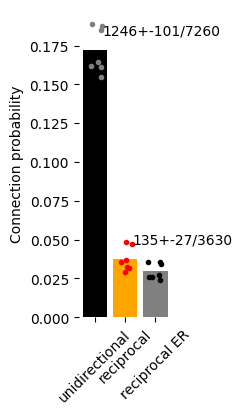

In [232]:
deltas = deltas[(deltas != 0).any(axis=1)]

tst = deltas.reset_index().groupby("subvolume")["level_1"].value_counts().unstack("level_1")
tst["connected"] = tst["reciprocal"] + tst["unidirectional"]
tst["reciprocal_pairs"] = tst["reciprocal"] / 2 # Because the original analysis counts rc pairs twice, once for each direction
tst["sorted_pairs"] = tst["connected"] + tst["unconnected"]
tst["pairs"] = tst["sorted_pairs"] / 2

count = int(tst["sorted_pairs"][0]) # All samplings have the same number. Just using the first.
count_b = int(tst["pairs"][0])

fig = plt.figure(figsize=(1.2, 4))
ax = fig.gca()

x = 0.5 * (numpy.random.rand(len(tst)) - 0.5) + 0
y = tst["connected"].sum() / tst["sorted_pairs"].sum()
mn = int(tst["connected"].mean()); sd = int(tst["connected"].std())
ax.bar(0, y, color="black")
ax.plot(x, tst["connected"] / tst["sorted_pairs"], marker='.', color="grey", ls="None")
ax.text(0.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count))

x = 0.5 * (numpy.random.rand(len(tst)) - 0.5) + 1
y = tst["reciprocal_pairs"].sum() / tst["pairs"].sum()
mn = int(tst["reciprocal_pairs"].mean()); sd = int(tst["reciprocal_pairs"].std())
ax.bar(1, y, color="orange")
ax.plot(x, tst["reciprocal_pairs"] / tst["pairs"], marker='.', color="red", ls="None")
ax.text(1.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count_b))

x = 0.5 * (numpy.random.rand(len(tst)) - 0.5) + 2
y = (tst["connected"].sum() / tst["sorted_pairs"].sum()) ** 2
smpls = tst["pairs"] * (tst["connected"] / tst["sorted_pairs"]) ** 2
mn = int(smpls.mean()); sd = int(smpls.std())
ax.bar(2, y, color="grey")
ax.plot(x, (tst["connected"] / tst["sorted_pairs"]) ** 2, marker='.', color="black", ls="None")
# ax.text(2.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count_b))

ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["unidirectional", "reciprocal", "reciprocal ER"], rotation=45)
ax.set_frame_on(False)
ax.set_ylabel("Connection probability")

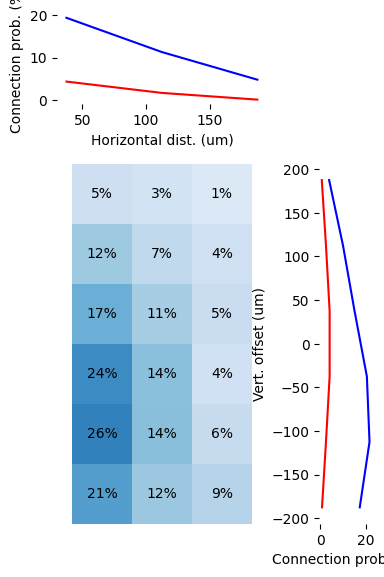

In [309]:
deltas["horizontal"] = numpy.abs(deltas["horizontal"])
deltas = deltas[numpy.any(deltas != 0, axis=1)]

hbins = numpy.arange(0, 300, 75)
hbinc = 0.5 * (hbins[:-1] + hbins[1:])
vbins = numpy.arange(-225, 300, 75)
vbinc = 0.5 * (vbins[:-1] + vbins[1:])
deltas["hbins"] = numpy.digitize(deltas["horizontal"], bins=hbins[:-1]) - 1
deltas["vbins"] = numpy.digitize(deltas["vertical"], bins=vbins[:-1]) - 1



fig = plt.figure(figsize=(3.5, 6.))
ax_c = fig.add_axes([0.1, 0.1, 0.6, 0.6])
ax_t = fig.add_axes([0.1, 0.8, 0.6, 0.15])
ax_r = fig.add_axes([0.85, 0.1, 0.15, 0.6])

tst = deltas.reset_index().groupby("hbins")["level_1"].value_counts().unstack("level_1", fill_value=0)
tst["pairs"] = tst.sum(axis=1)
ax_t.plot(hbinc[tst.index], 100 * tst["reciprocal"] / tst["pairs"], color="red")
ax_t.plot(hbinc[tst.index], 100 * (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"], color="blue")
ax_t.set_xlabel("Horizontal dist. (um)")
ax_t.set_ylabel("Connection prob. (%)")
ax_t.set_frame_on(False)

tst = deltas.reset_index().groupby("vbins")["level_1"].value_counts().unstack("level_1", fill_value=0).drop(-1)
tst["pairs"] = tst.sum(axis=1)
ax_r.plot(100 * tst["reciprocal"] / tst["pairs"], vbinc[tst.index], color="red")
ax_r.plot(100 * (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"], vbinc[tst.index], color="blue")
ax_r.set_ylabel("Vert. offset (um)")
ax_r.set_xlabel("Connection prob. (%)")
ax_r.set_frame_on(False)

tst = deltas.reset_index().groupby(["hbins", "vbins"])["level_1"].value_counts().unstack("level_1", fill_value=0)
tst["pairs"] = tst.sum(axis=1)

tstP = (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"]

ax_c.imshow(tstP.unstack("hbins").drop(-1), cmap="Blues", clim=[-0.05, 0.4],
           extent=[hbins[0], hbins[-1], vbins[-1], vbins[0]])
ax_c.set_ylim(sorted(ax_c.set_ylim()))
ax_c.set_xticks([]); ax_c.set_yticks([]); ax_c.set_frame_on(False)

for hb, hv in enumerate(hbinc):
    for vb, vv in enumerate(vbinc):
        v = tstP[(hb, vb)]
        ax_c.text(hv, vv, "{0}%".format(int(numpy.round(100 * v))),
                 verticalalignment="center", horizontalalignment="center")

#### Show that distance matters
Second panel shows that when sampling at higher distances the reciprocity increases.

Black arrow indicates where a Peng et al.-like sampling is found

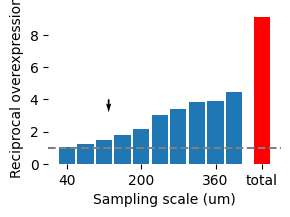

In [247]:
fig = plt.figure(figsize=(3, 2.0))
ax = fig.gca()

x = all_P.index.to_frame()["scale"].values
x_extra = x[-1] + 1.5 * numpy.mean(numpy.diff(x))
ax.bar(x, all_P['reciprocal'] / (all_P['unidirectional'] ** 2), width=35)
ax.bar(x_extra, P_rec_ttl / (P_uni_ttl ** 2), width=35, color="red")
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1, 1], color="grey", ls="--")
ax.quiver([130], [4], [0], [-2])
ticks = x[::4]
ax.set_xticks(list(ticks) + [x_extra])
ax.set_xticklabels(list(ticks) + ["total"])
ax.set_xlabel("Sampling scale (um)")
ax.set_ylabel("Reciprocal overexpression")
ax.set_frame_on(False)

#### Part IIa: Triad motifs at different scales

Text(0, 0.5, 'Sampling scale(um)')

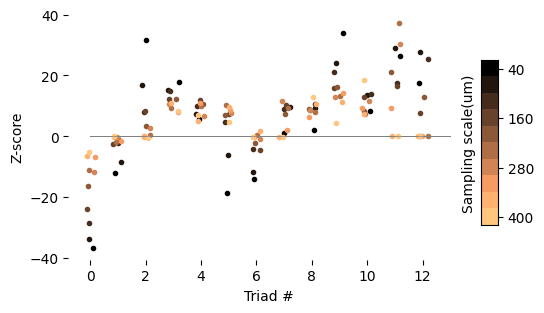

In [248]:
from matplotlib import cm
fig = plt.figure(figsize=(5, 2.75))
ax = fig.add_axes([0.025, 0.025, 0.8, 0.9])

lvls = all_counts.index.levels[0]
cols = cm.copper(numpy.linspace(0, 1, len(lvls)))

for lvl, col in zip(lvls, cols):
    x = all_counts.columns + 0.4 * (numpy.random.rand(len(all_counts.columns)) - 0.5)
    ax.plot(x, all_counts.loc[lvl].mean(), color=col, ls="None", marker='o', ms=3)
    ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

ax = fig.add_axes([0.85, 0.15, 0.035, 0.6])
c = cols.reshape((-1, 1, 4))
ax.imshow(c)
ax.set_xticks([]); ax.yaxis.tick_right()
ticks = numpy.arange(0, len(lvls), 3)
ax.set_yticks(ticks)
ax.set_yticklabels(lvls.values[ticks])
ax.set_ylabel("Sampling scale(um)")